In [1]:
# Import the necesssary libraries

import warnings

warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import (CountVectorizer, TfidfTransformer, TfidfVectorizer)
from sklearn.cluster import (KMeans, AffinityPropagation, AgglomerativeClustering)
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import (PCA, TruncatedSVD)
from nltk.tokenize.treebank import TreebankWordDetokenizer
from sklearn.metrics import (silhouette_score, silhouette_samples, calinski_harabasz_score, davies_bouldin_score)
from sklearn.model_selection import train_test_split

import difflib
import string

from nltk.tokenize.treebank import TreebankWordDetokenizer

## Data Wrangling

In [2]:
# Import the excel file. The excel workbook just has one sheet, so no further action is necessary

data = pd.read_excel(io = 'potential-talents.xlsx')

In [3]:
# See how the data looks like

data.head()

,id,job_title,location,connection,fit
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN


In [4]:
# Check out the shape of the data frame

data.shape

(104, 5)

In [5]:
# Check the types of each data frame

data.dtypes

id              int64
job_title      object
location       object
connection     object
fit           float64
dtype: object

In [6]:
# Count the Null Values

for col in data.columns:
    print(col)
    print(data[col].isna().sum())

id
0
job_title
0
location
0
connection
0
fit
104


In [7]:
# Count the values for conections and locations to get insights of what is the most common locations and connections
# numbers

# Count values for location

data['location'].value_counts(ascending = False)


Kanada                                 12
Raleigh-Durham, North Carolina Area     8
Houston, Texas Area                     8
Greater New York City Area              7
Houston, Texas                          7
Denton, Texas                           6
San Francisco Bay Area                  5
Greater Philadelphia Area               5
Lake Forest, California                 4
İzmir, Türkiye                          4
Atlanta, Georgia                        4
Amerika Birleşik Devletleri             2
Chicago, Illinois                       2
Greater Atlanta Area                    2
Austin, Texas Area                      2
Baltimore, Maryland                     1
Las Vegas, Nevada Area                  1
Virginia Beach, Virginia                1
Jackson, Mississippi Area               1
Gaithersburg, Maryland                  1
Milpitas, California                    1
San Jose, California                    1
Greater Los Angeles Area                1
Torrance, California              

Most of the candidates here are located in "Kanada", Houston Texas (we can replace "Houston, Texas Area"  to "Houston, Texas" because I assume they mean the same exact location. Same on Chicago Greater Chicago Area, New York and so on.  I have to figure out a way to make the program match those type of locations and replace the values on the feature engineering part.

In [8]:
# Count Values for connections

data['connection'].value_counts(ascending = False)

500+     44
61        7
85        7
44        6
1         5
2         4
4         2
390       2
7         2
57        2
5         1
212       1
9         1
268       1
16        1
82        1
19        1
455       1
409       1
155       1
103       1
349       1
415       1
18        1
39        1
40        1
174       1
48        1
49        1
50        1
52        1
71        1
64        1
Name: connection, dtype: int64

In [9]:
# Count the values for job_title

data['job_title'].value_counts(ascending = False)

2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional                 7
Aspiring Human Resources Professional                                                                                    7
Student at Humber College and Aspiring Human Resources Generalist                                                        7
People Development Coordinator at Ryan                                                                                   6
HR Senior Specialist                                                                                                     5
Native English Teacher at EPIK (English Program in Korea)                                                                5
Aspiring Human Resources Specialist                                                                                      5
Human Resources Coordinator at InterContinental Buckhead Atlanta                                                         4
SVP, CHRO, Marke

###### The fit is the dependant variable. We need to determine whats the fit rank for each candidate (Starting by 1)

###### This problem is more about data/feature engineering. We can't do too much data visualization nor statistical inference. After doing the feature engineering process, we can move on to the modeling part. 

## Feature Engineering

In [10]:
# Convert everything into lower case letters

data['job_title'] = data['job_title'].str.lower()
data['location'] = data['location'].str.lower()


In [11]:
# Query based on the keywords

data = data.query('''job_title.str.contains('aspiring human resources') or job_title.str.contains('seeking human resources')''', engine = 'python')

# Reset the index

data = data.reset_index(drop = True)

In [12]:
# Normalize the language inconsistencies

data['location'] = data['location'].replace(to_replace = ['kanada', 'türkiye', 'amerika birleşik devletleri'], 
                                            value = ['canada', 'turkey', 'united states america'], 
                                            regex = True)



In [13]:
# Replace all the rows on location with words such as greater, area, etc, so in the dataframe I will only see the city
# and the state

data['location'] = data['location'].replace(to_replace = ['area', 'greater'], value = '', regex = True)


# Remove spaces in all columns

data.columns = data.columns.str.replace(' ', '')

In [14]:
# Create columns with tokenized words

data['job_title'] = data.apply(lambda x: word_tokenize(x['job_title']), axis = 1)
data['location'] = data.apply(lambda x: word_tokenize(x['location']), axis = 1)


In [15]:
# Create a nested list where I will make a for loop to remove all the stop words

# List for job_title

job_title_values = data['job_title'].values

# List for location

location_values = data['location'].values

In [16]:
# Define a function to remove points, parentheses, dots, commas, etc

def cleaner(array):
    
    clean_list = []
    
    for i in array:
        
        # Create an empty list that will be appended to the clean_list to keep dimensions
        empty_list = []
        
        for j in i:
            
            # Use translate function in python to replace all the punctuation values to None and then remove them
            value = j.translate({ord(j):None for j in string.punctuation})
            # Append the desirables values
            empty_list.append(value)
        # Append the empty list to the clean list
        clean_list.append(empty_list)
    # Return the clean list
    return clean_list


In [17]:
# Apply the function to the job_title and location column

job_title_cleaner = cleaner(array = job_title_values)

location_cleaner = cleaner(array = location_values)

In [18]:
# Define a function to remove the None

def none_remover(array):
    # Create an empty list
    clean_list = []
    # Start a for loop for each sublist in the complete list
    for i in array:
        # Filter the none values in each sublist
        value = list(filter(None, i))
        # Append the desired string
        clean_list.append(value)
    # Return the clean list
    return clean_list
    

In [19]:
# Apply the none_remove function to the job_title and location column

job_title_cleaner2 = none_remover(array = job_title_cleaner)

location_cleaner2 = none_remover(array = location_cleaner)

In [20]:
# Define a function to remove the stop words

def stop_words_remover(array):
    # Set the stop workds
    stop_words = set(stopwords.words('english'))
    # Create an empty list
    clean_list = []
    for i in array:
        # Create an empty list with the sublist
        empty_list = []  
        for j in i:
            if j not in stop_words:  
                empty_list.append(j)  
        clean_list.append(empty_list)
    return clean_list
            

In [21]:
# Use the function to remove the stop words in the job_title and location column

job_title_cleaner3 = stop_words_remover(array = job_title_cleaner2)

location_cleaner3 = stop_words_remover(array = location_cleaner2)

In [22]:
# Replace the data frames for the clean ones

data['job_title'] = job_title_cleaner3

data['location'] = location_cleaner3

In [23]:
# Untokenize the location column

untokenized = [TreebankWordDetokenizer().detokenize(i) for i in location_cleaner3]

In [24]:
# Set the column location to be the untokenized data

data['location'] = untokenized

# Change philadelphia row for the city plus state Pensilvania and new york city to new york, new york

data['location'] = data['location'].replace(to_replace = 'philadelphia',value = 'philadelhia pensilvania')\
                    .replace(to_replace = 'new york city', value = 'new york new york')

In [25]:
# Quickly check the new value counts

data['location'].value_counts()

houston texas                   10
canada                           7
raleighdurham north carolina     6
new york new york                6
philadelhia pensilvania          4
austin texas                     2
chicago illinois                 2
kokomo indiana                   1
baton rouge louisiana            1
san jose california              1
monroe louisiana                 1
cape girardeau missouri          1
las vegas nevada                 1
Name: location, dtype: int64

In [26]:
# Untokenize the job_title column

untokenized = [TreebankWordDetokenizer().detokenize(i) for i in job_title_cleaner3]

# Set the new column to be the untokenized data
data['job_title'] = untokenized    

In [27]:
# Quickly check the value counts

data['job_title'].value_counts()

student humber college aspiring human resources generalist                                                   7
2019 ct bauer college business graduate magna cum laude aspiring human resources professional                7
aspiring human resources professional                                                                        7
aspiring human resources specialist                                                                          5
seeking human resources hris generalist positions                                                            4
aspiring human resources management student seeking internship                                               2
seeking human resources opportunities                                                                        2
aspiring human resources professional passionate helping create inclusive engaging work environment          1
seeking human resources position                                                                             1
e

## Modeling

In [28]:
# From the data frame create one column with all the information together

# Change the number 500+ for just 500

data['connection'] = data['connection'].replace(to_replace = '500', value = 500, regex = True)
 
# Change the connection column to strings

data['connection'] = data['connection'].astype(str)

# Have all the strings in one column

data['independent'] = data['job_title'].add(' ').add(data['location']).add(' ').add(data['connection'])

In [29]:
data.head()

,id,job_title,location,connection,fit,independent
0,1,2019 ct bauer college business graduate magna ...,houston texas,85,NaN,2019 ct bauer college business graduate magna ...
1,3,aspiring human resources professional,raleighdurham north carolina,44,NaN,aspiring human resources professional raleighd...
2,6,aspiring human resources specialist,new york new york,1,NaN,aspiring human resources specialist new york n...
3,7,student humber college aspiring human resource...,canada,61,NaN,student humber college aspiring human resource...
4,9,student humber college aspiring human resource...,canada,61,NaN,student humber college aspiring human resource...


In [30]:
# Set the independant variable

X = data['independent'].values

In [31]:
# Create all the values to single string to see the most important values in all the document

X2 = ''.join(X)
X2 = [X2]

In [32]:
# Define a function to calculate the word importance

def word_importance_doc(array):
    # Calculate the word importance for each column
    # Set the stop words to english
    tfidfvectorizer = TfidfVectorizer(analyzer='word',stop_words= 'english')
    # Transform the X variable
    tfidf_wm = tfidfvectorizer.fit_transform(array)
    # Get the feature names
    tfidf_tokens = tfidfvectorizer.get_feature_names()
    # Save the results in a dataframe
    df_tfidfvect = pd.DataFrame(data = tfidf_wm.toarray(), index = array, columns = tfidf_tokens)
    # Return the data frame
    return df_tfidfvect

# Define a function that will calculate the word importance for each feature

def word_importance(df, n_row):
    df_converted = df.iloc[n_row, :]
    df_converted = df_converted[df_converted > 0]
    return df_converted

In [33]:
# Use the function to calculate the word importance for the first X array

df_word_importance = word_importance_doc(array = X)

In [34]:
# As an example, let's check the first row (0 indexed)

word_importance(df = df_word_importance, n_row = 0)

2019            0.289687
85              0.289687
aspiring        0.128596
bauer           0.289687
business        0.277072
college         0.222361
ct              0.289687
cum             0.289687
graduate        0.289687
houston         0.255580
human           0.107103
laude           0.289687
magna           0.289687
professional    0.202834
resources       0.107103
texas           0.237688
Name: 2019 ct bauer college business graduate magna cum laude aspiring human resources professional houston texas 85, dtype: float64

In [35]:
# Get the word importance using all the document

df_word_importance2 = word_importance_doc(array = X2)

# Save the df as a transpose (in this particular case)

df_word_importance2_transponse = df_word_importance2.T

# Check Out the word imortance

word_importance = df_word_importance2_transponse.nlargest(n = 10, columns = df_word_importance2_transponse.columns[0])

word_importance.columns = ['Importance']

In [36]:
# See the most important words in our document

word_importance

,Importance
human,0.563823
resources,0.563823
aspiring,0.213000
professional,0.213000
college,0.175412
new,0.150353
texas,0.150353
york,0.150353
generalist,0.137823
houston,0.125294


In [37]:
# Define a function to start the pipeline for the preprocessor of the data

def pipeline(est1):
    # The pipeline will just take one argument that will be which type of preprocessor does the user want.
    # To reduce the dimensionality, I'm suing the TruncatedSVD function to 2 components
    pipe = Pipeline([('est1', est1), ('pca', TruncatedSVD(n_components = 2))])
    return pipe

In [38]:
# Define the pipeline for the estimator (Model that will be used)

def pipeline2(est2):
    # This function will just take one argument (The model the user wants)
    pipe2 = Pipeline([('est2', est2)])
    return pipe2

In [39]:
# Define the pipeline that will join the pipeline for preprocessing and the predictor model

def pipeline3(pipeline, pipeline2):
    # The third pipeline will make a complete pipeline with the preprocessor and the predictor
    pipe3 = Pipeline([('preprocessor', pipeline), ('predictor', pipeline2)])
    return pipe3

In [40]:
# Define a dataframe that will store all the results 

def results_df(preprocessing, predictions):
    # Save the points with the predictions
    df = pd.DataFrame(preprocessing, columns = ['x', 'y'])
    df['results'] = predictions
    # Concat the original columns from the dataset
    df['id'] = data['id']
    df['job_title'] = data['job_title']
    df['location'] = data['location']
    df['connection'] = data['connection']
    return df

In [41]:
def KMeans_elbow(transformer, array):
    distortions = []
    clusters = np.arange(2,21,1)
    
    for c in clusters:
        pipe_preprocessing = pipeline(est1 = transformer)
        pipe_predictor = pipeline2(est2 = KMeans(n_clusters = c))
        pipe_kmeans = pipeline3(pipeline = pipe_preprocessing, pipeline2 = pipe_predictor)
        
        pipe_kmeans.fit(array)
        distortions.append(pipe_kmeans['predictor']['est2'].inertia_)
        
    plt.plot(clusters, distortions, 'bx-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.title('The Elbow Method to find the optimal number of clusters')
    plt.xticks(clusters)
    return plt.show

In [42]:
def silhoutte_score_validation(model, transformer, array):

    clusters = np.arange(2,21,1)
    
    preprocessed_data = transformer
    
    preprocessed_data = transformer.fit_transform(array)
    
    preprocessed_data = preprocessed_data.todense()
    
    for n_clusters in clusters:
    
        # Create a subplot with 1 row and 2 columns
        fig, ax1 = plt.subplots(1, 1)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        predictor = model(n_clusters)
        cluster_labels = predictor.fit_predict(preprocessed_data)
        

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(preprocessed_data, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(preprocessed_data, cluster_labels)

        y_lower = 10
    
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            #cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
 
        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),fontsize=14, fontweight='bold')

    return plt.show()
    

In [43]:
# Define the function to plot the scatter plots with the different clusters

def plot_scatter(df, keyword, title):
    # This will group based on the different labels
    sns.scatterplot(x = 'x', y = 'y', hue = 'results', data = df, palette = sns.color_palette("tab10", 
                                                            len(df['results'].unique())))
    # The keywords will be plotted in the space 
    plt.scatter(keyword[0][0], keyword[0][1], s = 70, marker = 'X', color = 'black')
    plt.legend(loc = (1.05,0.5))
    plt.title(title)
    return plt.show()

In [44]:
# Define a function to calculate the extra row that calculates distance

def euclidean_distance(df, keyword):
    #Euclidean distance use the pythagoras theorem to calculate the distance between two coordenates
    distance = [np.sqrt(((
                    df.iloc[i][0] - keyword[0][0]) ** 2) 
                        + ((df.iloc[i][1] - keyword[0][1]) ** 2)) for i in range(0, len(df))]
    # Save the euclidean distance in a column
    df['distance'] = distance
    # Sort the values in ascending order (lower euclidean distance means higher fit)
    df = df.sort_values(by = 'distance', ascending = True)
    # Use softmax action with the exponential distance to calculate probabilities.
    df['fit'] = np.exp(-df['distance'])
    return df

In [45]:
# Define a function that prints the Calinski Score

def metric_score(array1, array2):
    score1 = calinski_harabasz_score(array1, array2)
    score2 = davies_bouldin_score(array1, array2)
    print('The Calinski Harabasz Score is {}'.format(score1))
    print('The Davies Bouldin score is {}'.format(score2))

### K-Means

In [46]:
# Establish how many candidates are going to be taken in consideration

number_candidates = int(input('Insert Number of candidates you want to check out: '))

Insert Number of candidates you want to check out: 7


#### Count Vectorization

<function matplotlib.pyplot.show(*args, **kw)>

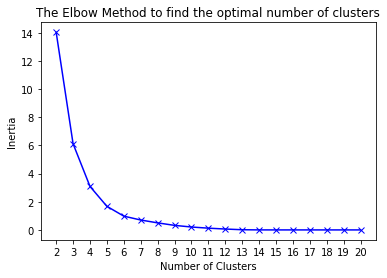

In [47]:
# Plot the Elbow Method to find the optimal number of clusters

KMeans_elbow(transformer = CountVectorizer(lowercase = False), array = X)

From the elbow method, I'm maybe using 4-5 clusters

For n_clusters = 2 The average silhouette_score is : 0.342735573410393
For n_clusters = 3 The average silhouette_score is : 0.4212166164425531
For n_clusters = 4 The average silhouette_score is : 0.4725315689755202
For n_clusters = 5 The average silhouette_score is : 0.5460821008490822
For n_clusters = 6 The average silhouette_score is : 0.6319838897133839
For n_clusters = 7 The average silhouette_score is : 0.6555115424031187
For n_clusters = 8 The average silhouette_score is : 0.6832711765432754
For n_clusters = 9 The average silhouette_score is : 0.6647380215738393
For n_clusters = 10 The average silhouette_score is : 0.6900941456079506
For n_clusters = 11 The average silhouette_score is : 0.7164446809178522
For n_clusters = 12 The average silhouette_score is : 0.7427307357981152
For n_clusters = 13 The average silhouette_score is : 0.749292593698166
For n_clusters = 14 The average silhouette_score is : 0.7624023478454032
For n_clusters = 15 The average silhouette_score is : 0.75898

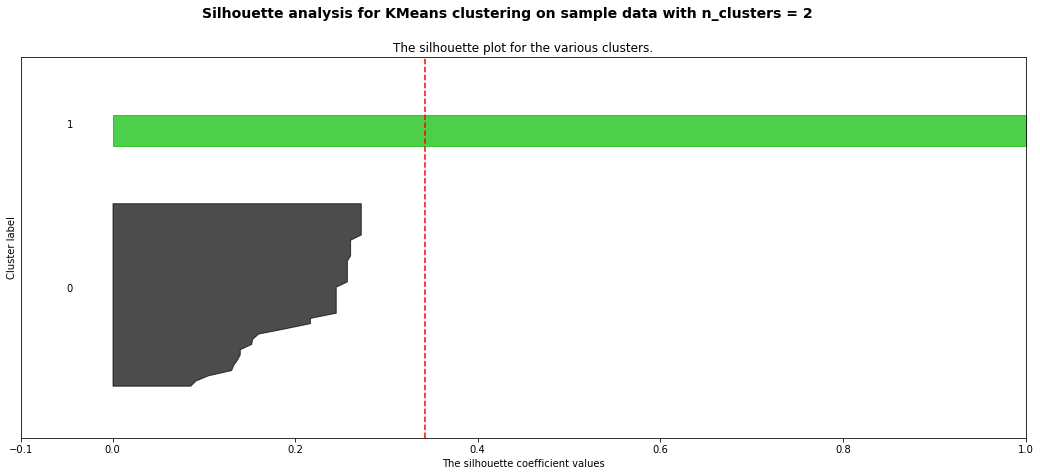

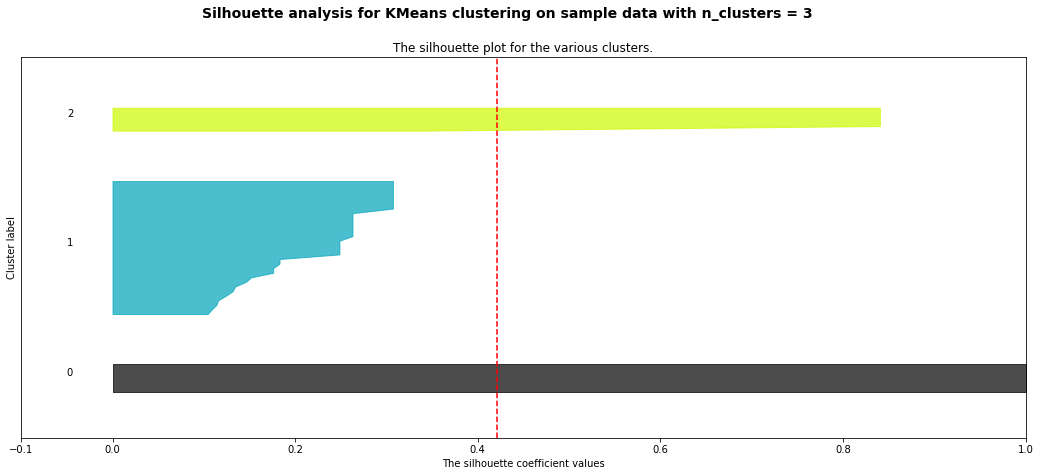

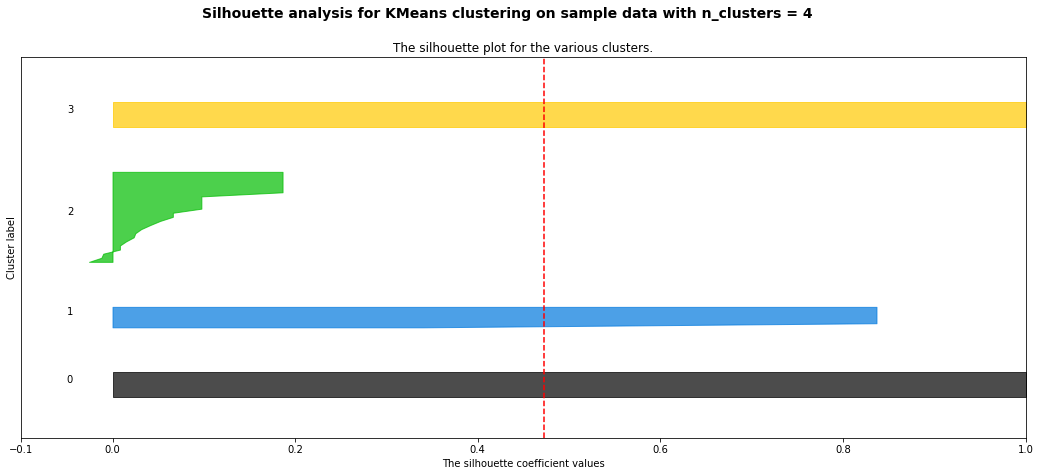

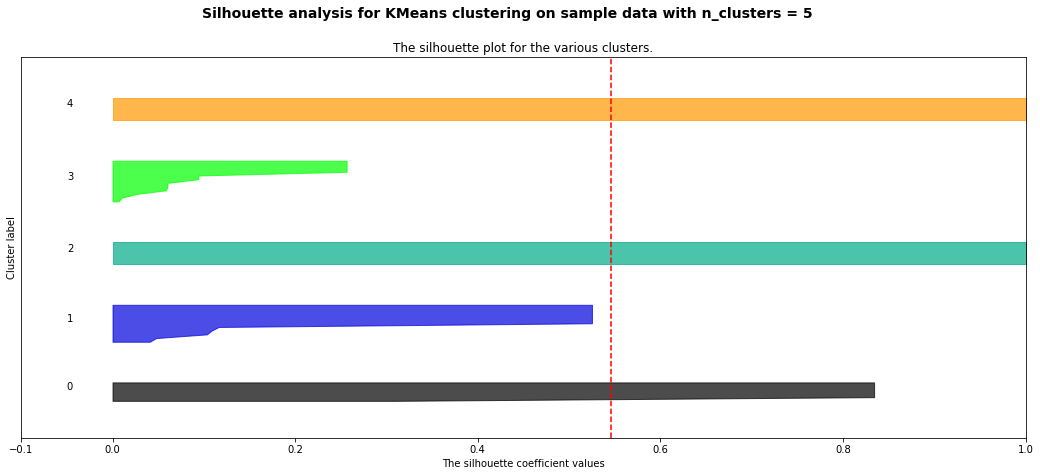

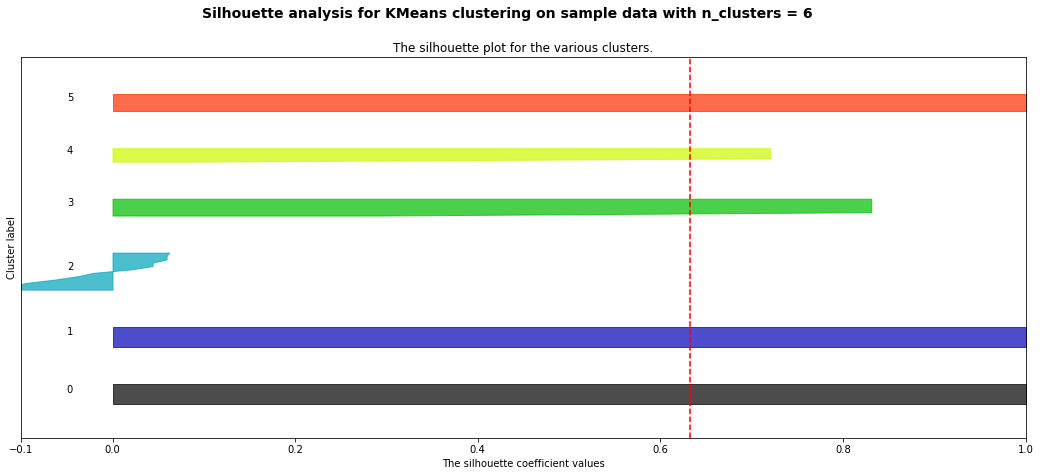

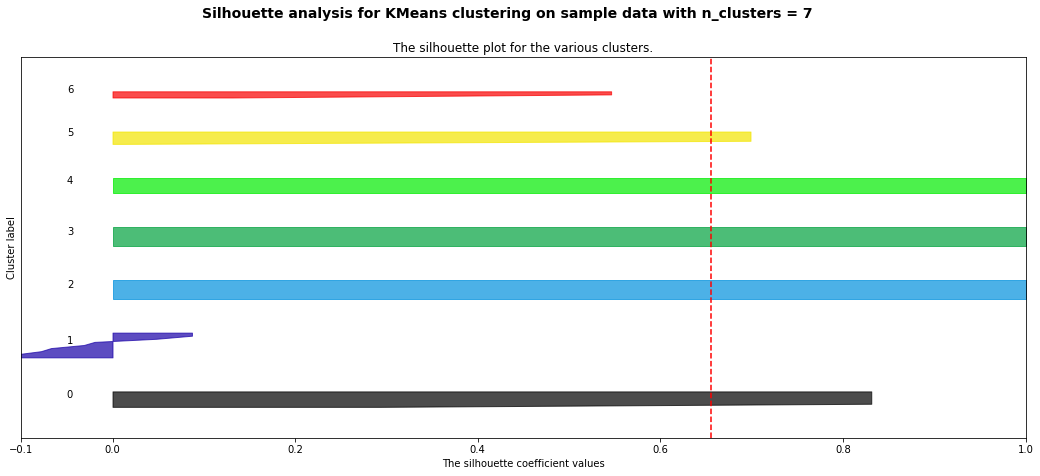

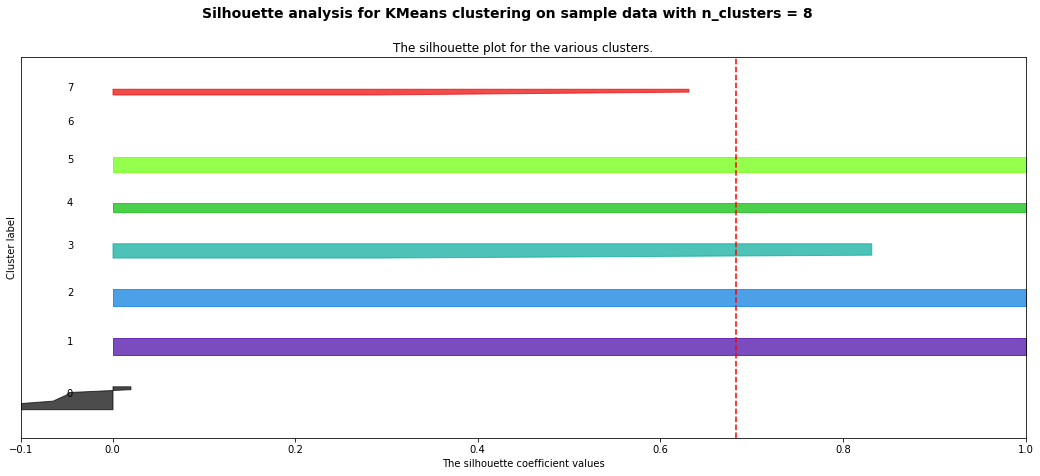

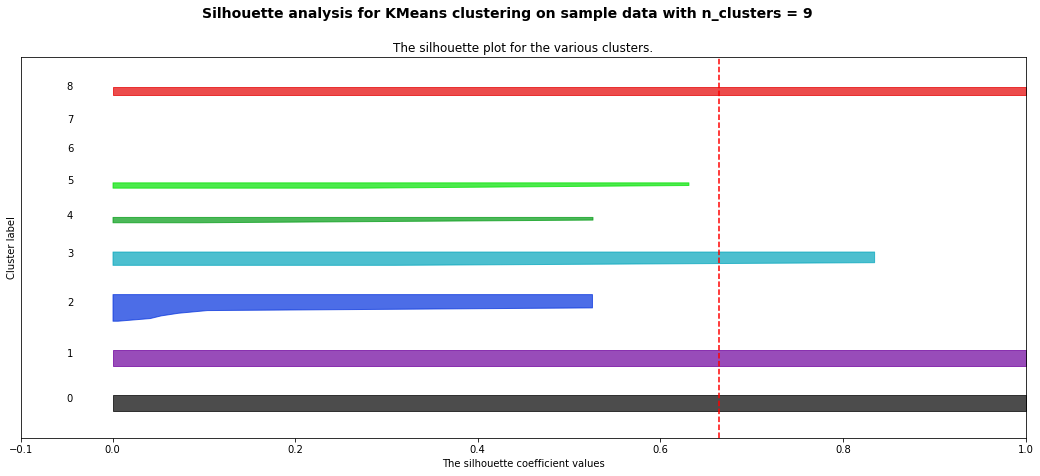

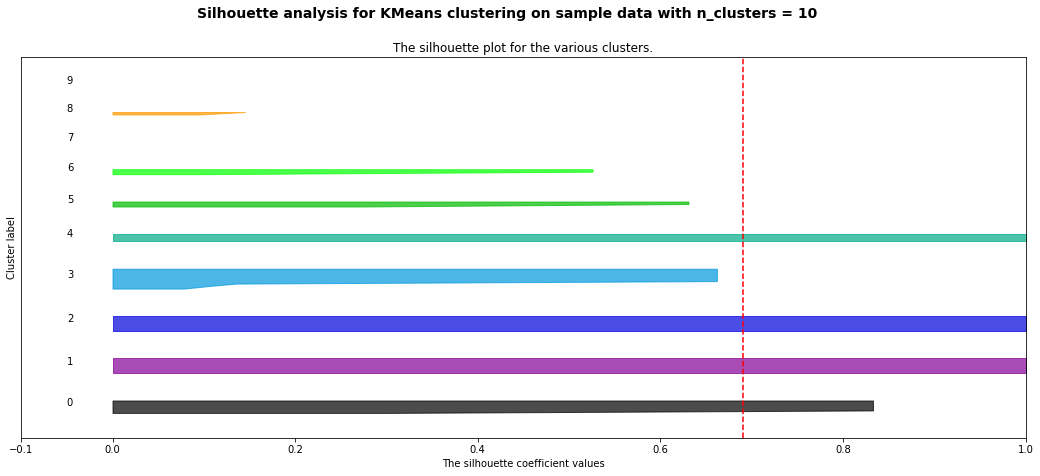

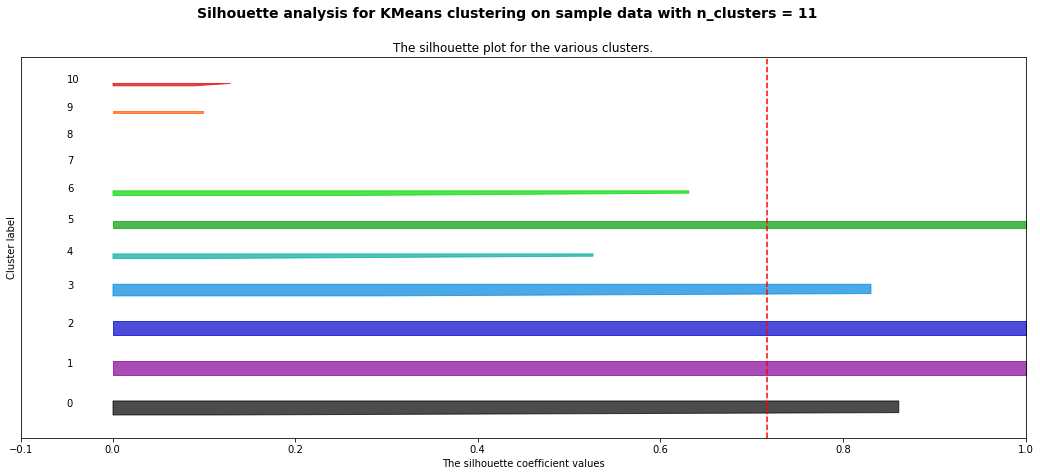

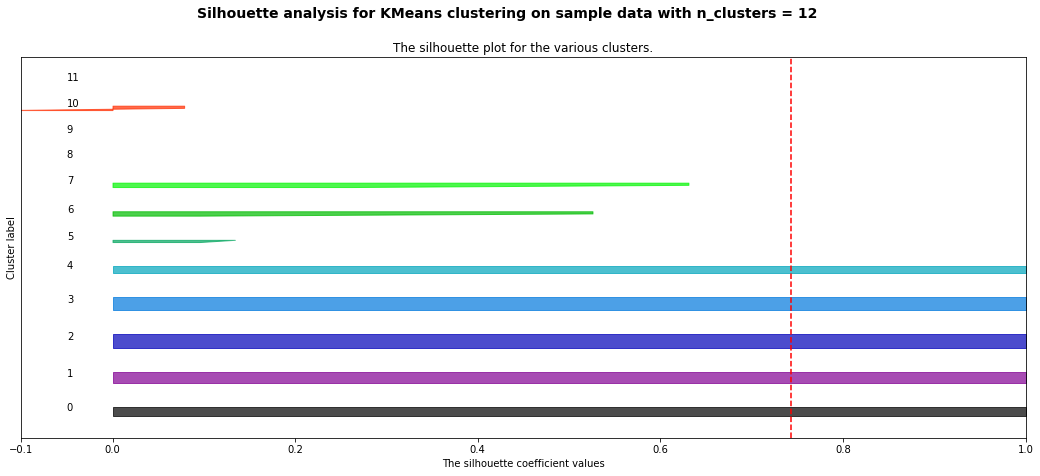

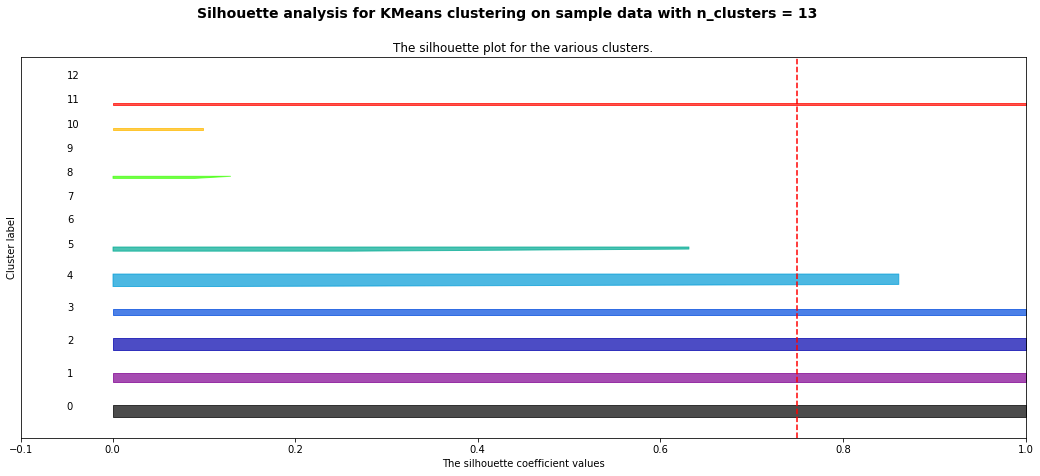

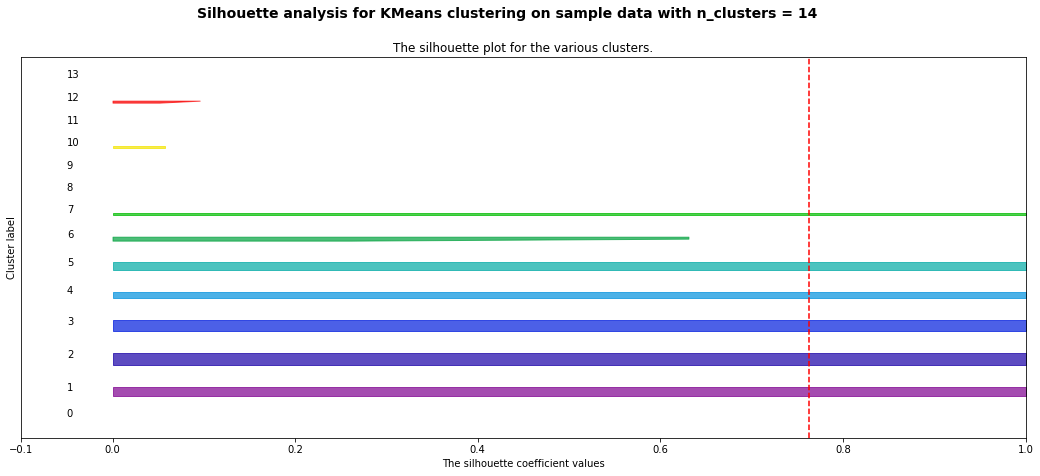

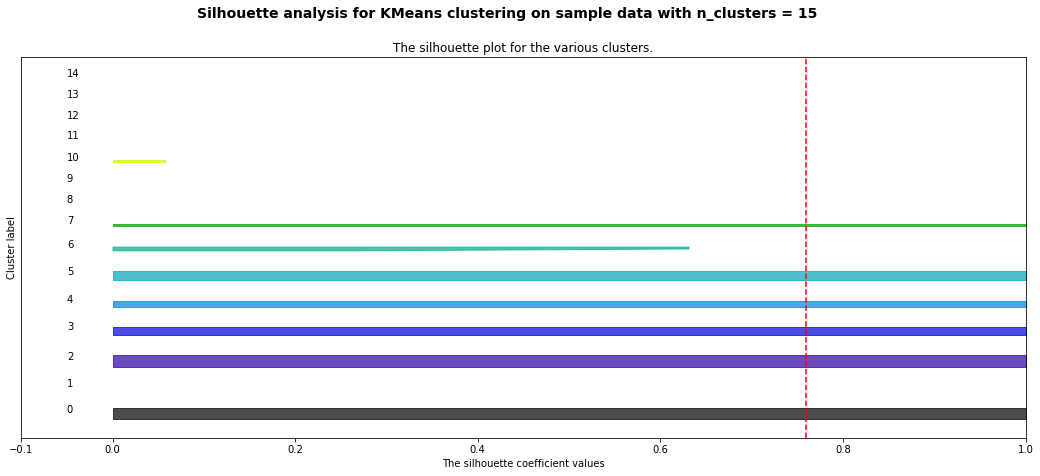

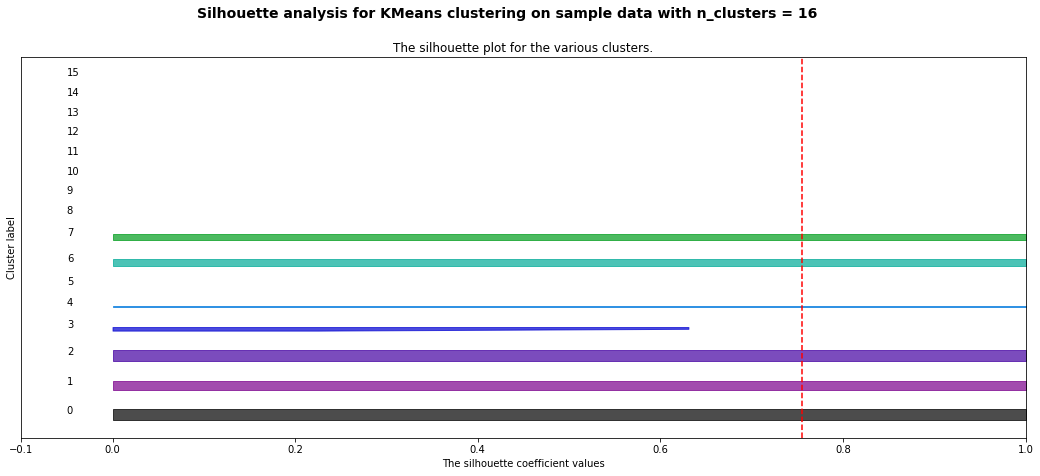

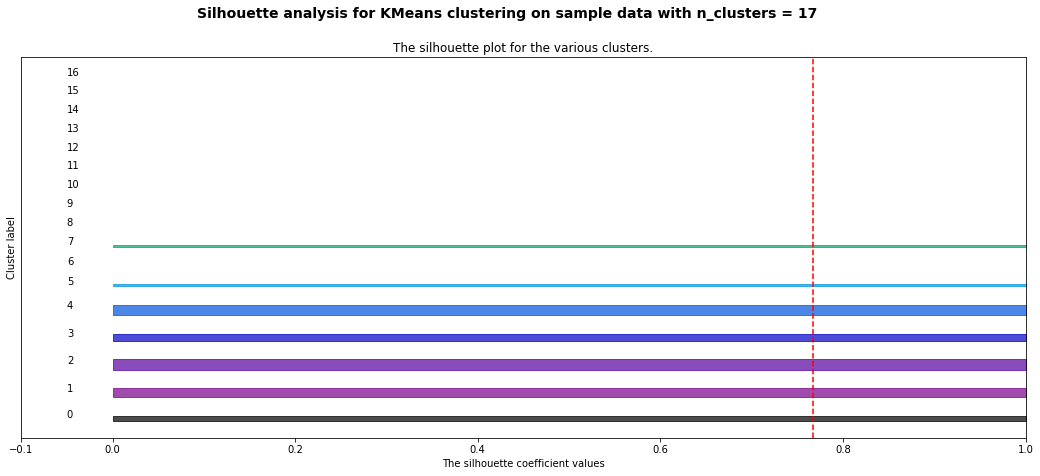

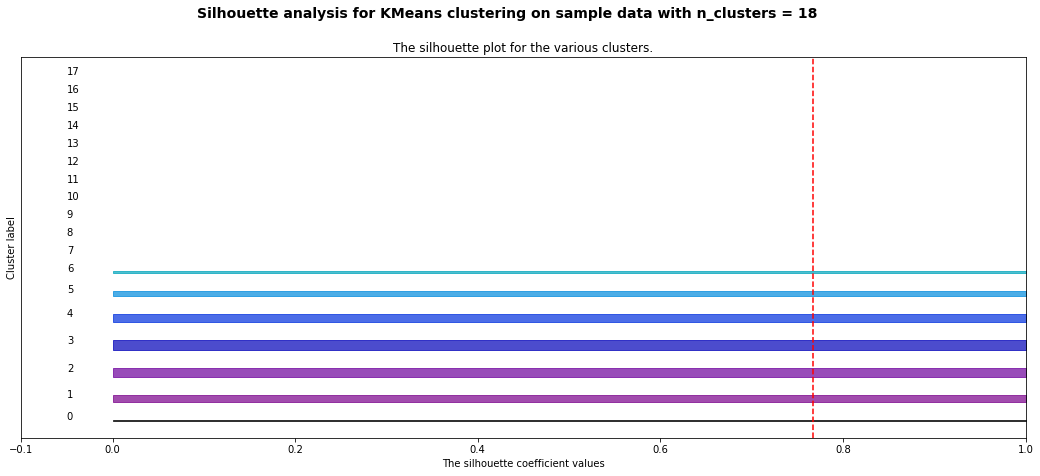

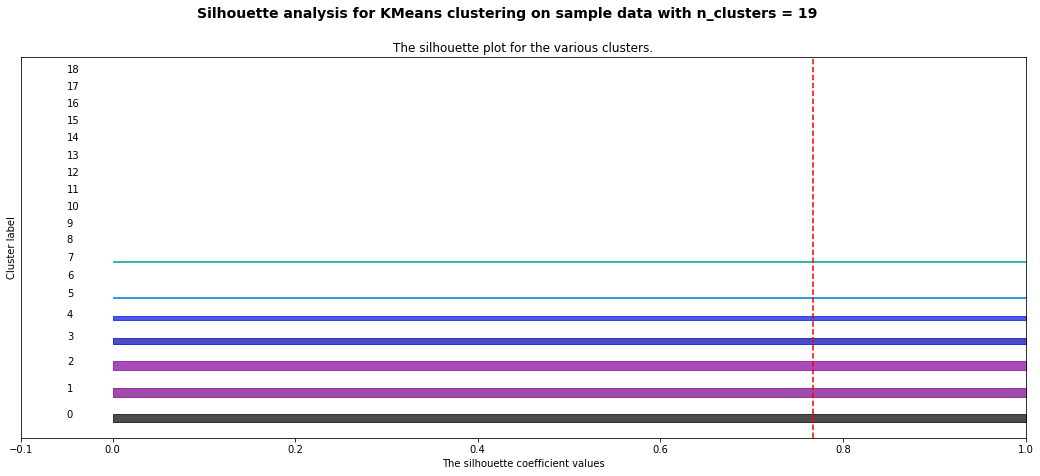

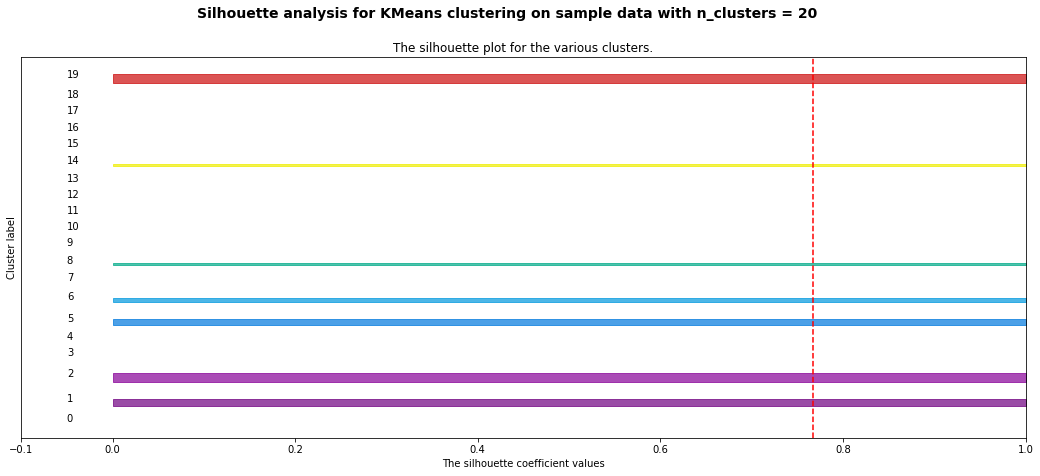

In [48]:
# Evaluate the different models using the Silhoutte Score

silhoutte_score_validation(model = KMeans, transformer = CountVectorizer(lowercase = False), array = X)

###### The best number of clusters to select after multiple repetitions would be 3 to prevent the mislabel of the clusters. 

###### Silhoutte Score for this is 0.42

In [49]:
# Creation of the pipeline with 5 as number of clusters

pipe_preprocessing = pipeline(est1 = CountVectorizer(lowercase = False))

pipe_predictor = pipeline2(est2 = KMeans(n_clusters = 3))

pipe_kmeans_cv = pipeline3(pipeline = pipe_preprocessing, pipeline2 = pipe_predictor)

# Fit the final pipeline

pipe_kmeans_cv.fit(X)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('est1', CountVectorizer(lowercase=False)),
                                 ('pca', TruncatedSVD())])),
                ('predictor',
                 Pipeline(steps=[('est2', KMeans(n_clusters=3))]))])

In [50]:
# Transform the data for the preprocessor

preprocessed_data = pipe_kmeans_cv['preprocessor'].transform(X)

# Labels Predictions

predicted_labels = pipe_kmeans_cv['predictor']['est2'].labels_

# Identify the centroids

clusters = pipe_kmeans_cv['predictor']['est2'].cluster_centers_

In [51]:
# Get the coordenates for the keyword ("Aspiring Human Resources")

keywords_preprocessed = pipe_kmeans_cv['preprocessor'].transform(["seeking aspiring human resources"])

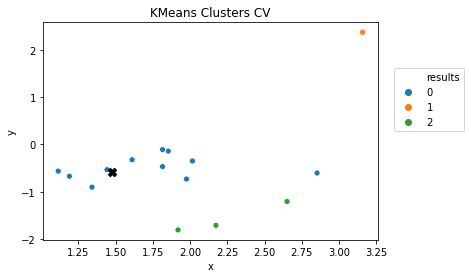

In [52]:
# Save the results in a data frame

results = results_df(preprocessing = preprocessed_data, predictions = predicted_labels)

# Plot the scatter plot with the centroids

plot_scatter(df = results, keyword = keywords_preprocessed, title = 'KMeans Clusters CV')

In [53]:
# See the fit of each person based on the euclidean distance

results_kmean_cv = euclidean_distance(df = results, keyword = keywords_preprocessed).head(number_candidates)

In [54]:
# Calculation of the Calinski Harabasz Score

metric_score(array1 = preprocessed_data, array2 = predicted_labels)

The Calinski Harabasz Score is 254.4616873615014
The Davies Bouldin score is 0.3914231949764164


In [55]:
results_kmean_cv

,x,y,results,id,job_title,location,connection,distance,fit
38,1.442264,-0.534609,0,79,liberal arts major aspiring human resources an...,baton rouge louisiana,7,0.066420,0.935738
36,1.189929,-0.672782,0,75,nortia staffing seeking human resources payrol...,san jose california,500,0.295644,0.744052
40,1.610725,-0.324884,0,97,aspiring human resources professional,kokomo indiana,71,0.300442,0.740491
34,1.614871,-0.318627,0,72,business management major aspiring human resou...,monroe louisiana,5,0.307900,0.734989
32,1.341593,-0.904371,0,62,seeking human resources hris generalist positions,philadelhia pensilvania,500,0.338855,0.712586
22,1.341593,-0.904371,0,40,seeking human resources hris generalist positions,philadelhia pensilvania,500,0.338855,0.712586
28,1.341593,-0.904371,0,53,seeking human resources hris generalist positions,philadelhia pensilvania,500,0.338855,0.712586


#### TF-IDF

<function matplotlib.pyplot.show(*args, **kw)>

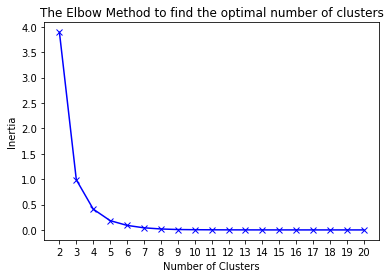

In [56]:
# Plot the Elbow Method to find the optimal number of clusters

KMeans_elbow(transformer = TfidfVectorizer(lowercase = False), array = X)

For n_clusters = 2 The average silhouette_score is : 0.18699567508993314
For n_clusters = 3 The average silhouette_score is : 0.35762894284601005
For n_clusters = 4 The average silhouette_score is : 0.49794990131419986
For n_clusters = 5 The average silhouette_score is : 0.592787475911502
For n_clusters = 6 The average silhouette_score is : 0.6135408087410273
For n_clusters = 7 The average silhouette_score is : 0.7128347720518349
For n_clusters = 8 The average silhouette_score is : 0.7253986868454646
For n_clusters = 9 The average silhouette_score is : 0.7351870581159546
For n_clusters = 10 The average silhouette_score is : 0.7346108013014211
For n_clusters = 11 The average silhouette_score is : 0.7459917270664161
For n_clusters = 12 The average silhouette_score is : 0.7585983782142046
For n_clusters = 13 The average silhouette_score is : 0.7576129898193189
For n_clusters = 14 The average silhouette_score is : 0.7532127777295555
For n_clusters = 15 The average silhouette_score is : 0.7

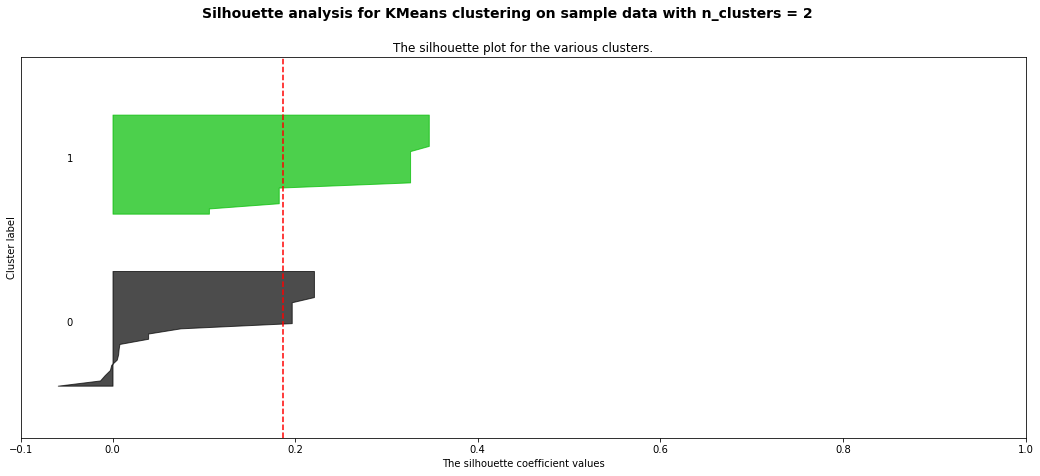

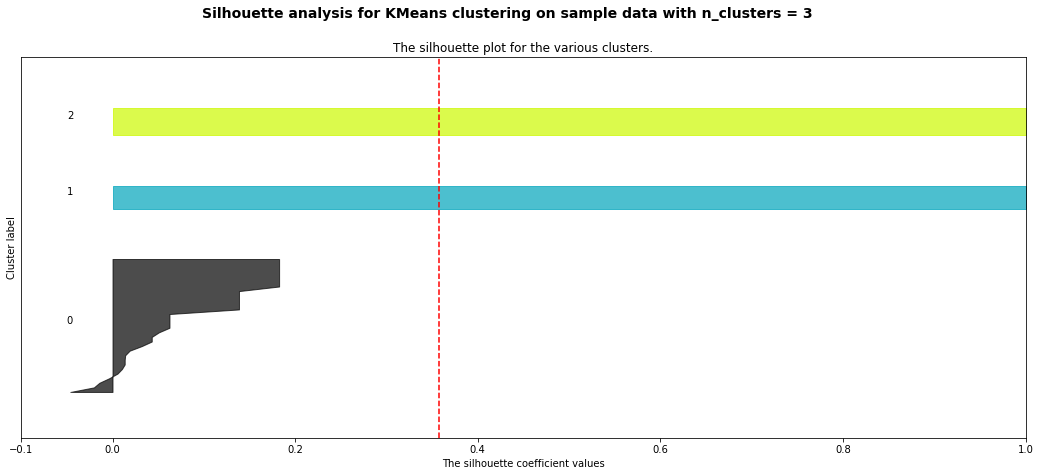

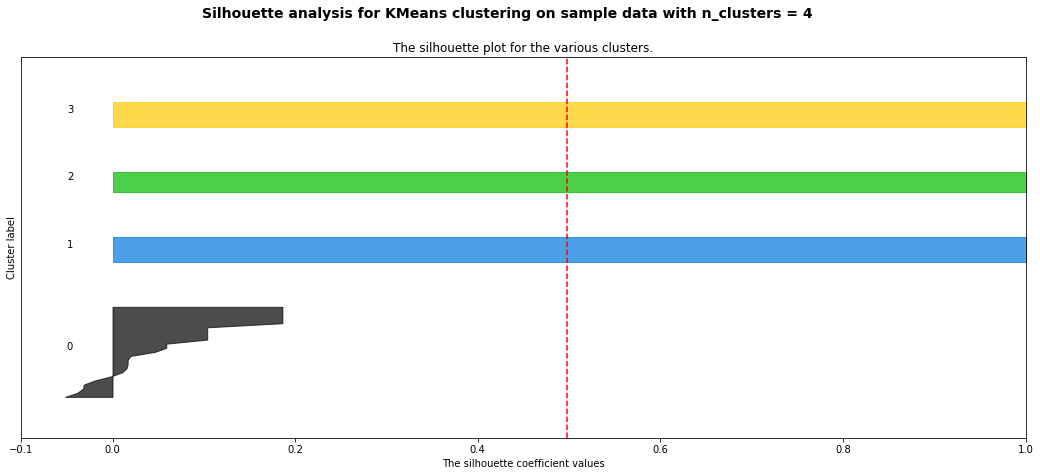

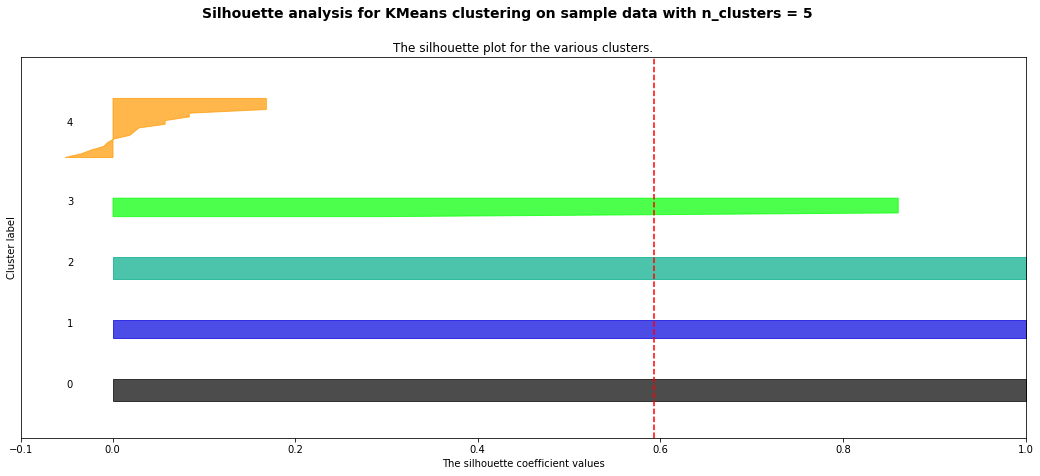

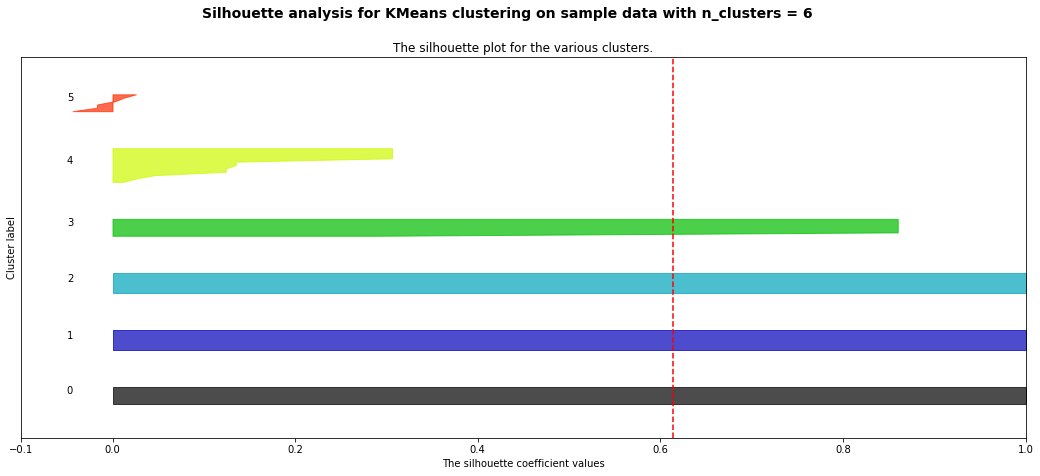

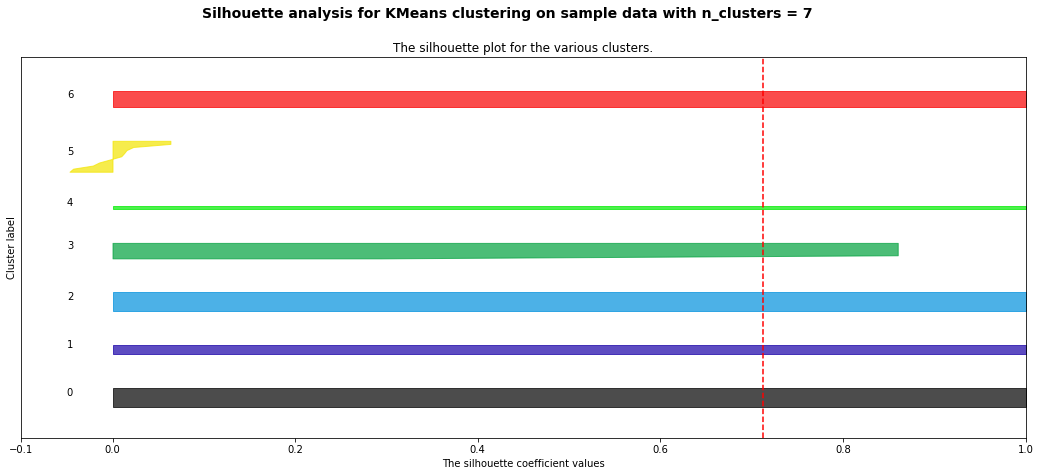

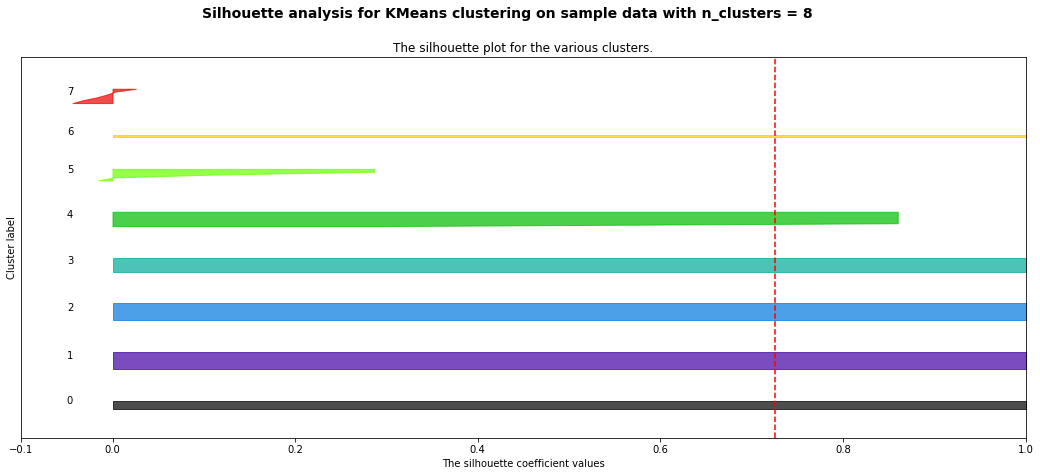

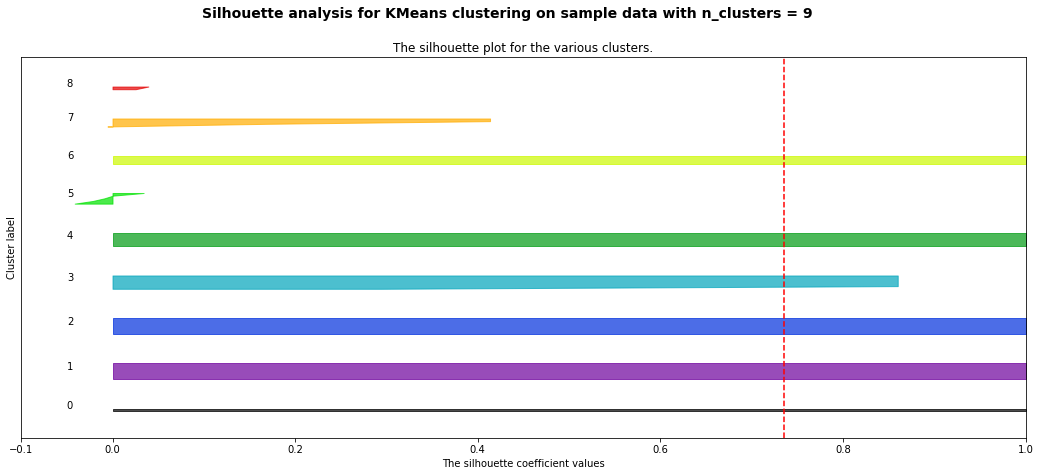

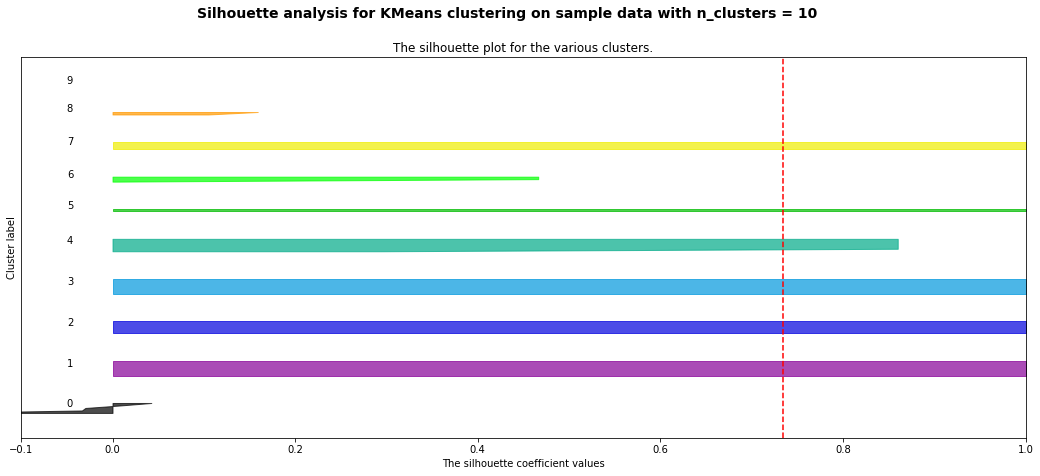

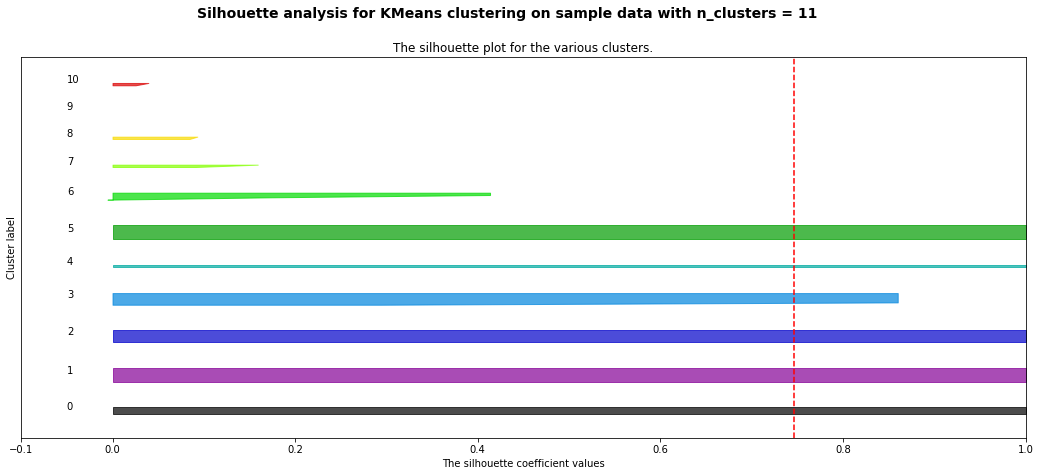

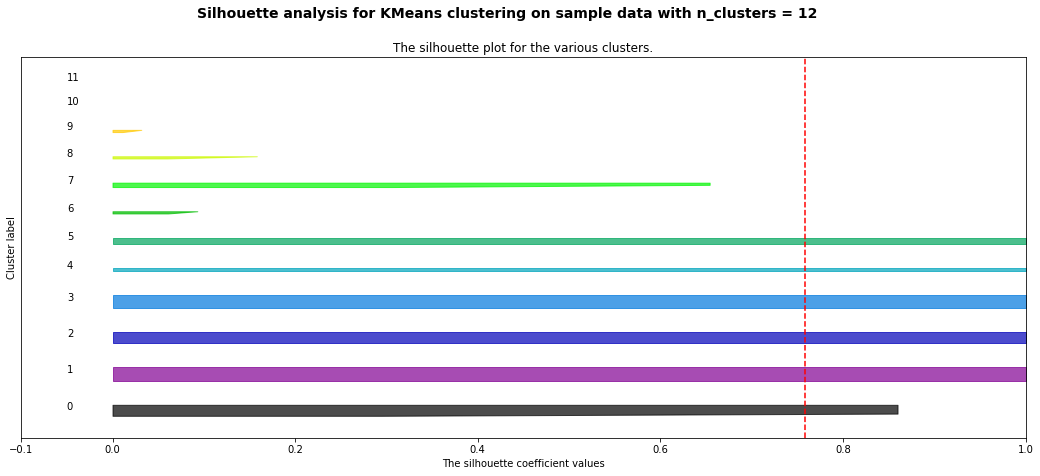

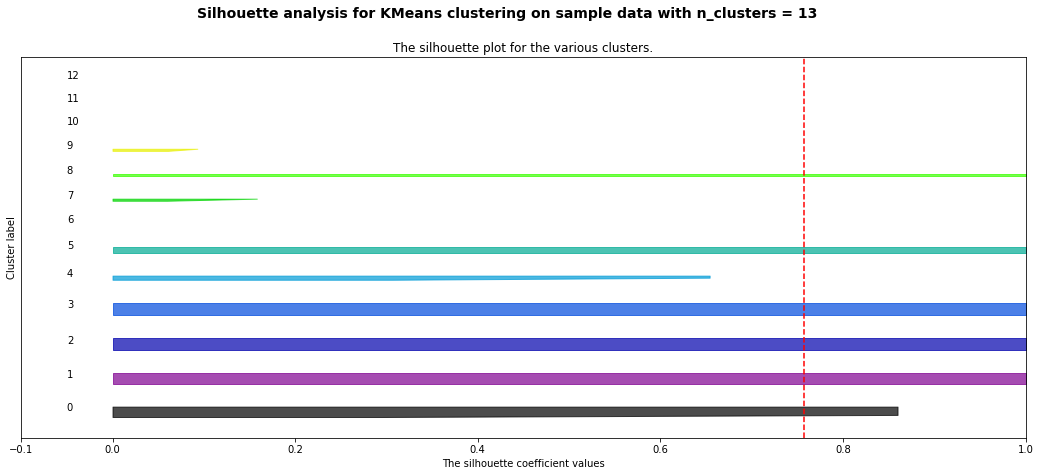

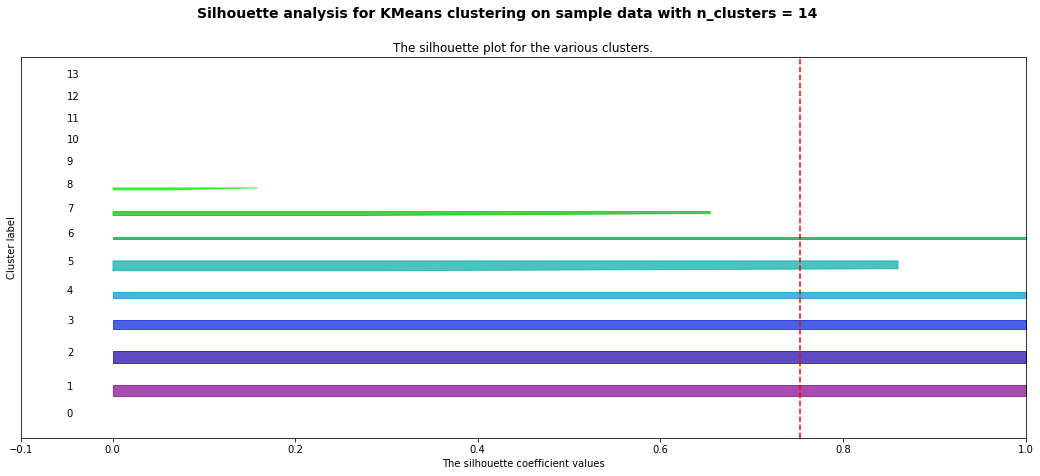

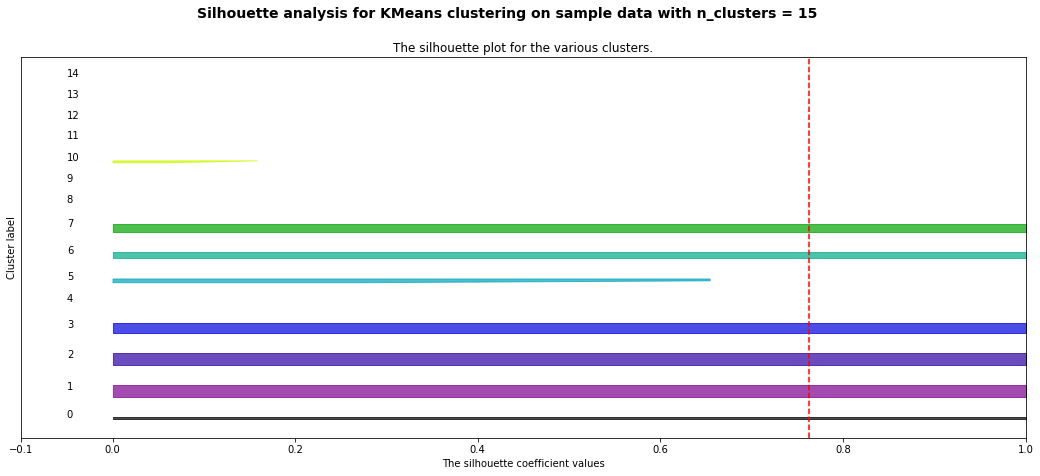

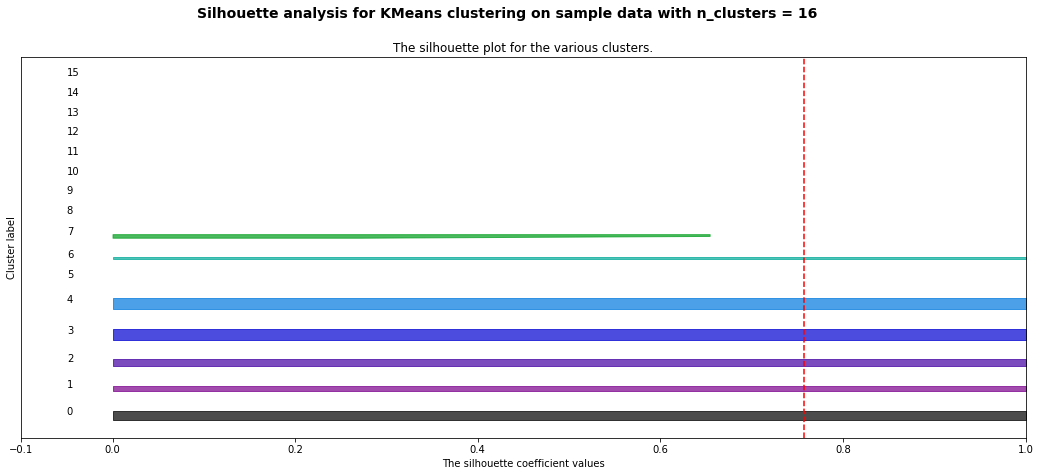

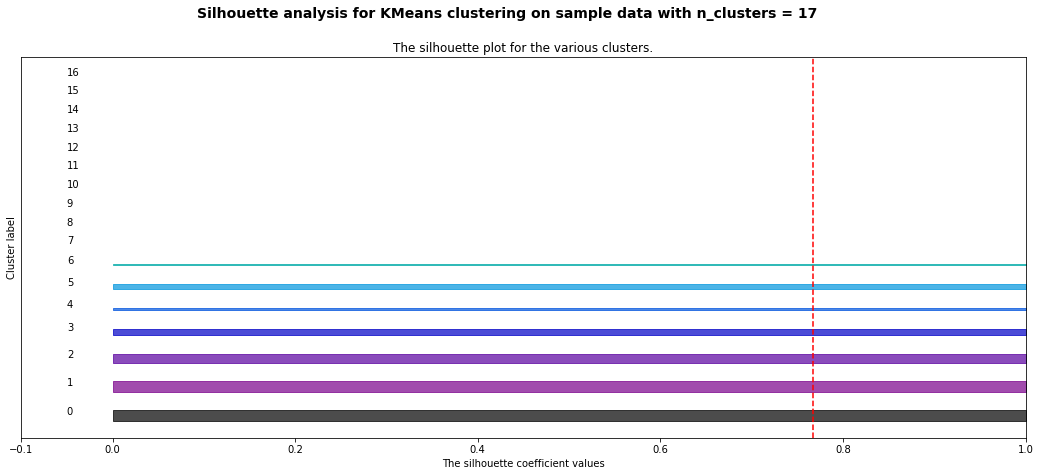

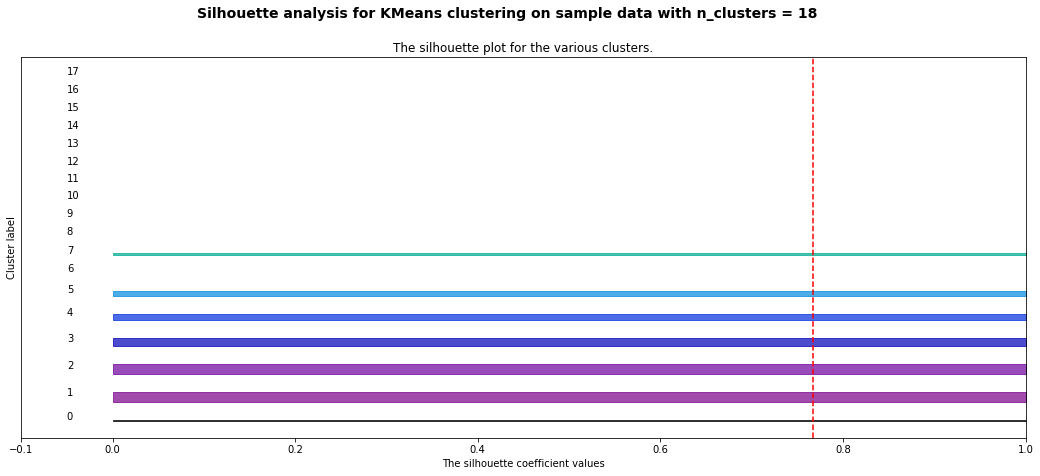

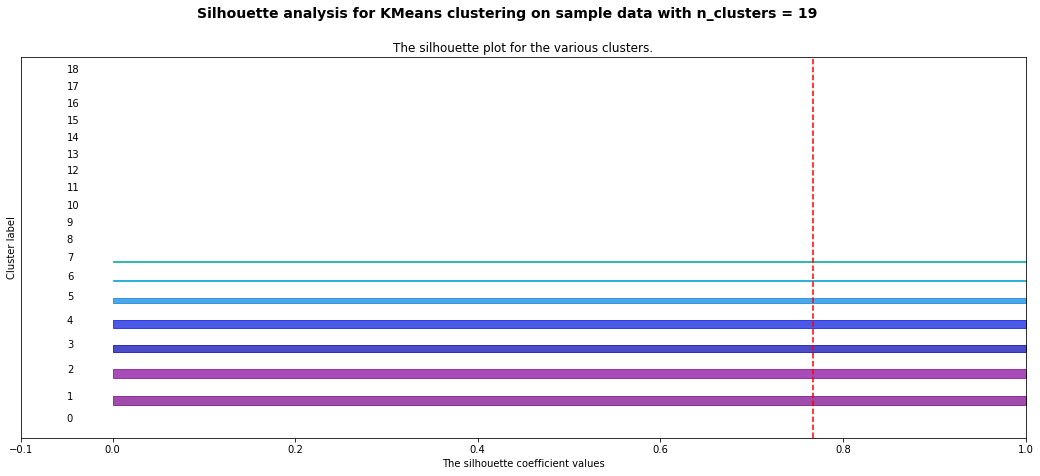

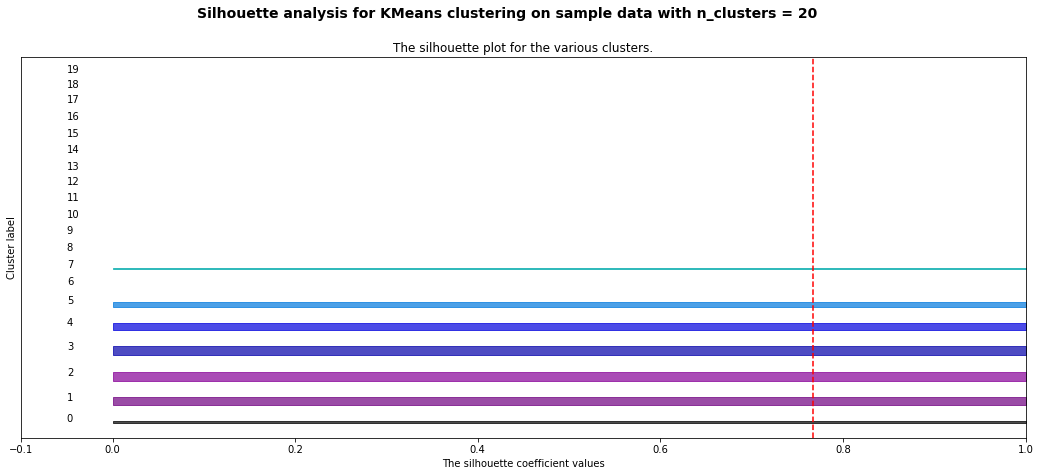

In [57]:
# Evaluate the different models using the Silhoutte Score

silhoutte_score_validation(model = KMeans, transformer = TfidfVectorizer(lowercase = False), array = X)

###### In order to prevent a mislabel of the data, it is necessary to pick up a number of clusters that seems to high for this particular problem. Therefore, I'd stay with 4 clusters to compare silhoutte scores. However, this model won't be in consideration because of that. 

In [58]:
# Creation of the pipeline

pipe_preprocessing = pipeline(est1 = TfidfVectorizer(lowercase = False))

pipe_predictor = pipeline2(est2 = KMeans(n_clusters = 3))

pipe_kmeans_tf = pipeline3(pipeline = pipe_preprocessing, pipeline2 = pipe_predictor)

# Fit the final pipeline

pipe_kmeans_tf.fit(X)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('est1', TfidfVectorizer(lowercase=False)),
                                 ('pca', TruncatedSVD())])),
                ('predictor',
                 Pipeline(steps=[('est2', KMeans(n_clusters=3))]))])

In [59]:
# Transform the data for the preprocessor

preprocessed_data = pipe_kmeans_tf['preprocessor'].transform(X)

# Labels Predictions

predicted_labels = pipe_kmeans_tf['predictor']['est2'].labels_

# Identify the centroids

clusters = pipe_kmeans_tf['predictor']['est2'].cluster_centers_

In [60]:
# Get the coordenates for the keyword ("Aspiring Human Resources")

keywords_preprocessed = pipe_kmeans_tf['preprocessor'].transform(["aspiring human resources"])

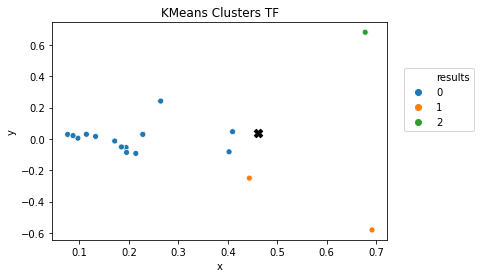

In [61]:
# Save the results in a data frame

results = results_df(preprocessing = preprocessed_data, predictions = predicted_labels)

# Plot the scatter plot with the centroids

plot_scatter(df = results, keyword = keywords_preprocessed, title = 'KMeans Clusters TF')

In [62]:
# Calculation of the Calinski Harabasz Score

metric_score(array1 = preprocessed_data, array2 = predicted_labels)

The Calinski Harabasz Score is 149.4618032684527
The Davies Bouldin score is 0.42724893066823894


In [63]:
# See the fit of each person based on the euclidean distance

results_kmean_tf = euclidean_distance(df = results, keyword = keywords_preprocessed).head(number_candidates)

In [64]:
results_kmean_tf

,x,y,results,id,job_title,location,connection,distance,fit
15,0.409560,0.046084,0,29,aspiring human resources management student se...,houston texas,500,0.052710,0.948655
13,0.409560,0.046084,0,27,aspiring human resources management student se...,houston texas,500,0.052710,0.948655
35,0.402412,-0.082170,0,73,aspiring human resources manager seeking inter...,houston texas,7,0.133555,0.874979
11,0.228031,0.029008,0,24,aspiring human resources specialist,new york new york,1,0.233702,0.791597
2,0.228031,0.029008,0,6,aspiring human resources specialist,new york new york,1,0.233702,0.791597
19,0.228031,0.029008,0,36,aspiring human resources specialist,new york new york,1,0.233702,0.791597
31,0.228031,0.029008,0,60,aspiring human resources specialist,new york new york,1,0.233702,0.791597


### Gaussian Mixture

#### Vectorization

For n_clusters = 2 The average silhouette_score is : 0.342735573410393
For n_clusters = 3 The average silhouette_score is : 0.3189632973938373
For n_clusters = 4 The average silhouette_score is : 0.4725315689755202
For n_clusters = 5 The average silhouette_score is : 0.5403738429086107
For n_clusters = 6 The average silhouette_score is : 0.5194515039811105
For n_clusters = 7 The average silhouette_score is : 0.6406723579708925
For n_clusters = 8 The average silhouette_score is : 0.6502141721676641
For n_clusters = 9 The average silhouette_score is : 0.6315014728716262
For n_clusters = 10 The average silhouette_score is : 0.6891587322913573
For n_clusters = 11 The average silhouette_score is : 0.7025867335477662
For n_clusters = 12 The average silhouette_score is : 0.7427307357981152
For n_clusters = 13 The average silhouette_score is : 0.7312151413656414
For n_clusters = 14 The average silhouette_score is : 0.7257914962067571
For n_clusters = 15 The average silhouette_score is : 0.7553

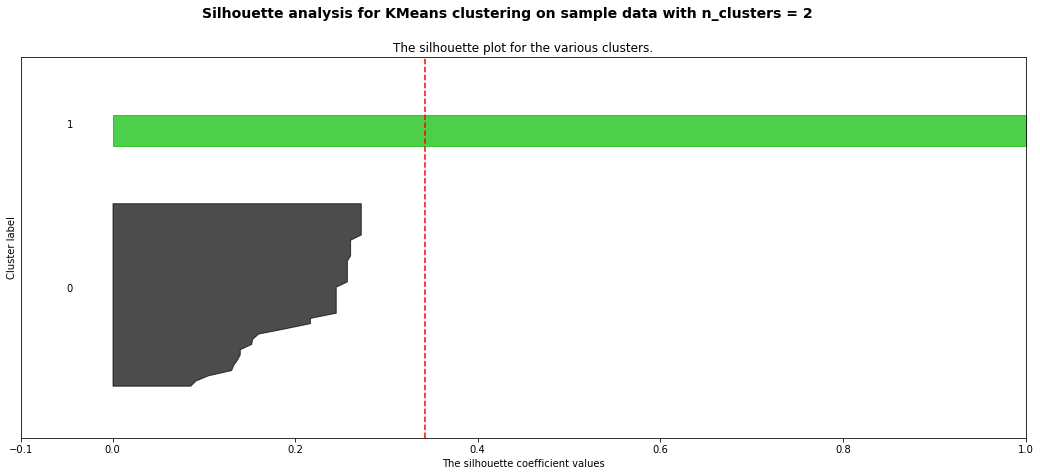

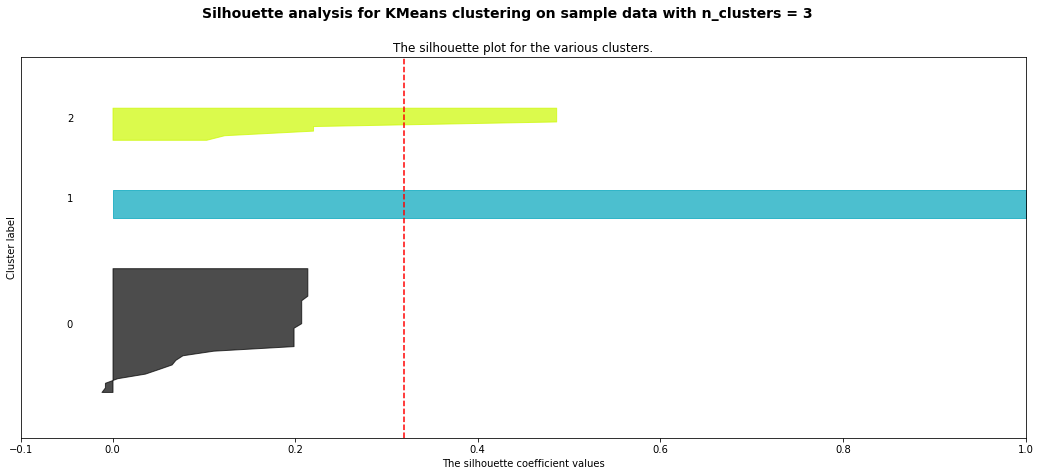

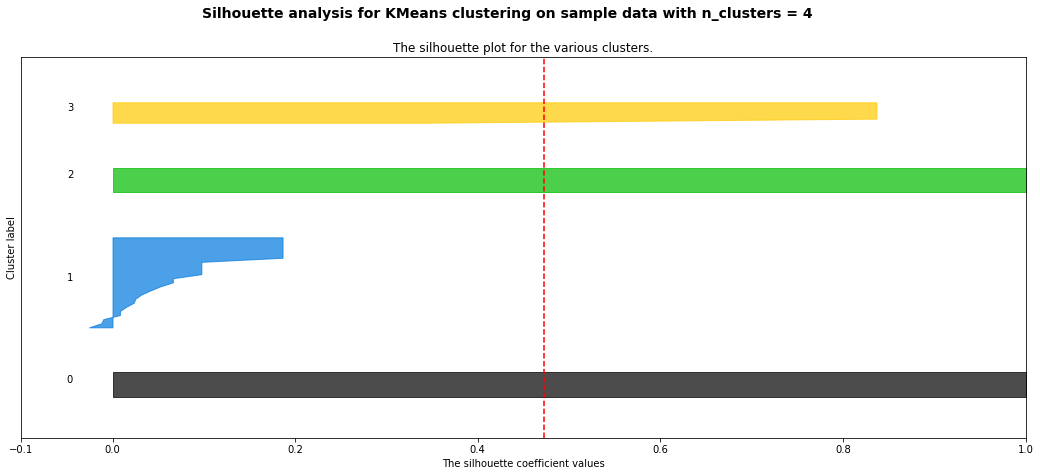

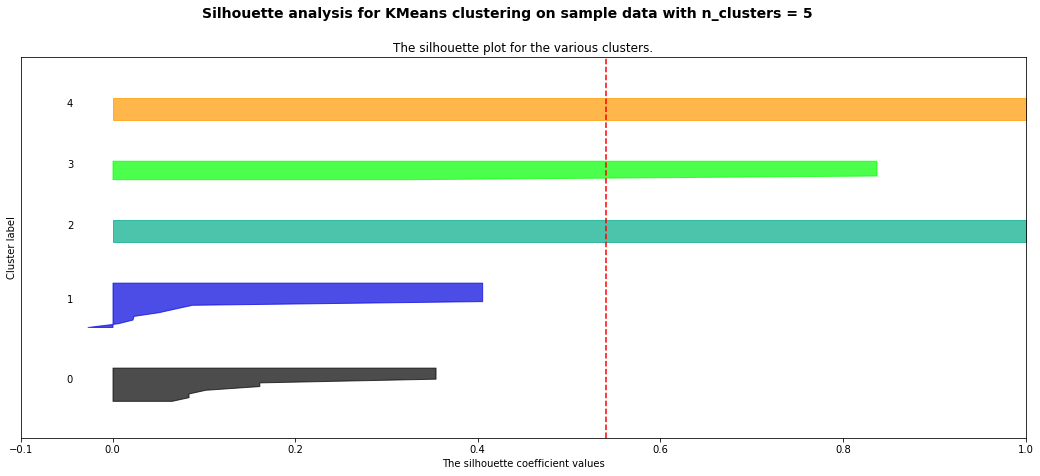

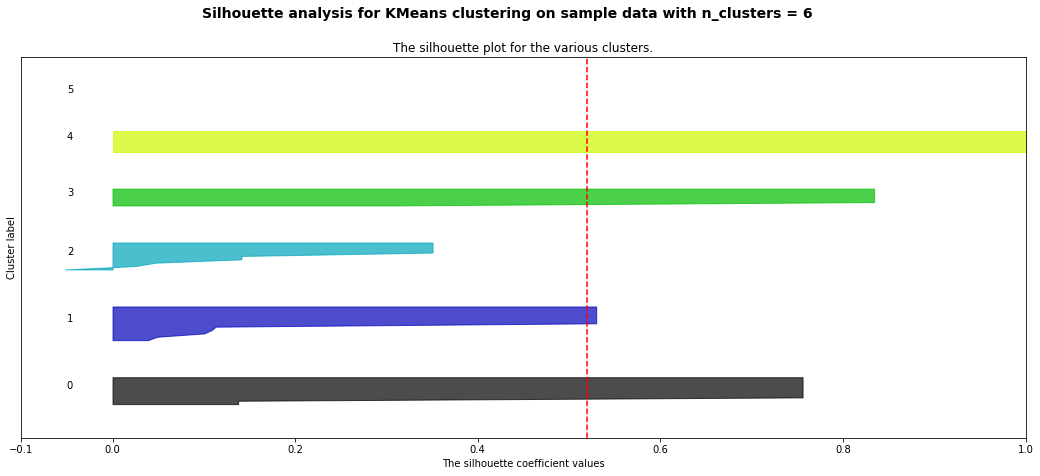

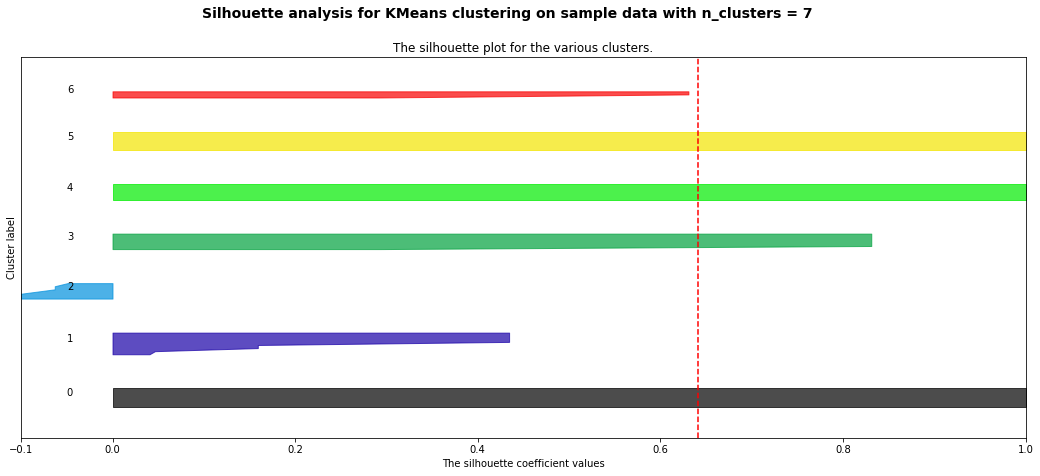

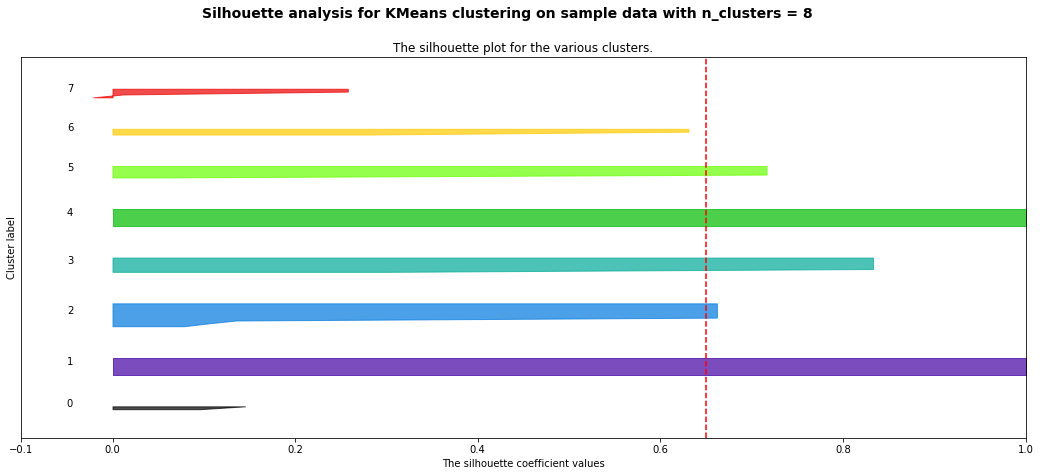

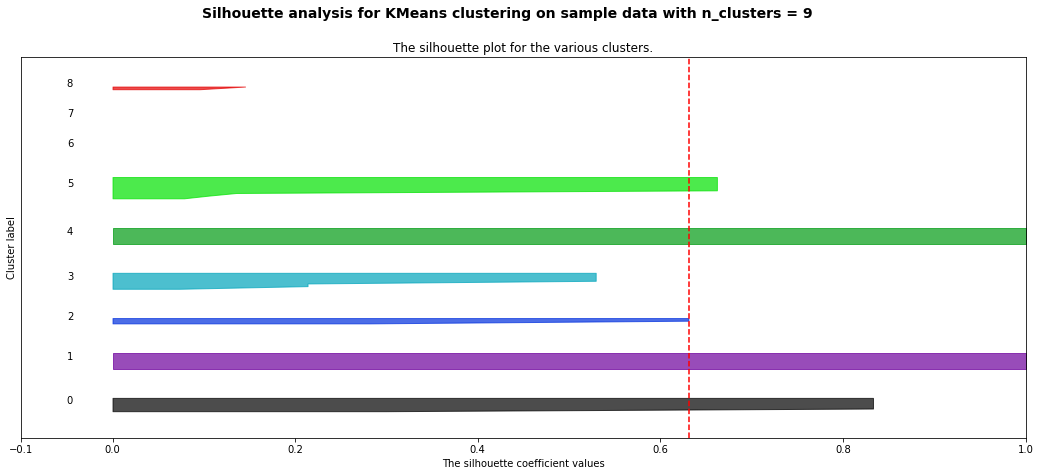

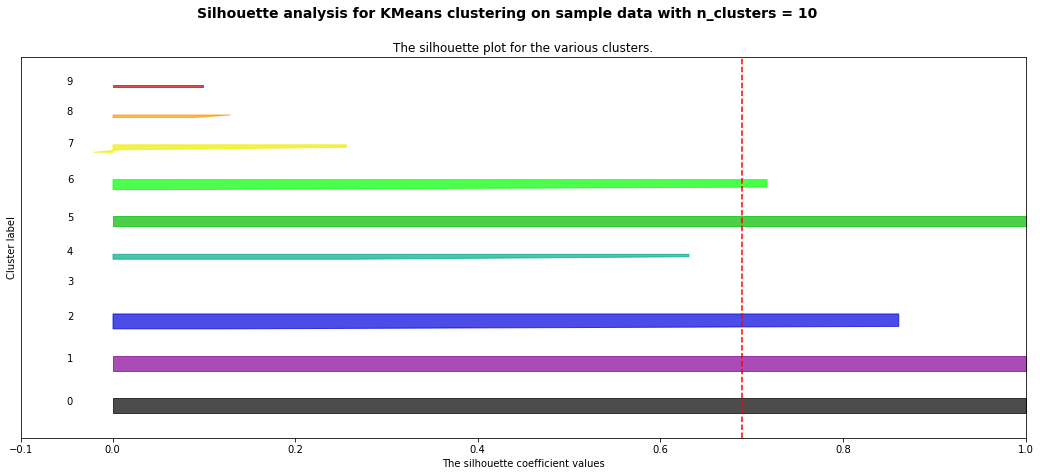

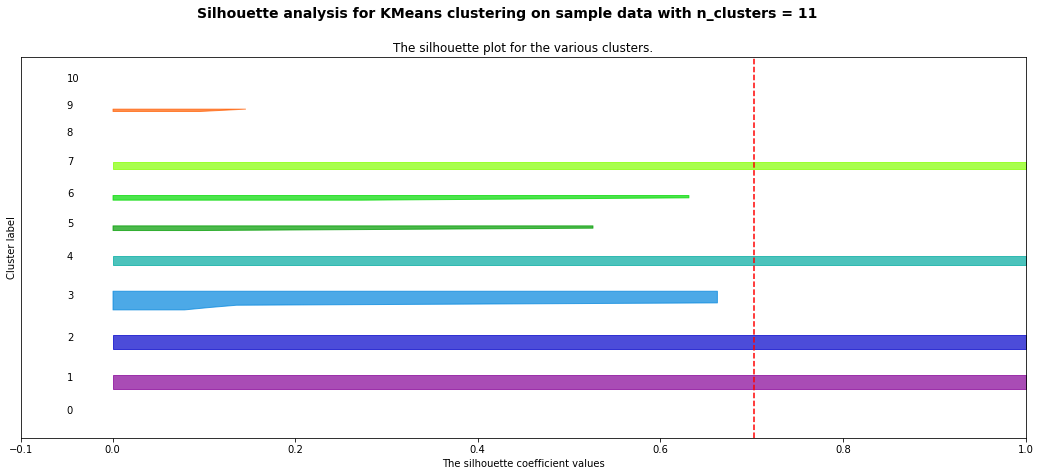

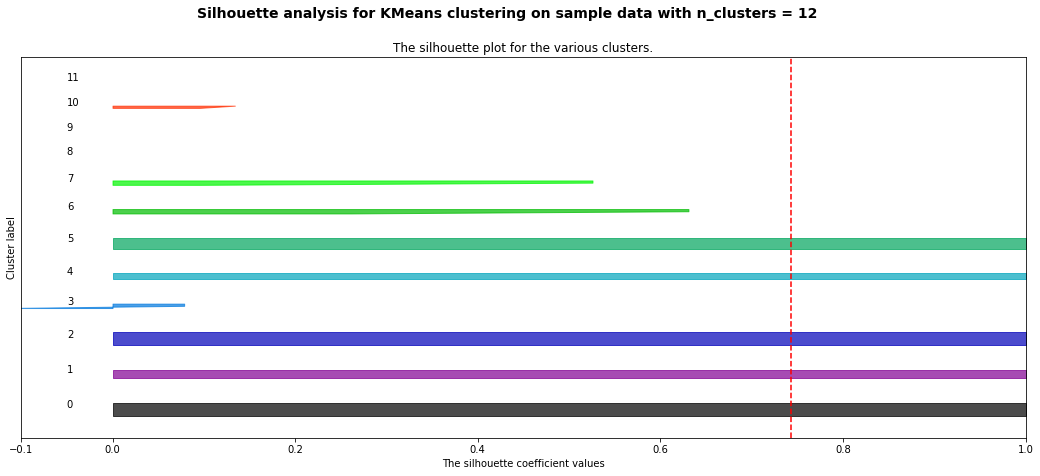

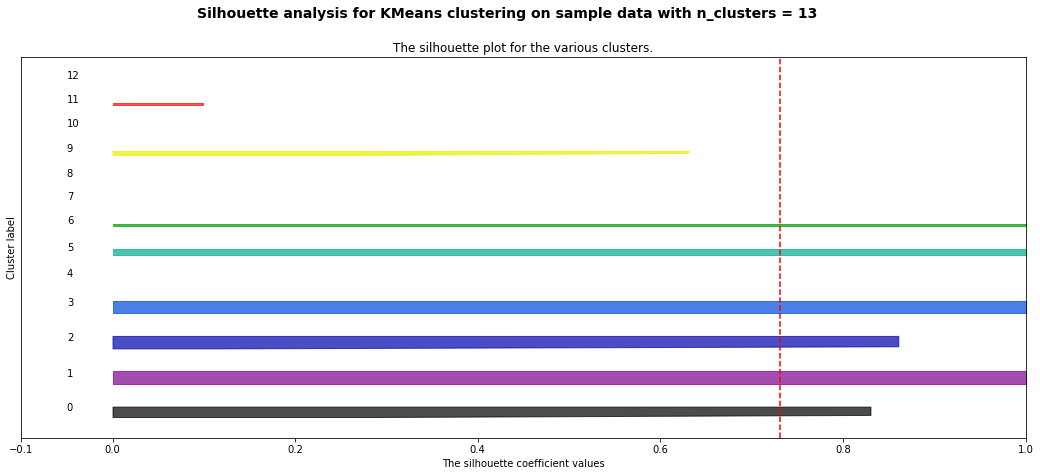

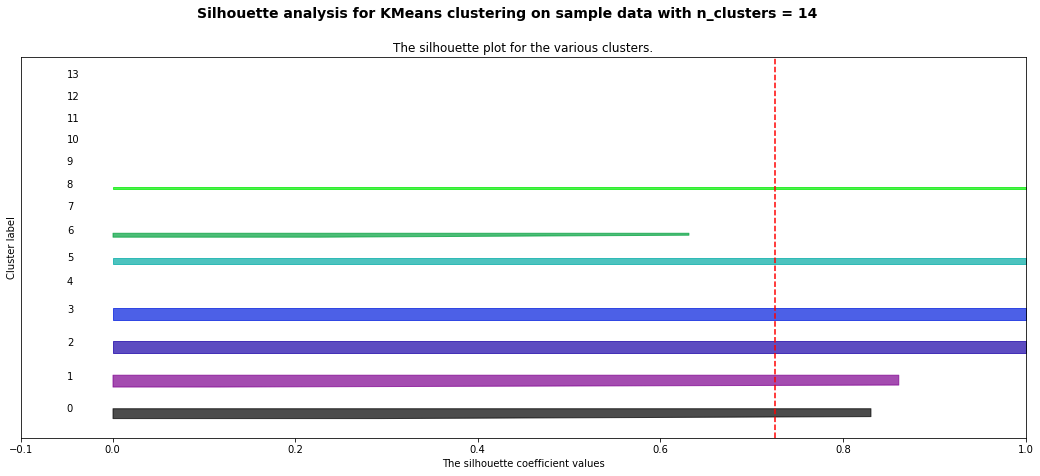

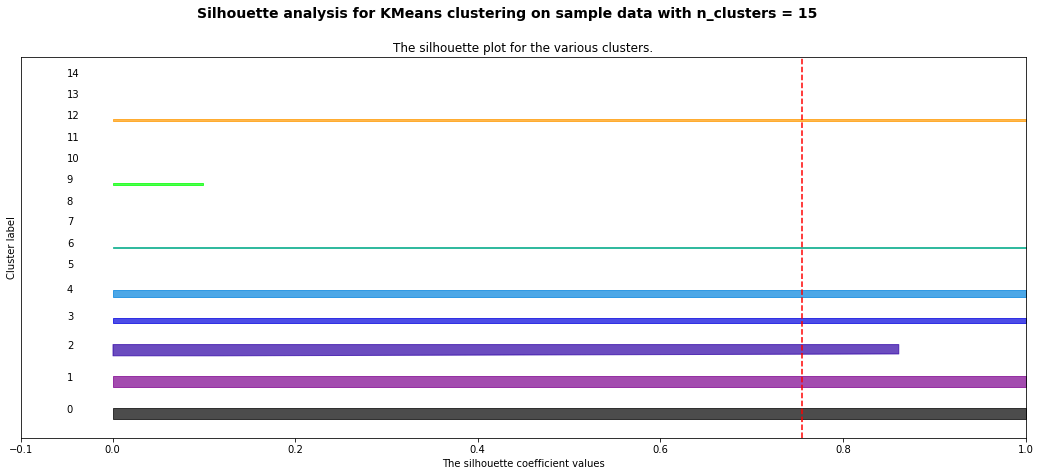

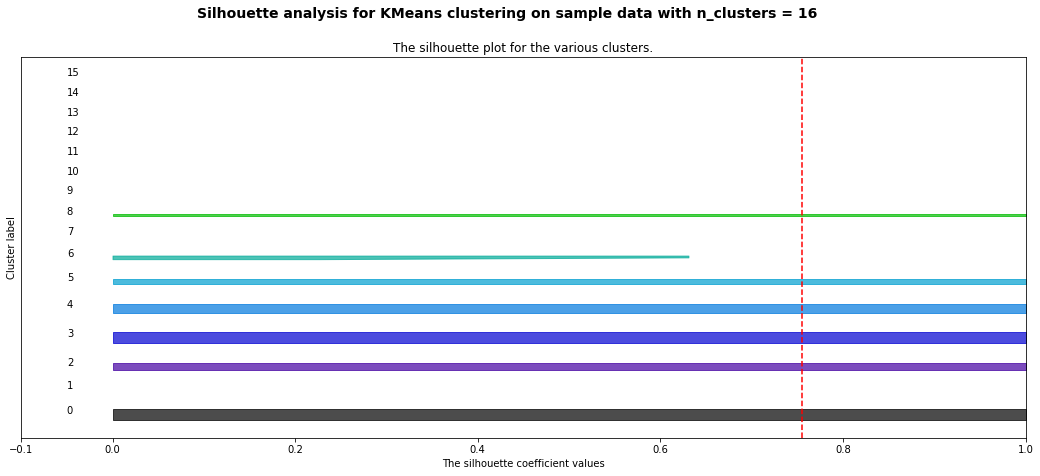

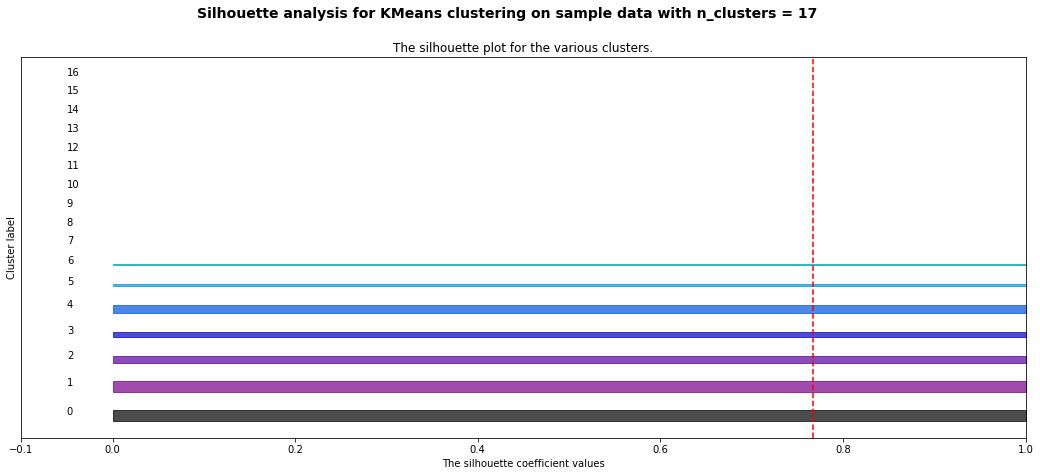

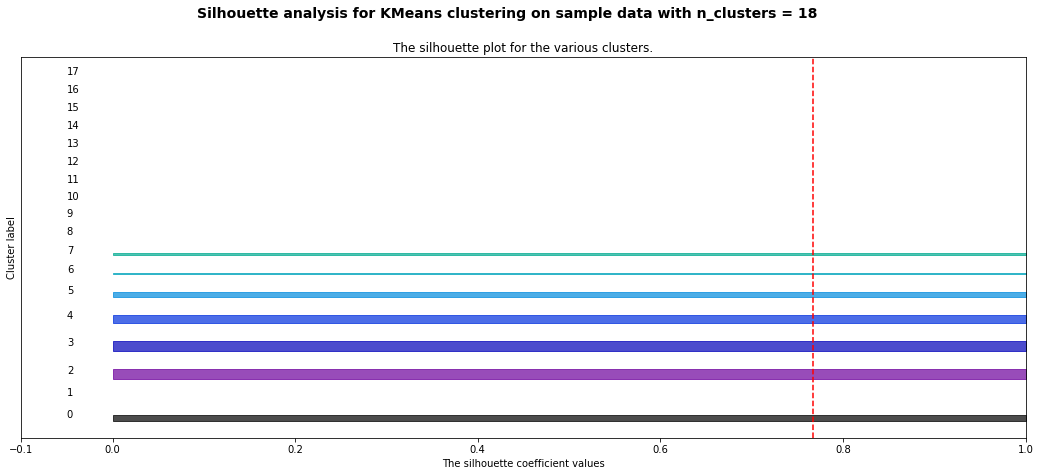

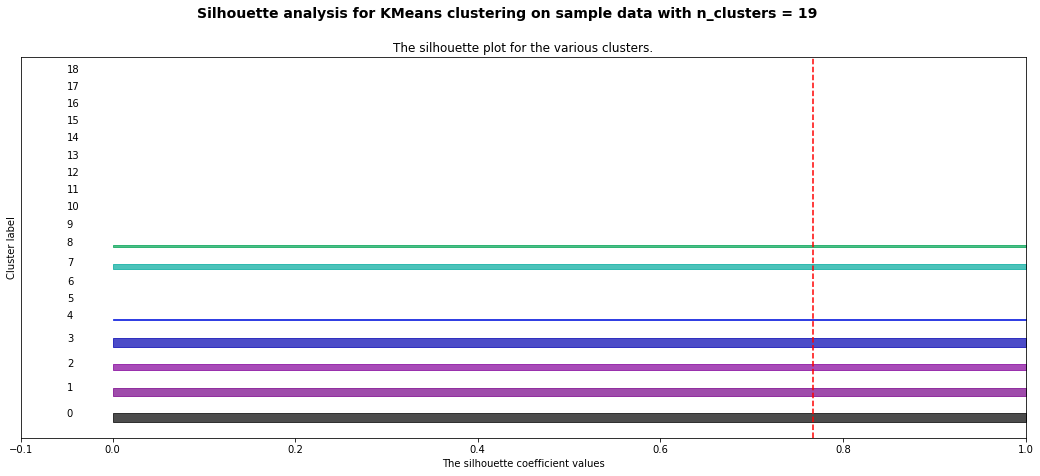

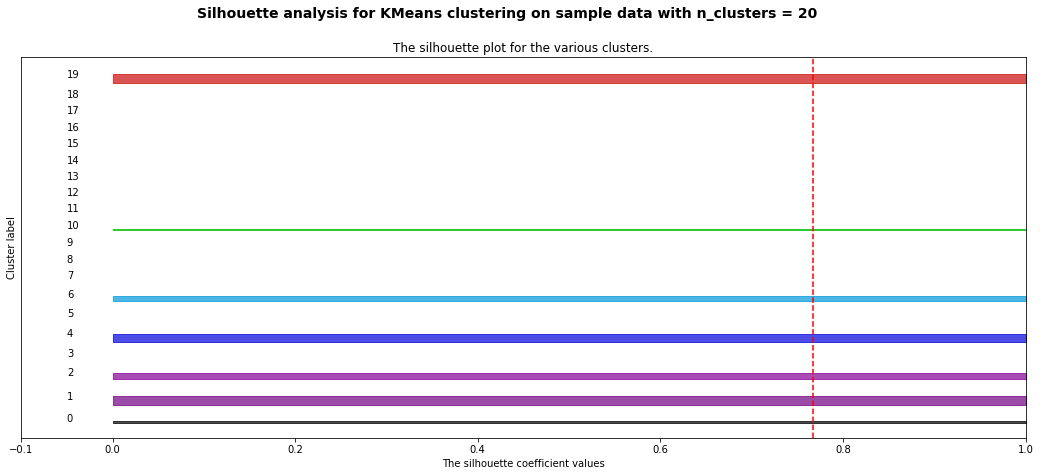

In [65]:
# Evaluate the different models using the Silhoutte Score

silhoutte_score_validation(model = GaussianMixture, transformer = CountVectorizer(lowercase = False), array = X)

###### The best number of components after several repetitions would be between 3 or 2. I'd select 3 to better compare the other metric scores. However 2 sows a model that may prevent the mislabel of the data. This model would be in consideration for final selection, but not as strong as the KMeans models with Count Vectorization.

In [66]:
# Creation of the pipeline for Gaussian Mixture

pipe_preprocessing = pipeline(est1 = CountVectorizer(lowercase = False))

pipe_predictor = pipeline2(est2 = GaussianMixture(n_components = 3))

pipe_gaussian_cv = pipeline3(pipeline = pipe_preprocessing, pipeline2 = pipe_predictor)

# Fit the final pipeline

pipe_gaussian_cv.fit(X)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('est1', CountVectorizer(lowercase=False)),
                                 ('pca', TruncatedSVD())])),
                ('predictor',
                 Pipeline(steps=[('est2', GaussianMixture(n_components=3))]))])

In [67]:
# Transform the data for the preprocessor

preprocessed_data = pipe_gaussian_cv['preprocessor'].transform(X)

# Labels Predictions

predicted_labels = pipe_gaussian_cv.predict(X)

In [68]:
# Get the coordenates for the keyword ("Aspiring Human Resources")

keywords_preprocessed = pipe_gaussian_cv['preprocessor'].transform(["aspiring human resources"])

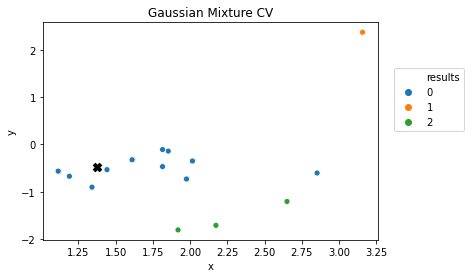

In [69]:
# Save the results in a data frame

results = results_df(preprocessing = preprocessed_data, predictions = predicted_labels)

# Plot the scatter plot with the centroids

plot_scatter(df = results, keyword = keywords_preprocessed, title = 'Gaussian Mixture CV')

In [70]:
# Calculation of the Calinski Harabasz Score

metric_score(array1 = preprocessed_data, array2 = predicted_labels)

The Calinski Harabasz Score is 254.46168400452734
The Davies Bouldin score is 0.39142322776119975


In [71]:
# See the fit of each person based on the euclidean distance

results_gaussian_cv = euclidean_distance(df = results, keyword = keywords_preprocessed).head(number_candidates)

In [72]:
results_gaussian_cv

,x,y,results,id,job_title,location,connection,distance,fit
38,1.442264,-0.534608,0,79,liberal arts major aspiring human resources an...,baton rouge louisiana,7,0.093397,0.910832
36,1.189929,-0.672781,0,75,nortia staffing seeking human resources payrol...,san jose california,500,0.270239,0.763197
16,1.118540,-0.572492,0,30,seeking human resources opportunities,chicago illinois,390,0.272256,0.761660
14,1.118540,-0.572492,0,28,seeking human resources opportunities,chicago illinois,390,0.272256,0.761660
41,1.114719,-0.564791,0,99,seeking human resources position,las vegas nevada,48,0.273135,0.760990
40,1.610725,-0.324883,0,97,aspiring human resources professional,kokomo indiana,71,0.280987,0.755038
34,1.614871,-0.318627,0,72,business management major aspiring human resou...,monroe louisiana,5,0.287826,0.749892


#### TF-IDF

For n_clusters = 2 The average silhouette_score is : 0.19629488789441082
For n_clusters = 3 The average silhouette_score is : 0.27187071135866203
For n_clusters = 4 The average silhouette_score is : 0.37259200744723925
For n_clusters = 5 The average silhouette_score is : 0.41398890902377783
For n_clusters = 6 The average silhouette_score is : 0.5658726127510463
For n_clusters = 7 The average silhouette_score is : 0.6936339624425623
For n_clusters = 8 The average silhouette_score is : 0.7155310612138992
For n_clusters = 9 The average silhouette_score is : 0.7246122396117061
For n_clusters = 10 The average silhouette_score is : 0.723791339638043
For n_clusters = 11 The average silhouette_score is : 0.7363730252092696
For n_clusters = 12 The average silhouette_score is : 0.7320679818557292
For n_clusters = 13 The average silhouette_score is : 0.7541981661244412
For n_clusters = 14 The average silhouette_score is : 0.7635357621867809
For n_clusters = 15 The average silhouette_score is : 0.

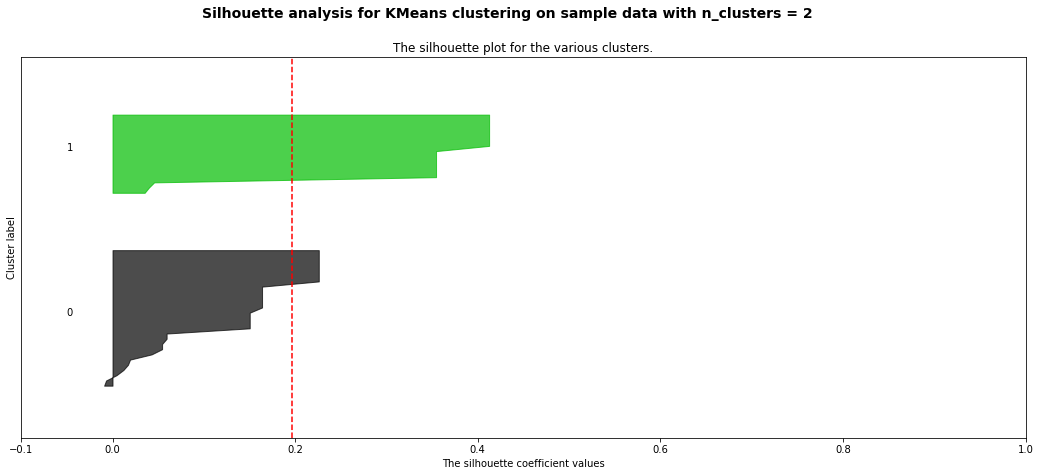

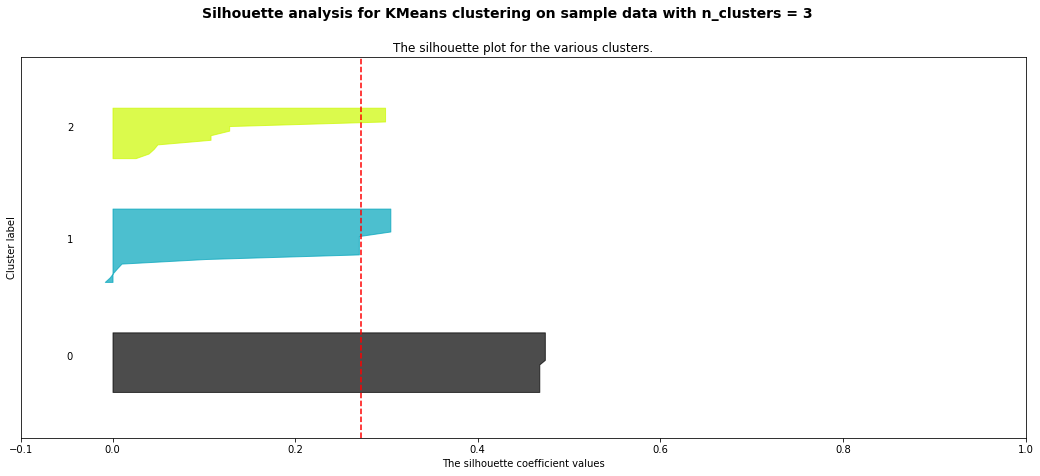

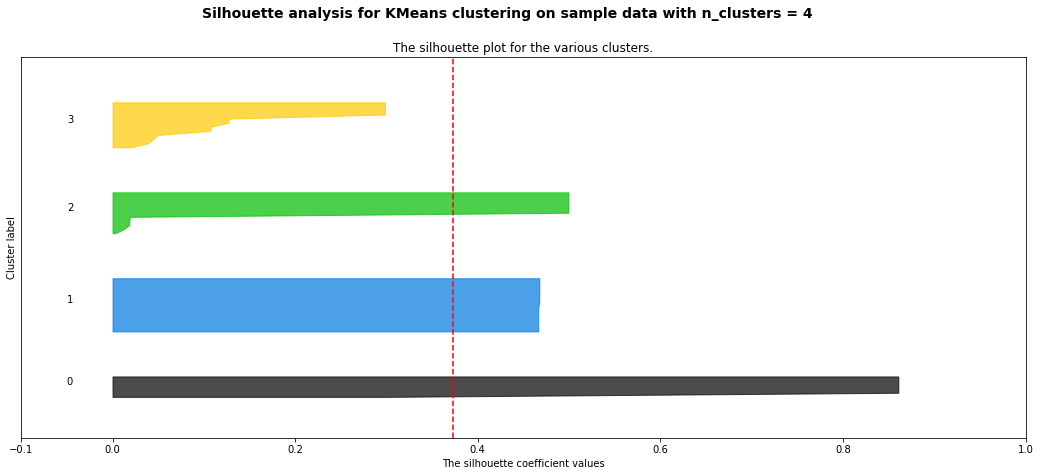

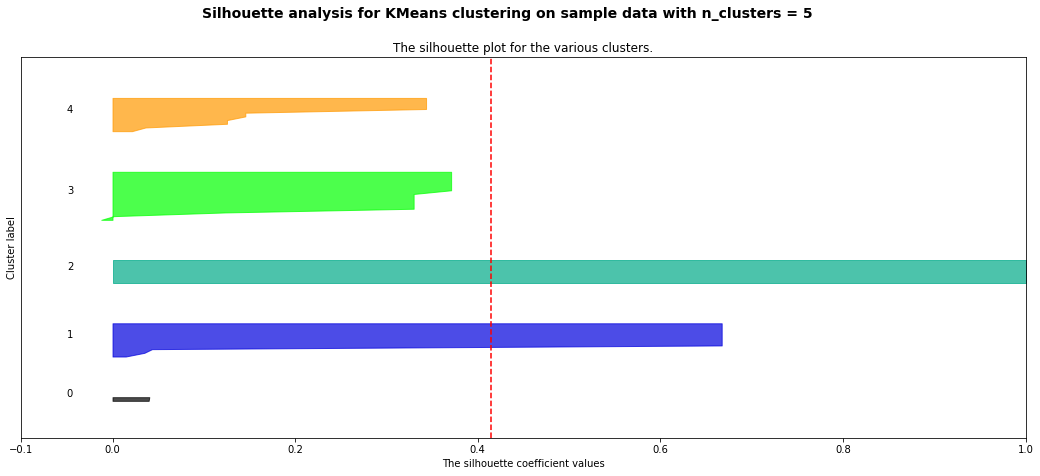

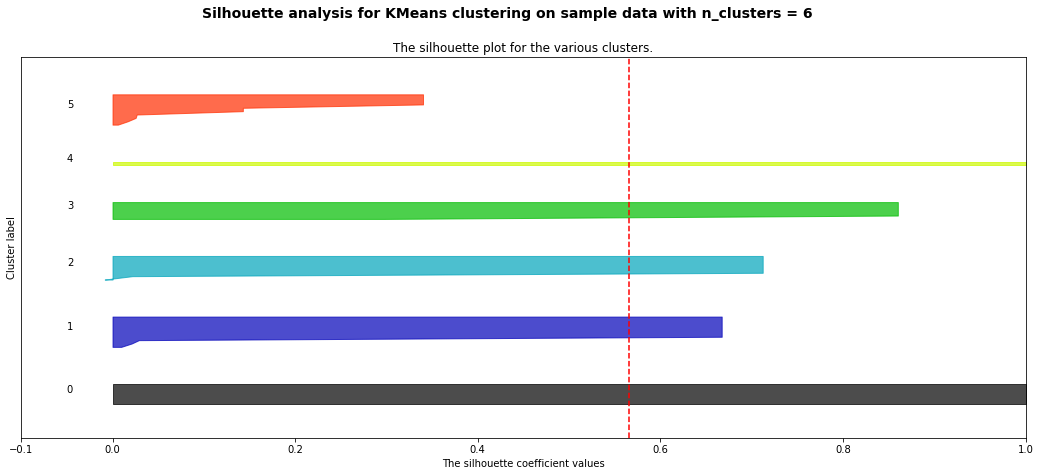

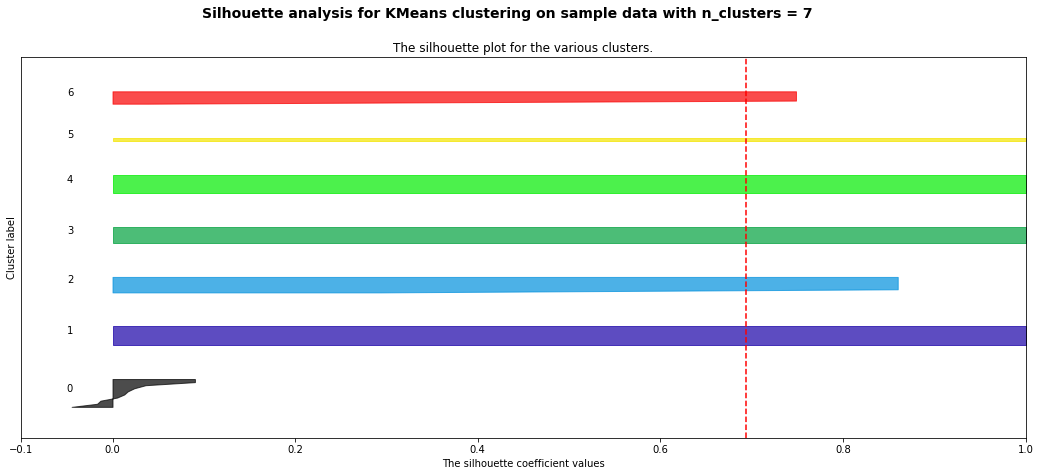

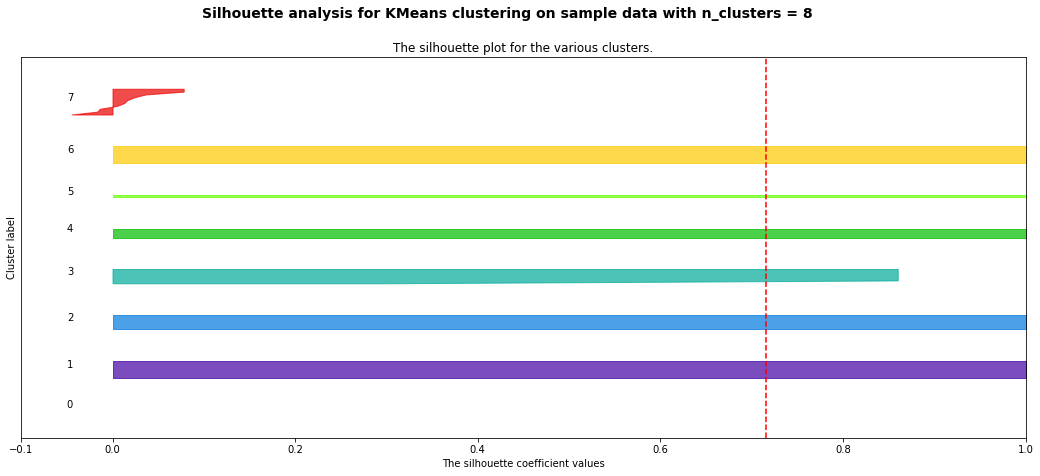

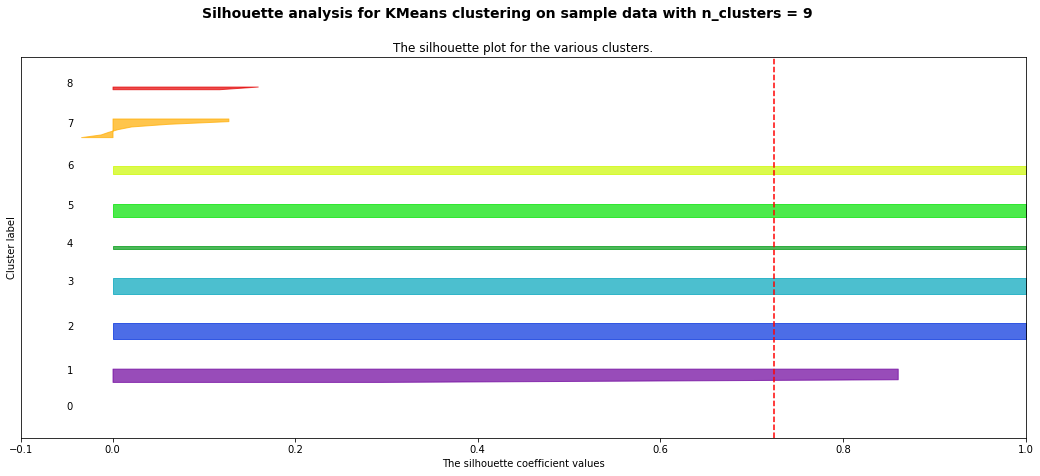

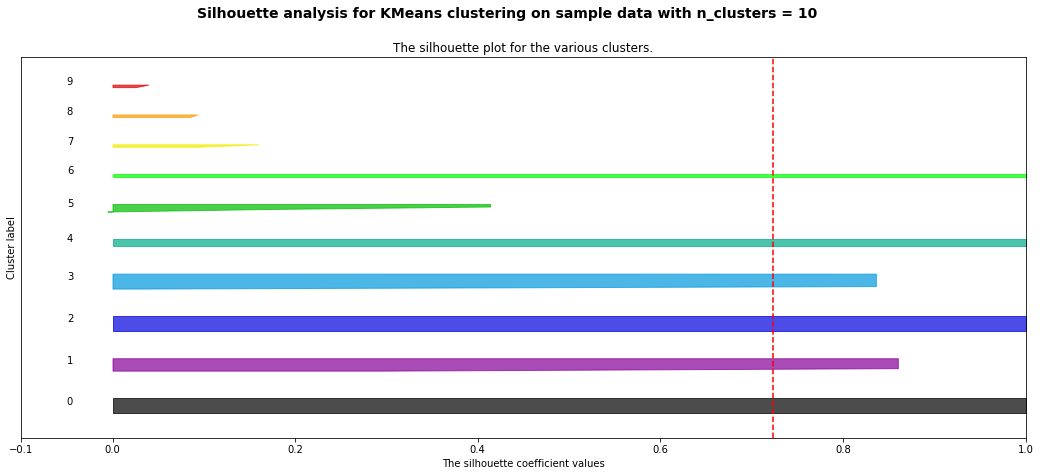

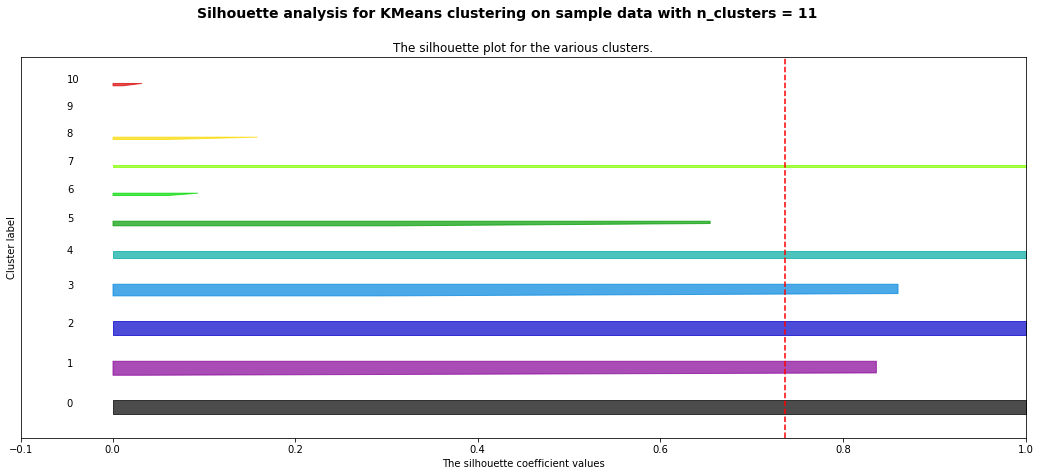

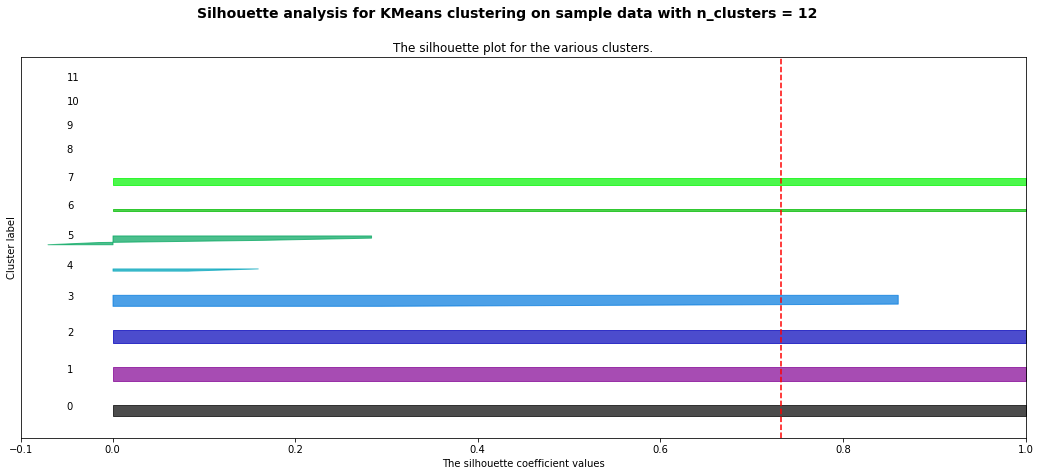

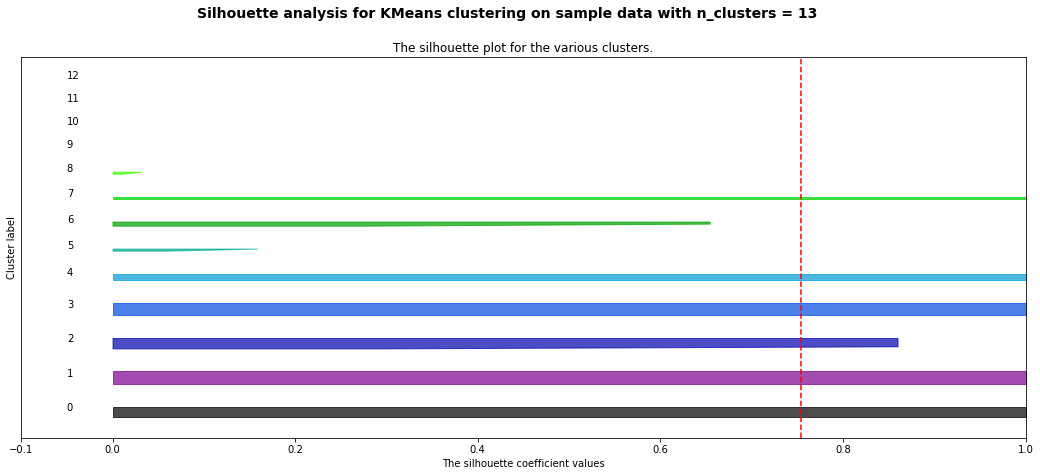

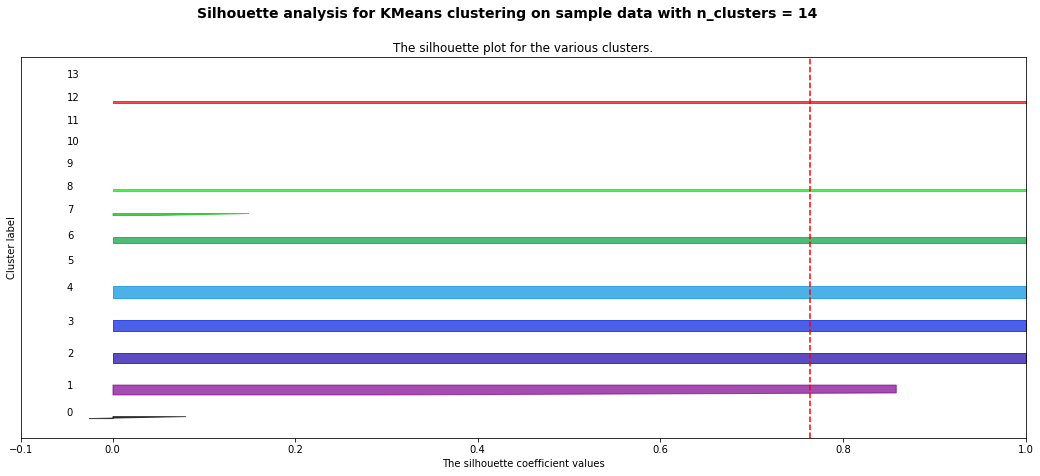

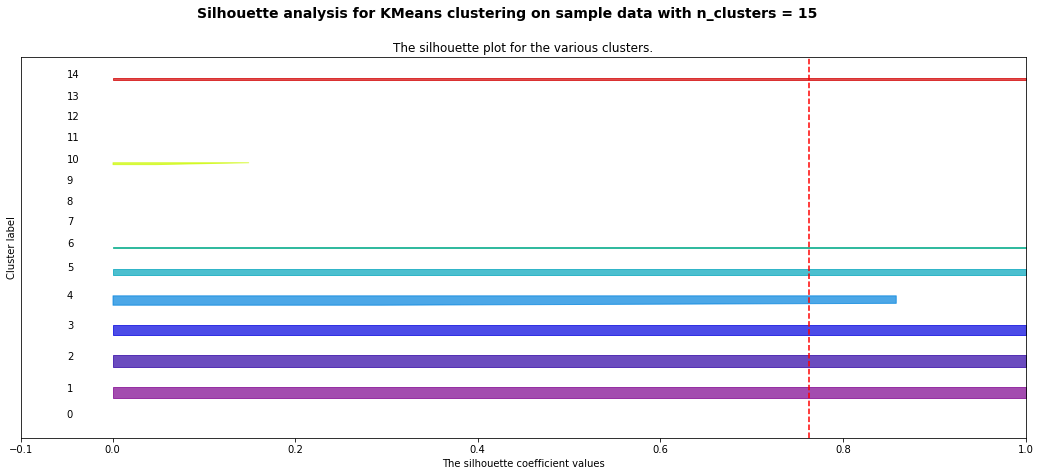

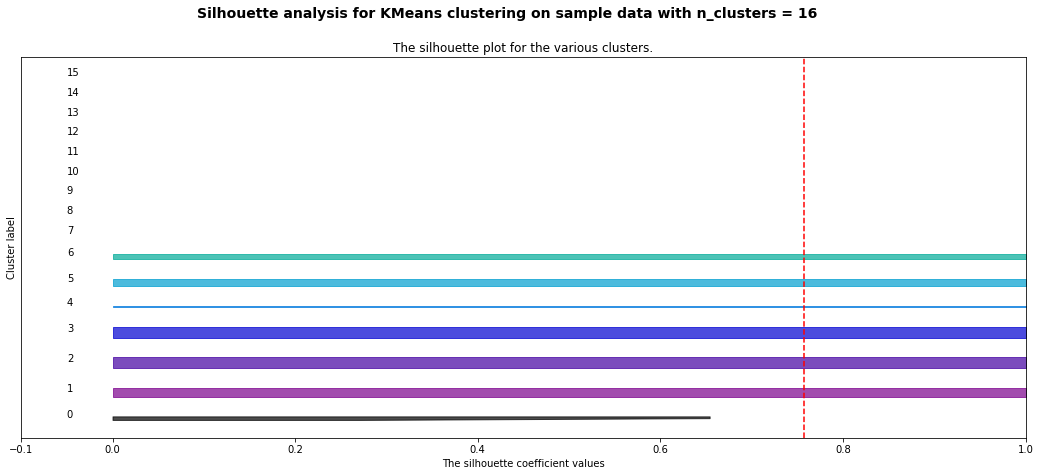

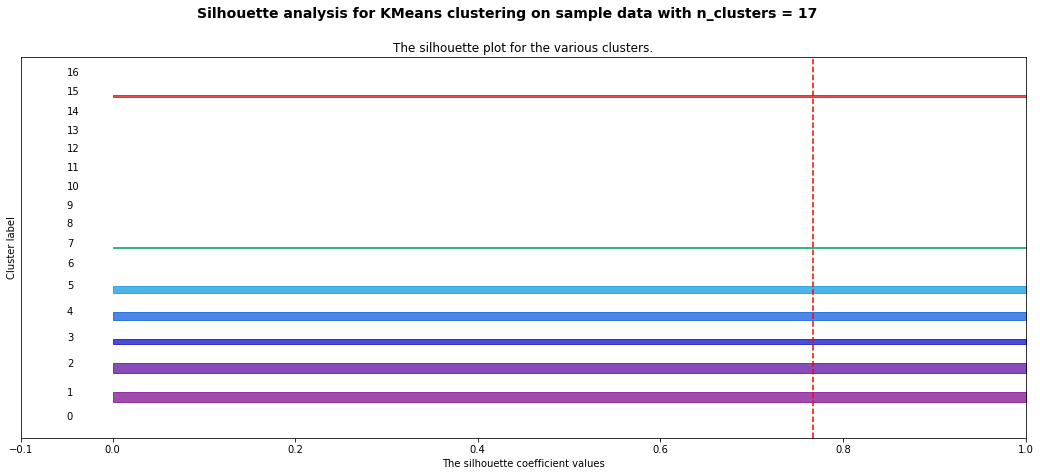

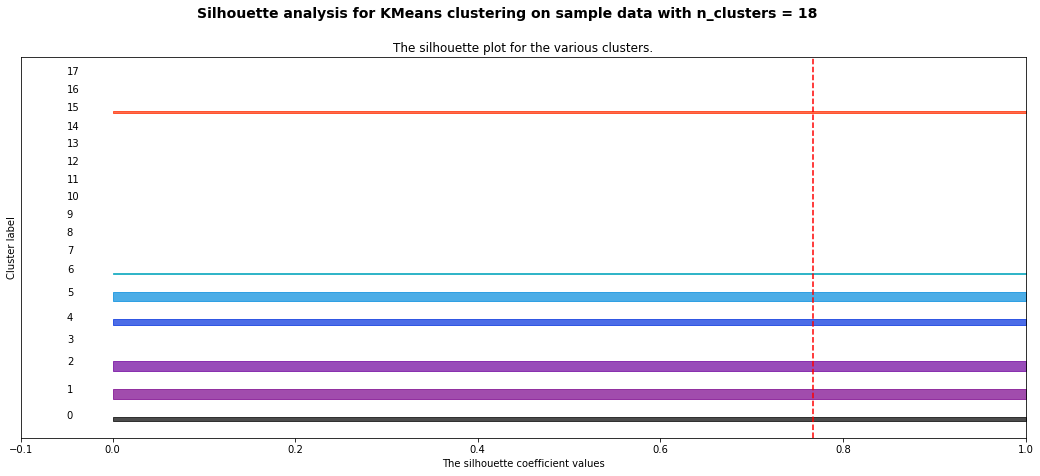

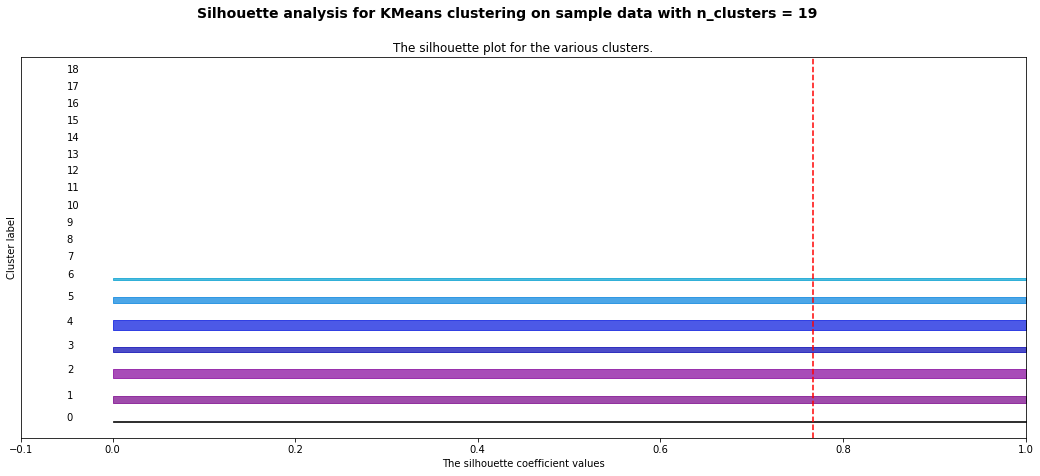

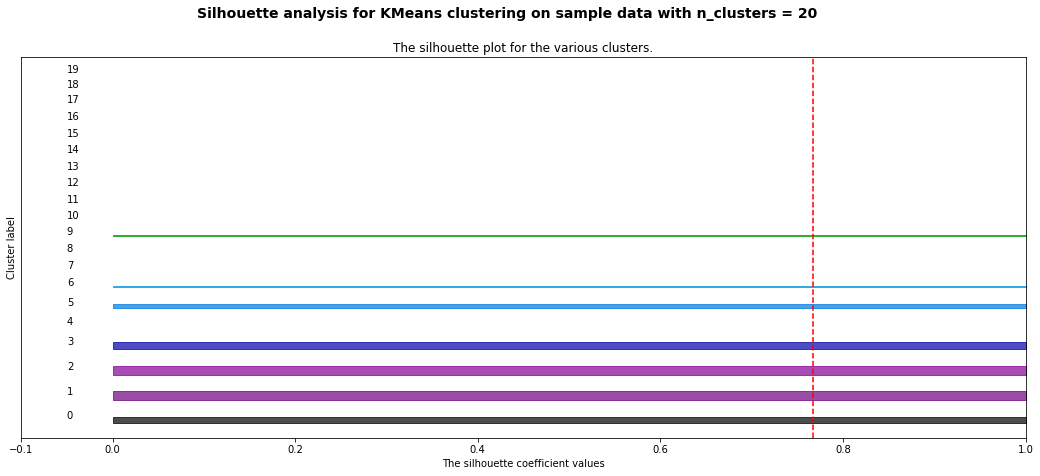

In [73]:
# Evaluate the different models using the Silhoutte Score

silhoutte_score_validation(model = GaussianMixture, transformer = TfidfVectorizer(lowercase = False), array = X)

###### I would be using 3 as the number of components as well to make better comparison. This because the data presents inconsistencies and sometimes it mislabel the data with 4 components.

In [74]:
# Creation of the pipeline

pipe_preprocessing = pipeline(est1 = TfidfVectorizer(lowercase = False))

pipe_predictor = pipeline2(est2 = GaussianMixture(n_components = 3))

pipe_gaussian_tf = pipeline3(pipeline = pipe_preprocessing, pipeline2 = pipe_predictor)

# Fit the final pipeline

pipe_gaussian_tf.fit(X)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('est1', TfidfVectorizer(lowercase=False)),
                                 ('pca', TruncatedSVD())])),
                ('predictor',
                 Pipeline(steps=[('est2', GaussianMixture(n_components=3))]))])

In [75]:
# Transform the data for the preprocessor

preprocessed_data = pipe_gaussian_tf['preprocessor'].transform(X)

# Labels Predictions

predicted_labels = pipe_gaussian_tf.predict(X)

In [76]:
# Get the coordenates for the keyword ("Aspiring Human Resources")

keywords_preprocessed = pipe_gaussian_tf['preprocessor'].transform(["aspiring human resources"])

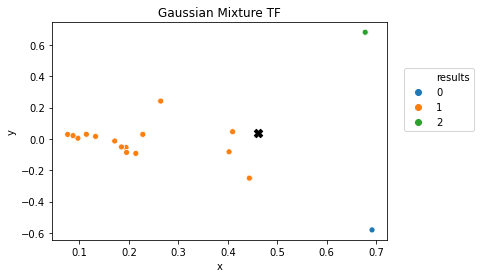

In [77]:
# Save the results in a data frame

results = results_df(preprocessing = preprocessed_data, predictions = predicted_labels)

# Plot the scatter plot with the centroids

plot_scatter(df = results, keyword = keywords_preprocessed, title = 'Gaussian Mixture TF')

In [78]:
# Calculation of the Calinski Harabasz Score

metric_score(array1 = preprocessed_data, array2 = predicted_labels)

The Calinski Harabasz Score is 134.43131909014417
The Davies Bouldin score is 0.23385048374407721


In [79]:
# See the fit of each person based on the euclidean distance

results_gaussian_tf = euclidean_distance(df = results, keyword = keywords_preprocessed).head(number_candidates)

In [80]:
results_gaussian_tf

,x,y,results,id,job_title,location,connection,distance,fit
15,0.409560,0.046085,1,29,aspiring human resources management student se...,houston texas,500,0.052710,0.948655
13,0.409560,0.046085,1,27,aspiring human resources management student se...,houston texas,500,0.052710,0.948655
35,0.402412,-0.082171,1,73,aspiring human resources manager seeking inter...,houston texas,7,0.133555,0.874980
11,0.228031,0.029008,1,24,aspiring human resources specialist,new york new york,1,0.233702,0.791597
2,0.228031,0.029008,1,6,aspiring human resources specialist,new york new york,1,0.233702,0.791597
19,0.228031,0.029008,1,36,aspiring human resources specialist,new york new york,1,0.233702,0.791597
31,0.228031,0.029008,1,60,aspiring human resources specialist,new york new york,1,0.233702,0.791597


### Affinity Propagation

#### Count Vectorization

In [81]:
# Creation of the pipeline for Gaussian Mixture

pipe_preprocessing = pipeline(est1 = CountVectorizer(lowercase = False))

pipe_predictor = pipeline2(est2 = AffinityPropagation(damping = 0.5))

pipe_affinity_cv = pipeline3(pipeline = pipe_preprocessing, pipeline2 = pipe_predictor)

# Fit the final pipeline

pipe_affinity_cv.fit(X)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('est1', CountVectorizer(lowercase=False)),
                                 ('pca', TruncatedSVD())])),
                ('predictor',
                 Pipeline(steps=[('est2', AffinityPropagation())]))])

In [82]:
# Transform the data for the preprocessor

preprocessed_data = pipe_affinity_cv['preprocessor'].transform(X)

# Labels Predictions

predicted_labels = pipe_affinity_cv.predict(X)

In [83]:
# Get the coordenates for the keyword ("Aspiring Human Resources")

keywords_preprocessed = pipe_affinity_cv['preprocessor'].transform(["aspiring human resources"])

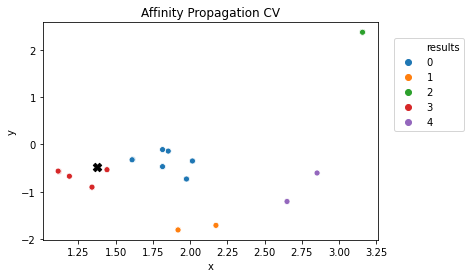

In [84]:
# Save the results in a data frame

results = results_df(preprocessing = preprocessed_data, predictions = predicted_labels)

# Plot the scatter plot with the centroids

plot_scatter(df = results, keyword = keywords_preprocessed, title = 'Affinity Propagation CV')

In [85]:
# Calculation of the Calinski Harabasz Score

metric_score(array1 = preprocessed_data, array2 = predicted_labels)

The Calinski Harabasz Score is 466.57914589611295
The Davies Bouldin score is 0.4433297297635102


In [86]:
# See the fit of each person based on the euclidean distance

results_affinity_cv = euclidean_distance(df = results, keyword = keywords_preprocessed).head(number_candidates)

In [87]:
results_affinity_cv

,x,y,results,id,job_title,location,connection,distance,fit
38,1.442264,-0.534608,3,79,liberal arts major aspiring human resources an...,baton rouge louisiana,7,0.093397,0.910832
36,1.189929,-0.672782,3,75,nortia staffing seeking human resources payrol...,san jose california,500,0.270239,0.763197
16,1.118540,-0.572492,3,30,seeking human resources opportunities,chicago illinois,390,0.272256,0.761660
14,1.118540,-0.572492,3,28,seeking human resources opportunities,chicago illinois,390,0.272256,0.761660
41,1.114719,-0.564789,3,99,seeking human resources position,las vegas nevada,48,0.273134,0.760991
40,1.610725,-0.324884,0,97,aspiring human resources professional,kokomo indiana,71,0.280987,0.755038
34,1.614871,-0.318628,0,72,business management major aspiring human resou...,monroe louisiana,5,0.287826,0.749892


#### TF-IDF

In [88]:
# Creation of the pipeline for Gaussian Mixture

pipe_preprocessing = pipeline(est1 = TfidfVectorizer(lowercase = False))

pipe_predictor = pipeline2(est2 = AffinityPropagation(damping = 0.5))

pipe_affinity_tf = pipeline3(pipeline = pipe_preprocessing, pipeline2 = pipe_predictor)

# Fit the final pipeline

pipe_affinity_tf.fit(X)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('est1', TfidfVectorizer(lowercase=False)),
                                 ('pca', TruncatedSVD())])),
                ('predictor',
                 Pipeline(steps=[('est2', AffinityPropagation())]))])

In [89]:
# Transform the data for the preprocessor

preprocessed_data = pipe_affinity_tf['preprocessor'].transform(X)

# Labels Predictions

predicted_labels = pipe_affinity_tf.predict(X)

In [90]:
# Get the coordenates for the keyword ("Aspiring Human Resources")

keywords_preprocessed = pipe_affinity_tf['preprocessor'].transform(["aspiring human resources"])

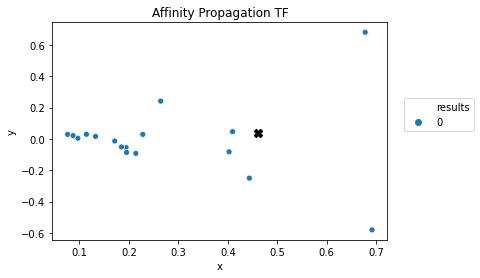

In [91]:
# Save the results in a data frame

results = results_df(preprocessing = preprocessed_data, predictions = predicted_labels)

# Plot the scatter plot with the centroids

plot_scatter(df = results, keyword = keywords_preprocessed, title = 'Affinity Propagation TF')

In [92]:
# See the fit of each person based on the euclidean distance

results_affinity_tf = euclidean_distance(df = results, keyword = keywords_preprocessed).head(number_candidates)

In [93]:
results_affinity_tf

,x,y,results,id,job_title,location,connection,distance,fit
15,0.409560,0.046083,0,29,aspiring human resources management student se...,houston texas,500,0.052709,0.948656
13,0.409560,0.046083,0,27,aspiring human resources management student se...,houston texas,500,0.052709,0.948656
35,0.402412,-0.082171,0,73,aspiring human resources manager seeking inter...,houston texas,7,0.133558,0.874976
11,0.228031,0.029009,0,24,aspiring human resources specialist,new york new york,1,0.233702,0.791597
2,0.228031,0.029009,0,6,aspiring human resources specialist,new york new york,1,0.233702,0.791597
19,0.228031,0.029009,0,36,aspiring human resources specialist,new york new york,1,0.233702,0.791597
31,0.228031,0.029009,0,60,aspiring human resources specialist,new york new york,1,0.233702,0.791597


###### After using this model, the model doesn't divide the data into clusters.

### Agglomerative Clustering

#### Count Vectorization

For n_clusters = 2 The average silhouette_score is : 0.342735573410393
For n_clusters = 3 The average silhouette_score is : 0.4212166164425531
For n_clusters = 4 The average silhouette_score is : 0.4725315689755202
For n_clusters = 5 The average silhouette_score is : 0.5705845491698888
For n_clusters = 6 The average silhouette_score is : 0.6458654528266935
For n_clusters = 7 The average silhouette_score is : 0.6687082018988754
For n_clusters = 8 The average silhouette_score is : 0.6763578485282679
For n_clusters = 9 The average silhouette_score is : 0.7053836664758267
For n_clusters = 10 The average silhouette_score is : 0.7194344238330451
For n_clusters = 11 The average silhouette_score is : 0.7298874558931137
For n_clusters = 12 The average silhouette_score is : 0.7427307357981152
For n_clusters = 13 The average silhouette_score is : 0.7625729993279712
For n_clusters = 14 The average silhouette_score is : 0.7624023478454032
For n_clusters = 15 The average silhouette_score is : 0.7589

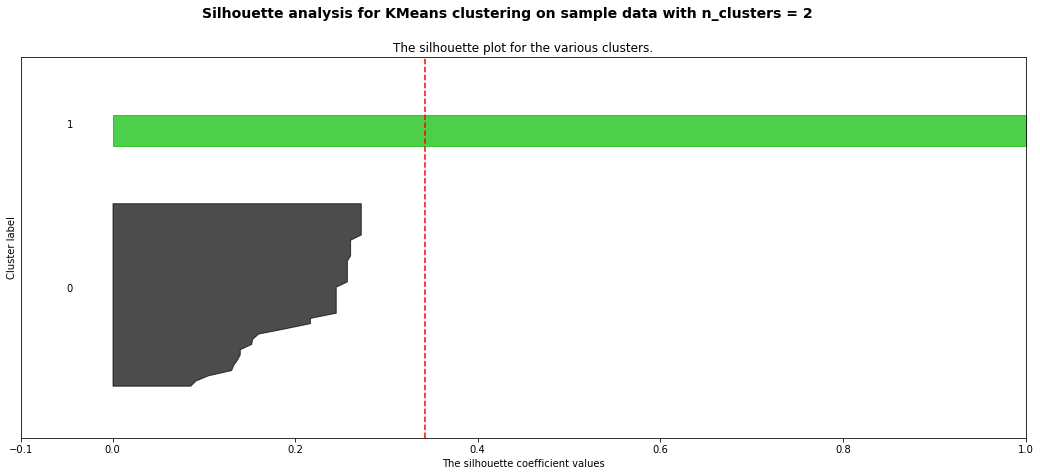

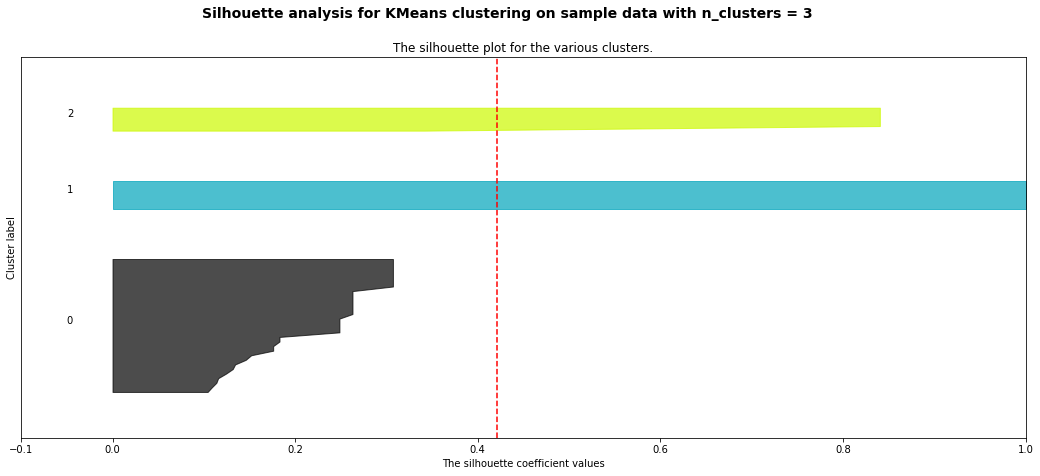

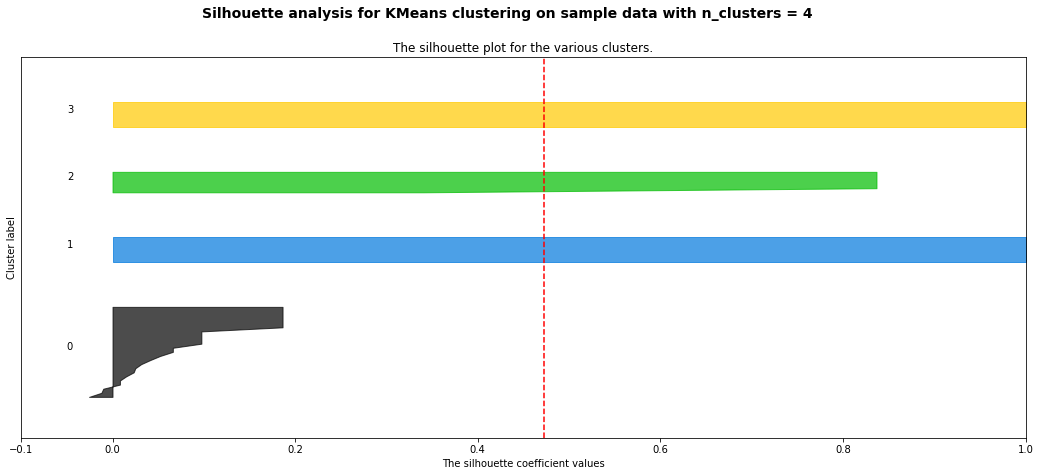

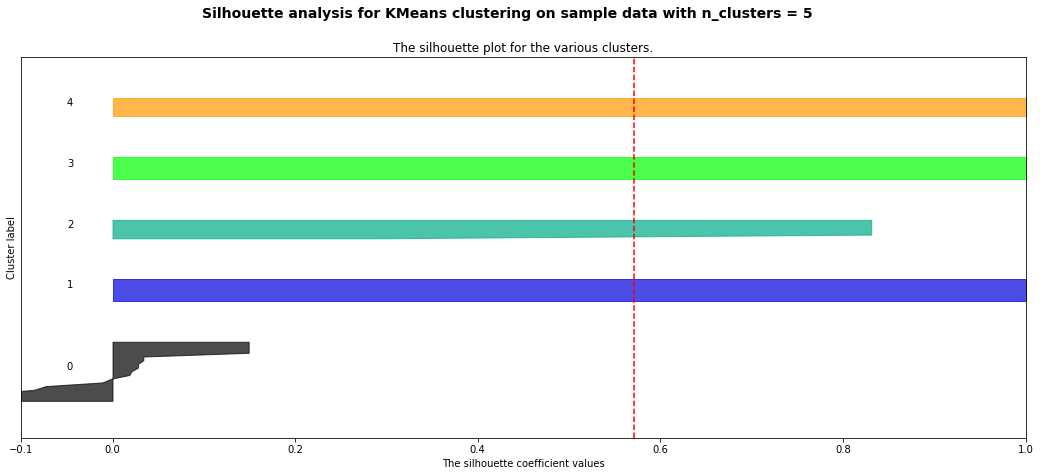

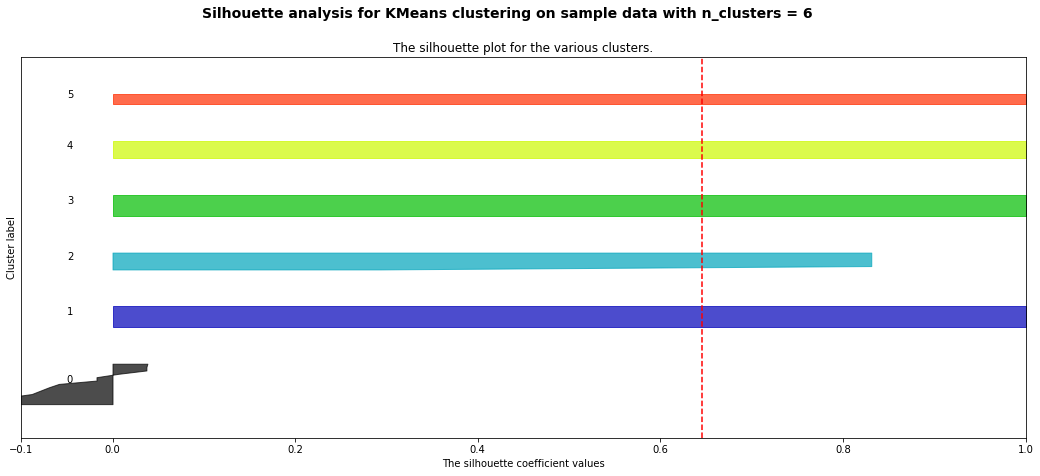

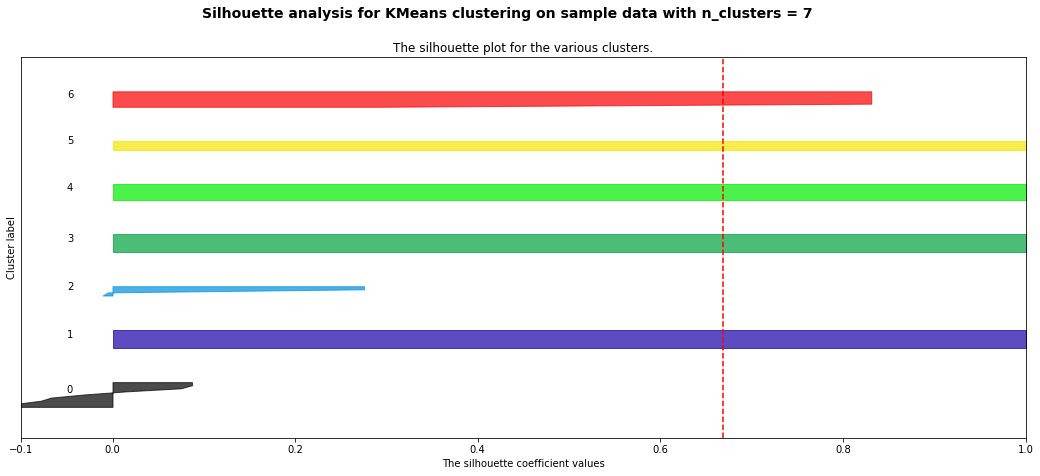

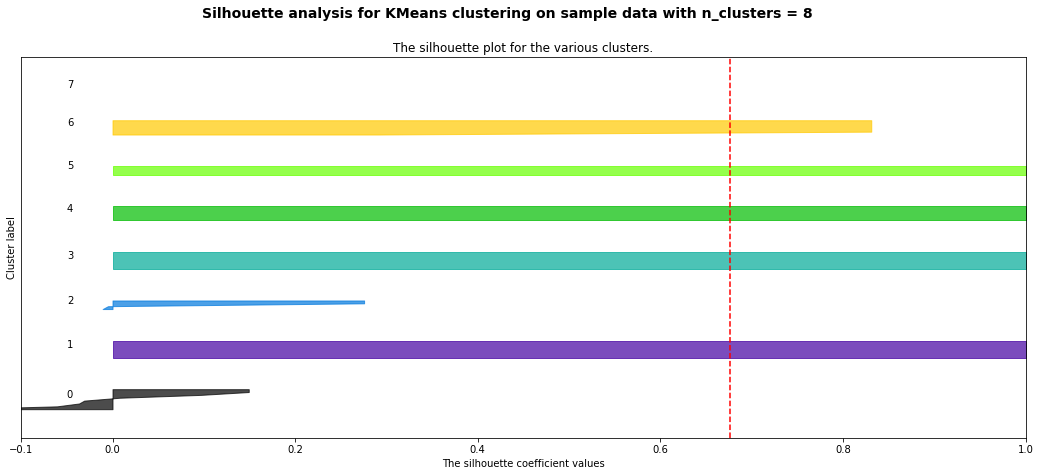

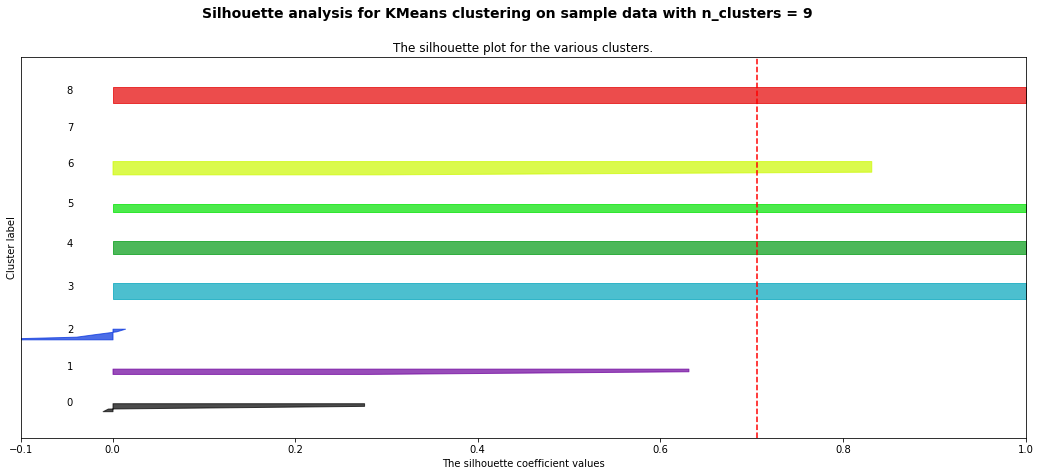

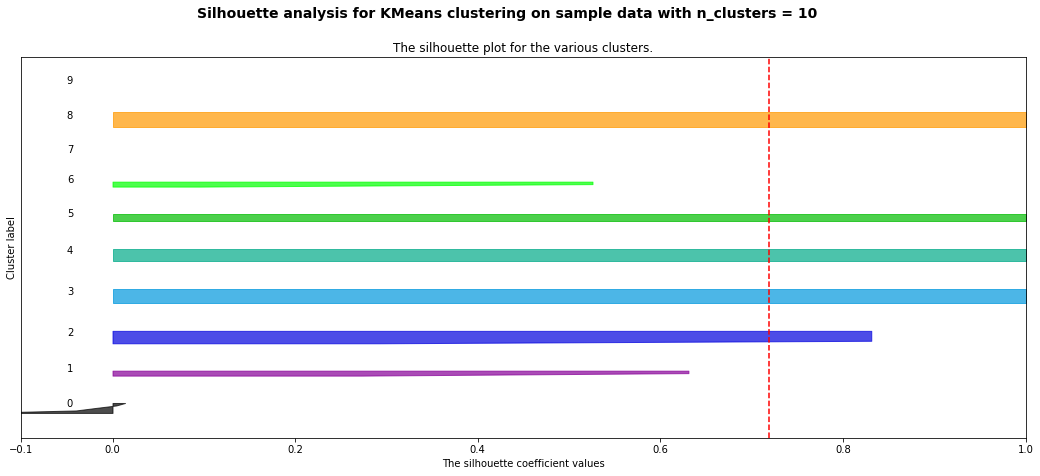

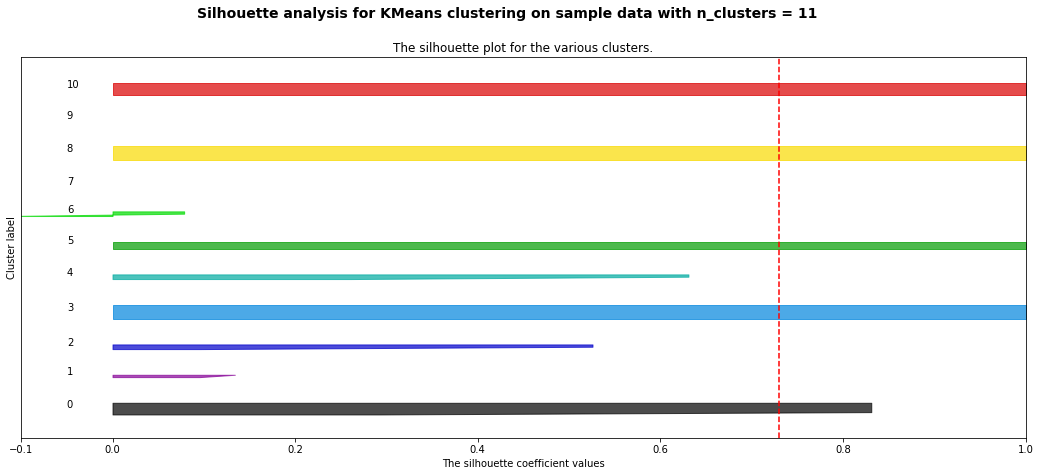

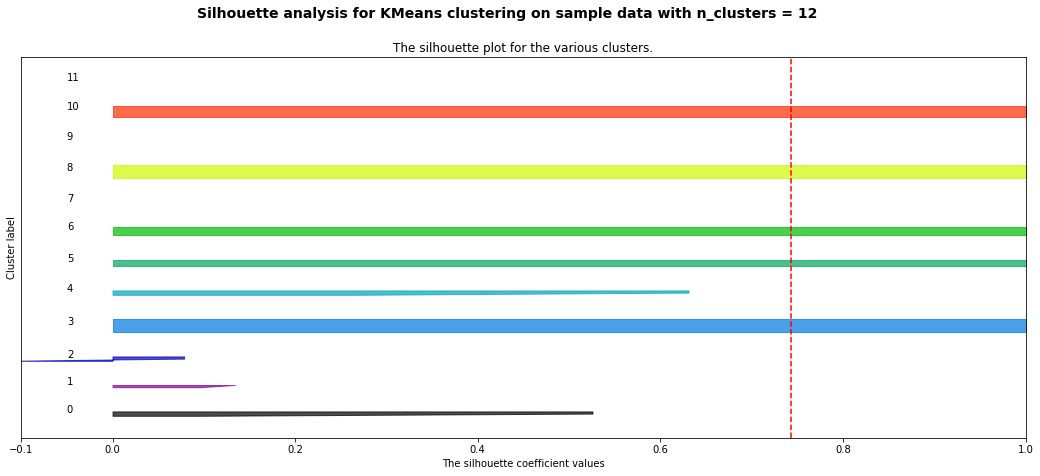

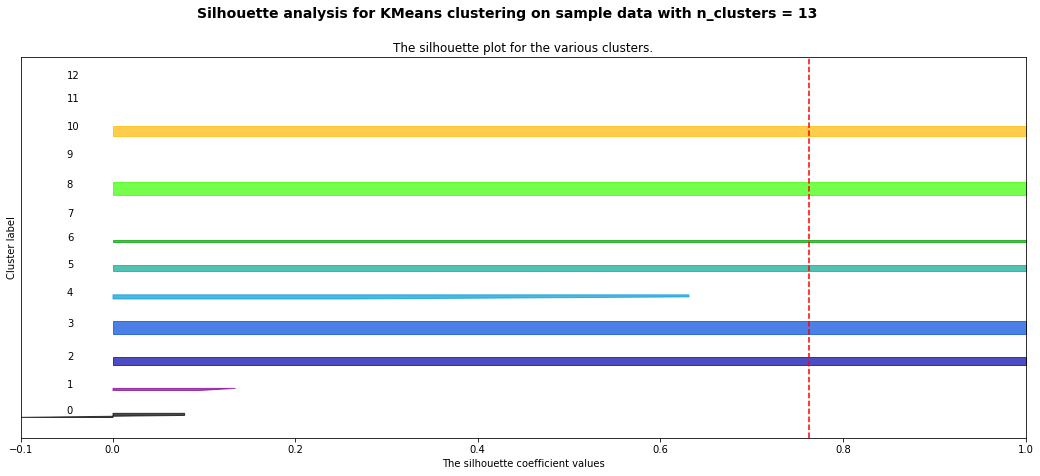

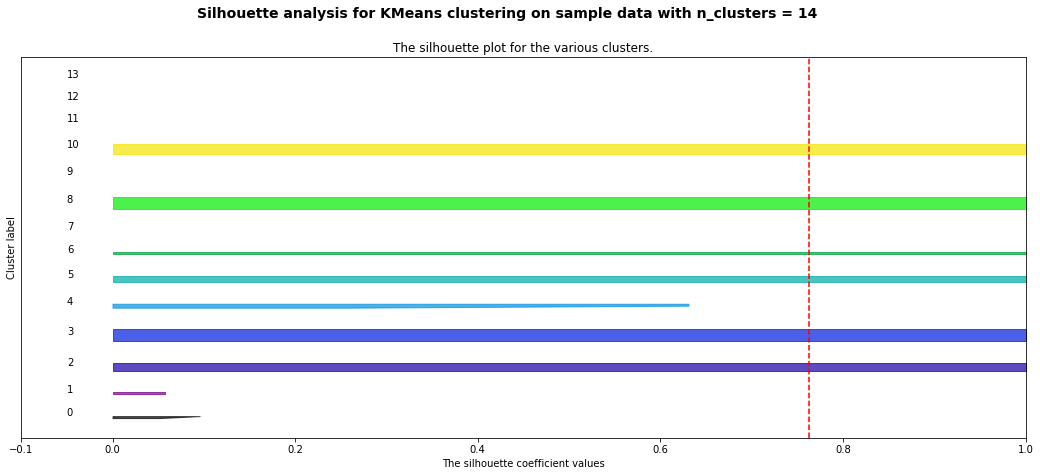

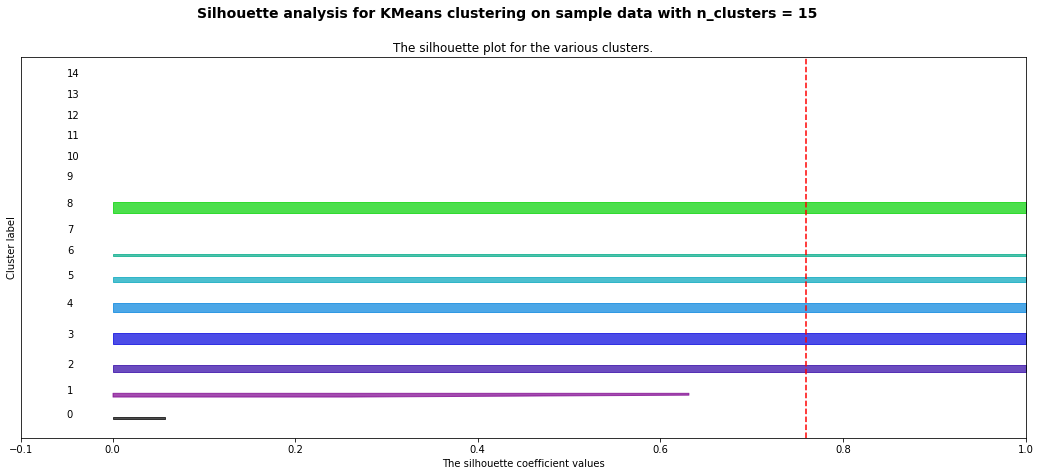

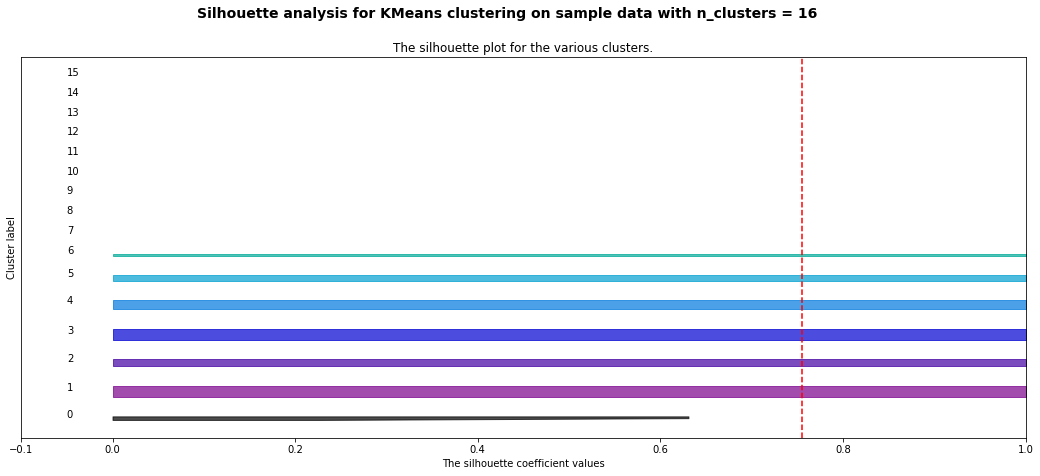

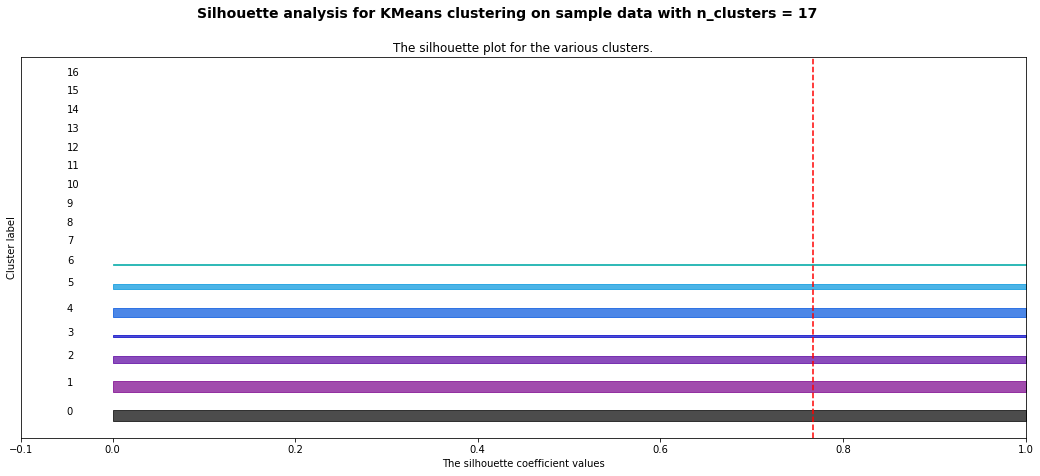

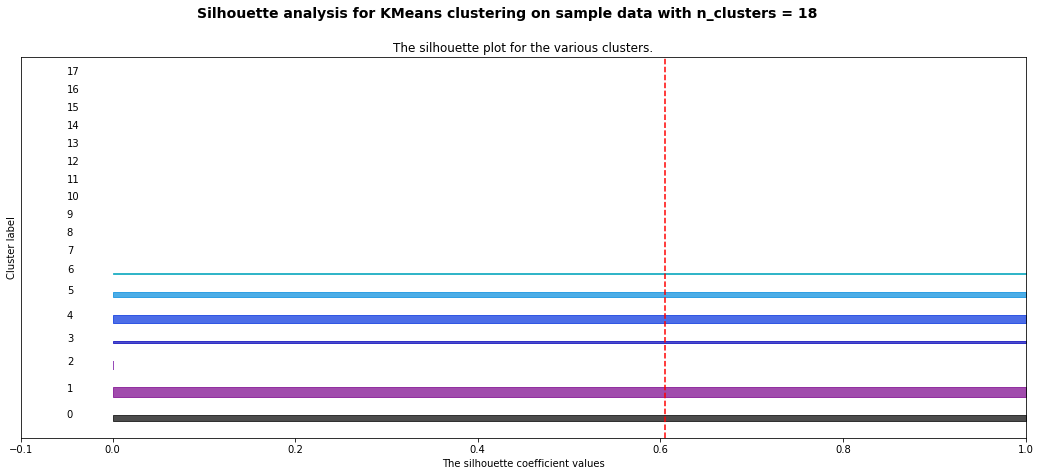

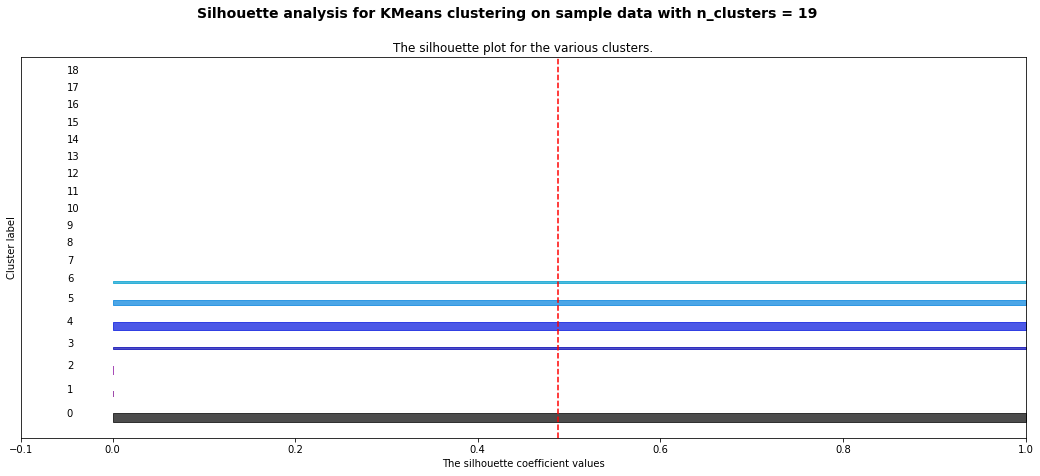

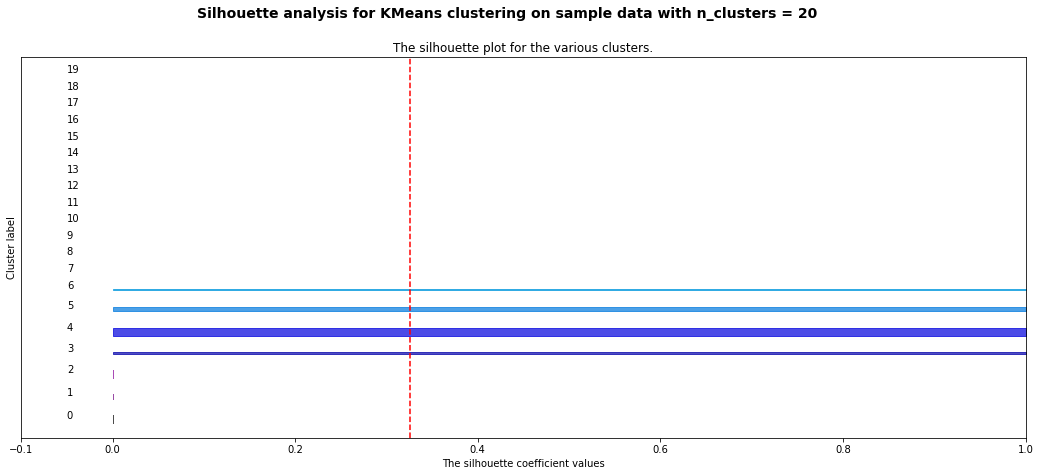

In [94]:
# Evaluate the different models using the Silhoutte Score

silhoutte_score_validation(model = AgglomerativeClustering, transformer = CountVectorizer(lowercase = False), array = X)

For n_clusters = 3 The average silhouette_score is : 0.4212166164425531

In [95]:
# Creation of the pipeline for Gaussian Mixture

pipe_preprocessing = pipeline(est1 = CountVectorizer(lowercase = False))

pipe_predictor = pipeline2(est2 = AgglomerativeClustering(3))

pipe_agglomerative_cv = pipeline3(pipeline = pipe_preprocessing, pipeline2 = pipe_predictor)

# Fit the final pipeline

pipe_agglomerative_cv.fit(X)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('est1', CountVectorizer(lowercase=False)),
                                 ('pca', TruncatedSVD())])),
                ('predictor',
                 Pipeline(steps=[('est2',
                                  AgglomerativeClustering(n_clusters=3))]))])

In [96]:
# Transform the data for the preprocessor

preprocessed_data = pipe_agglomerative_cv['preprocessor'].transform(X)

# Labels Predictions

predicted_labels = pipe_agglomerative_cv['predictor']['est2'].labels_

In [97]:
# Get the coordenates for the keyword ("Aspiring Human Resources")

keywords_preprocessed = pipe_agglomerative_cv['preprocessor'].transform(["aspiring human resources"])

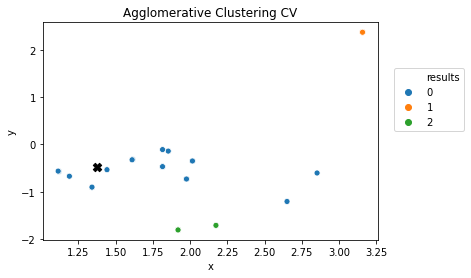

In [98]:
# Save the results in a data frame

results = results_df(preprocessing = preprocessed_data, predictions = predicted_labels)

# Plot the scatter plot with the centroids

plot_scatter(df = results, keyword = keywords_preprocessed, title = 'Agglomerative Clustering CV')

In [99]:
# Calculation of the Calinski Harabasz Score

metric_score(array1 = preprocessed_data, array2 = predicted_labels)

The Calinski Harabasz Score is 232.7986183251484
The Davies Bouldin score is 0.30144886301976026


In [100]:
# See the fit of each person based on the euclidean distance

results_agglomerative_cv = euclidean_distance(df = results, keyword = keywords_preprocessed).head(number_candidates)

In [101]:
results_agglomerative_cv

,x,y,results,id,job_title,location,connection,distance,fit
38,1.442264,-0.534608,0,79,liberal arts major aspiring human resources an...,baton rouge louisiana,7,0.093397,0.910832
36,1.189929,-0.672782,0,75,nortia staffing seeking human resources payrol...,san jose california,500,0.270239,0.763197
16,1.118540,-0.572492,0,30,seeking human resources opportunities,chicago illinois,390,0.272256,0.761660
14,1.118540,-0.572492,0,28,seeking human resources opportunities,chicago illinois,390,0.272256,0.761660
41,1.114719,-0.564789,0,99,seeking human resources position,las vegas nevada,48,0.273134,0.760991
40,1.610725,-0.324884,0,97,aspiring human resources professional,kokomo indiana,71,0.280987,0.755038
34,1.614871,-0.318628,0,72,business management major aspiring human resou...,monroe louisiana,5,0.287826,0.749892


#### TF-IDF

For n_clusters = 2 The average silhouette_score is : 0.22987235119107474
For n_clusters = 3 The average silhouette_score is : 0.37133580738996735
For n_clusters = 4 The average silhouette_score is : 0.49794990131419986
For n_clusters = 5 The average silhouette_score is : 0.592787475911502
For n_clusters = 6 The average silhouette_score is : 0.6670023241615151
For n_clusters = 7 The average silhouette_score is : 0.7128347720518349
For n_clusters = 8 The average silhouette_score is : 0.7415220833342167
For n_clusters = 9 The average silhouette_score is : 0.7485405064684423
For n_clusters = 10 The average silhouette_score is : 0.7526621068164014
For n_clusters = 11 The average silhouette_score is : 0.7552803853314501
For n_clusters = 12 The average silhouette_score is : 0.7585983782142046
For n_clusters = 13 The average silhouette_score is : 0.7576129898193189
For n_clusters = 14 The average silhouette_score is : 0.7670878066289768
For n_clusters = 15 The average silhouette_score is : 0.7

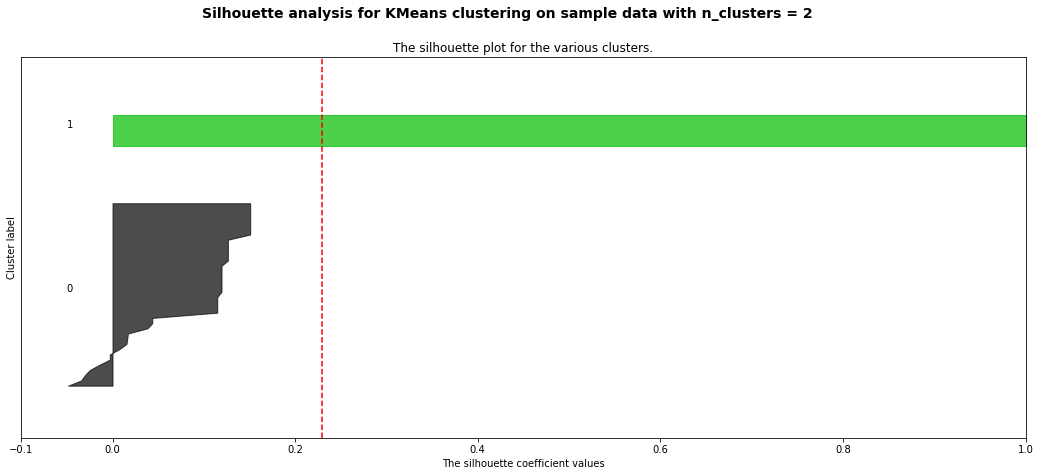

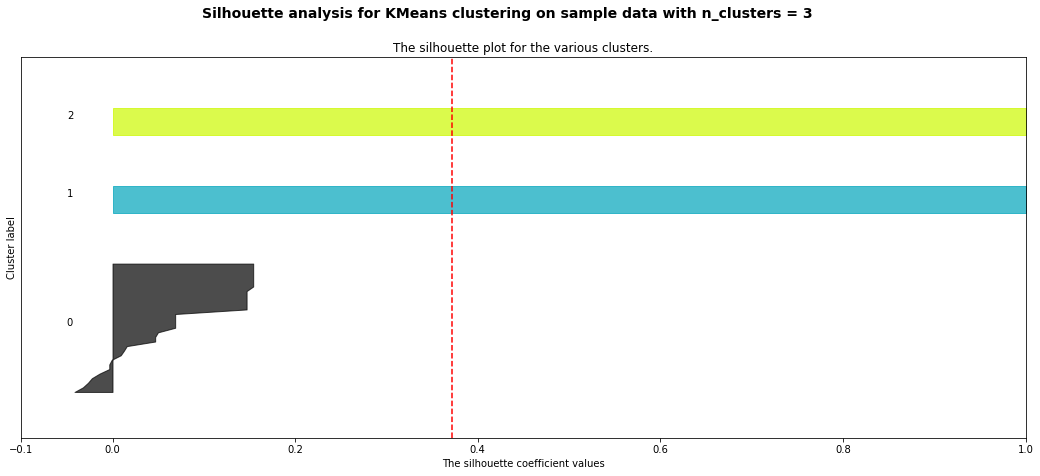

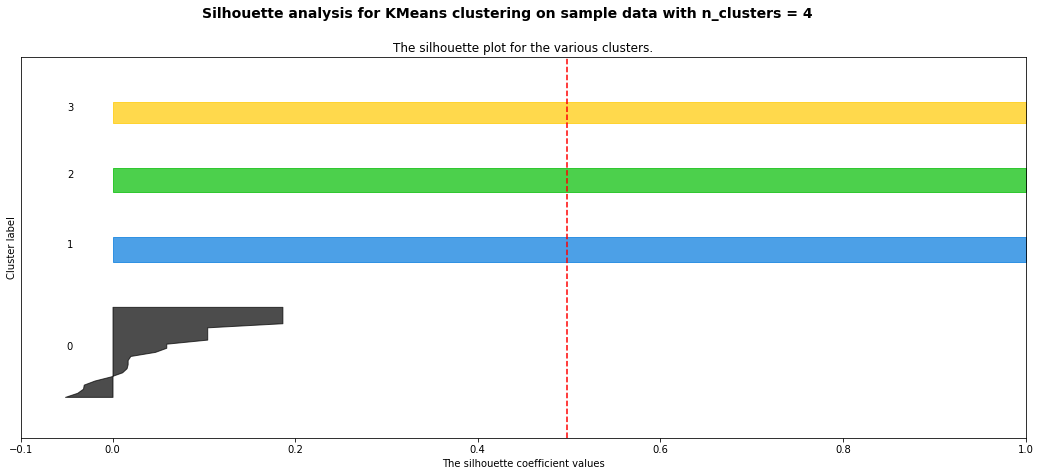

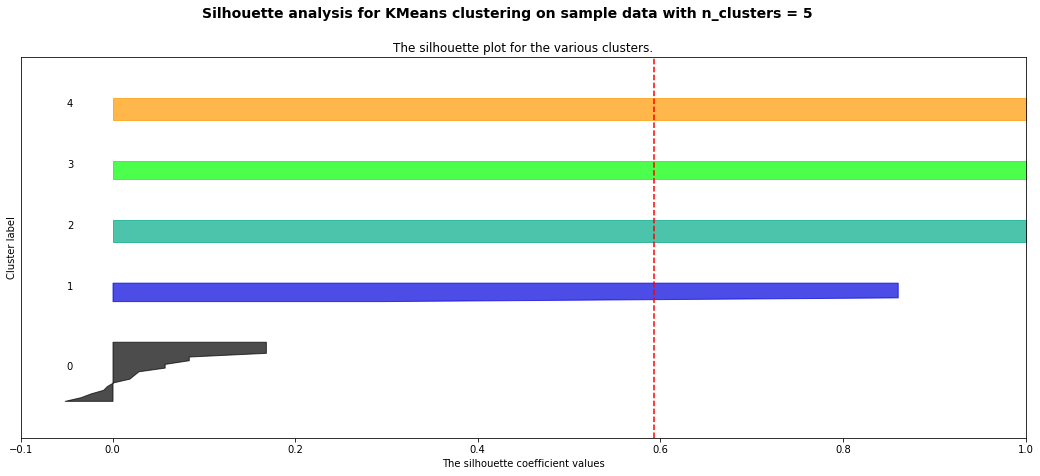

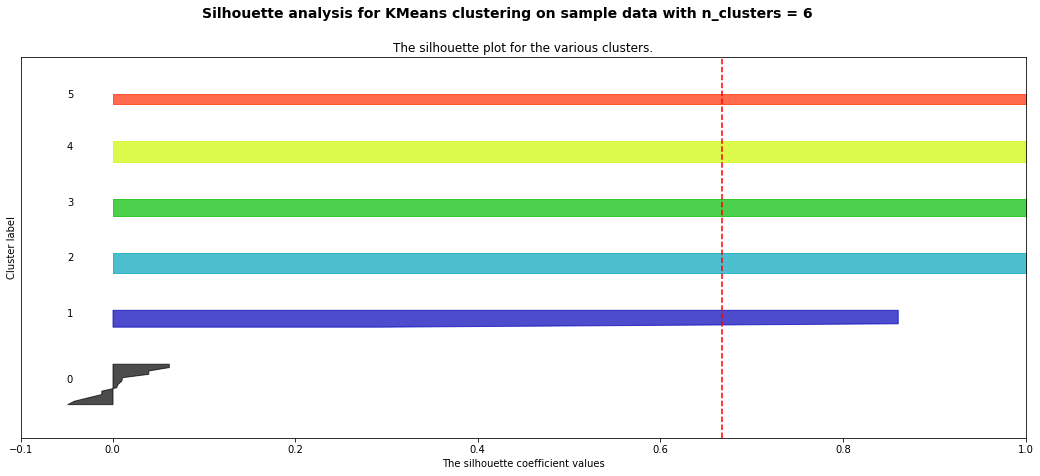

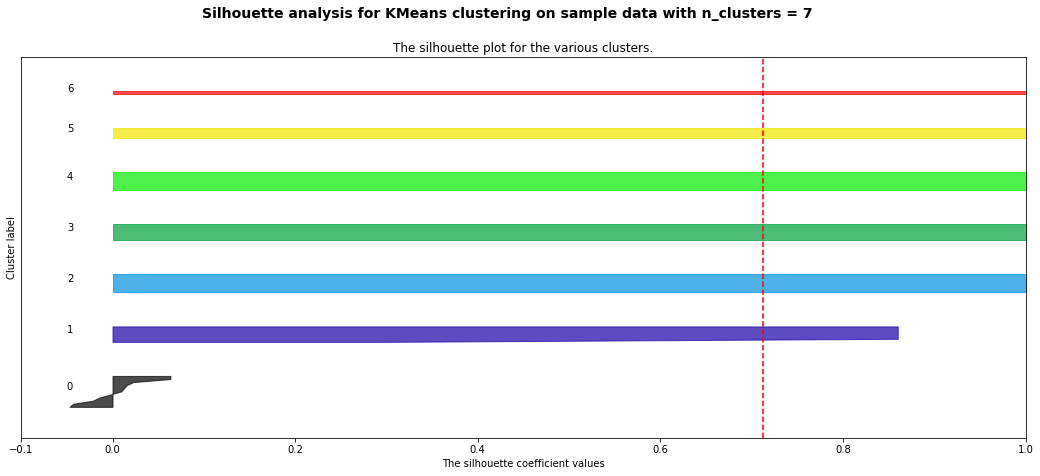

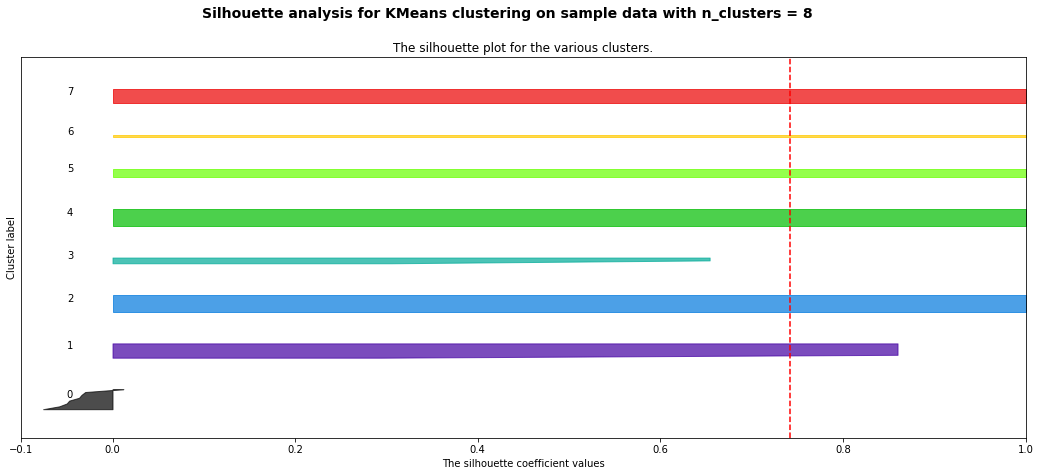

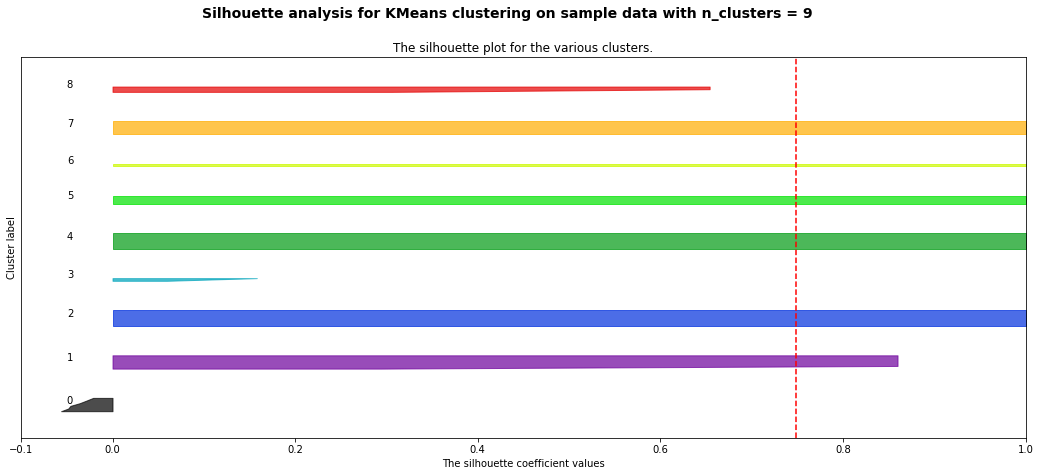

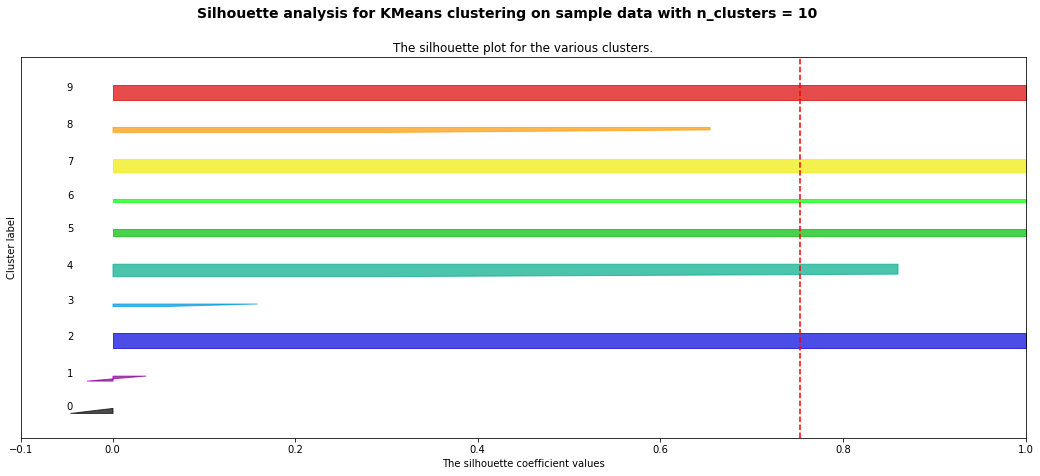

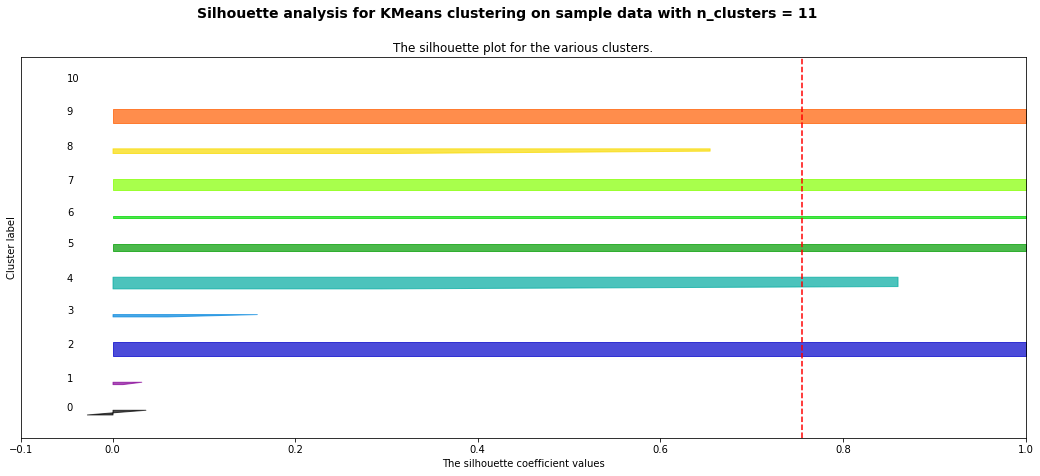

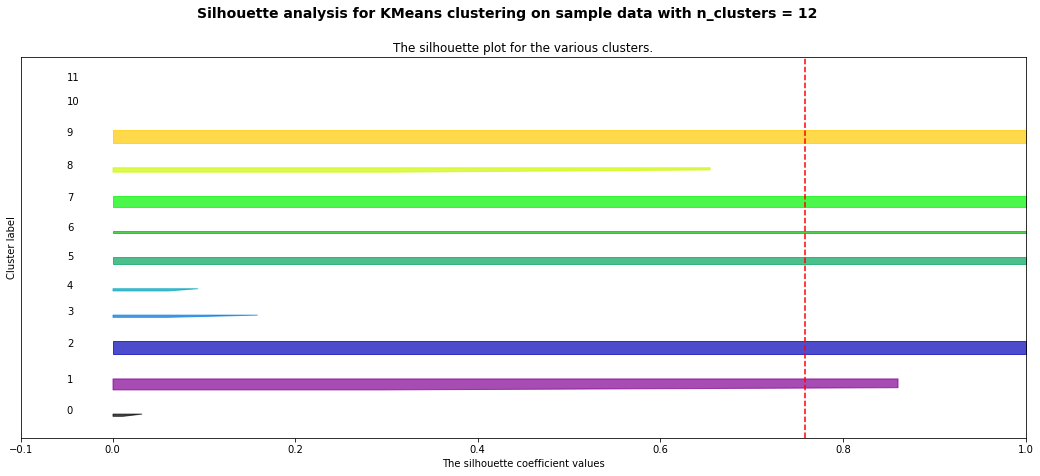

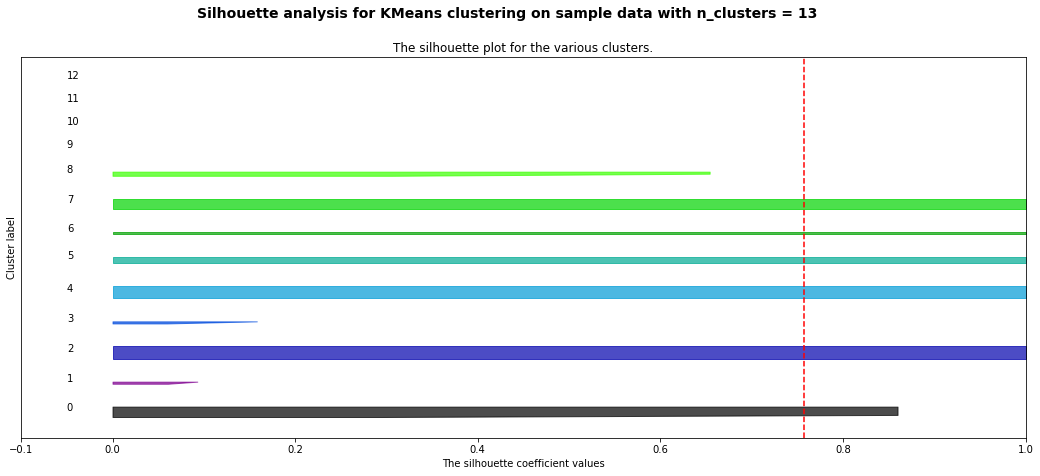

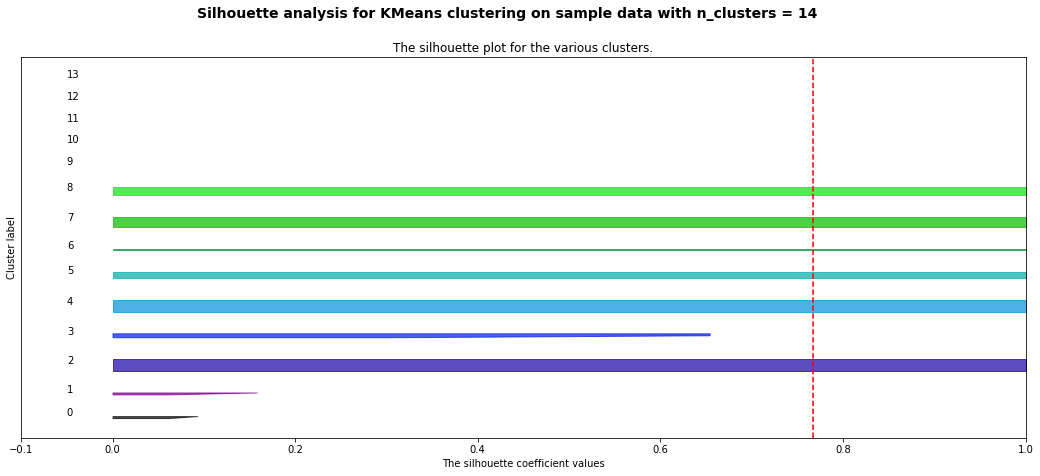

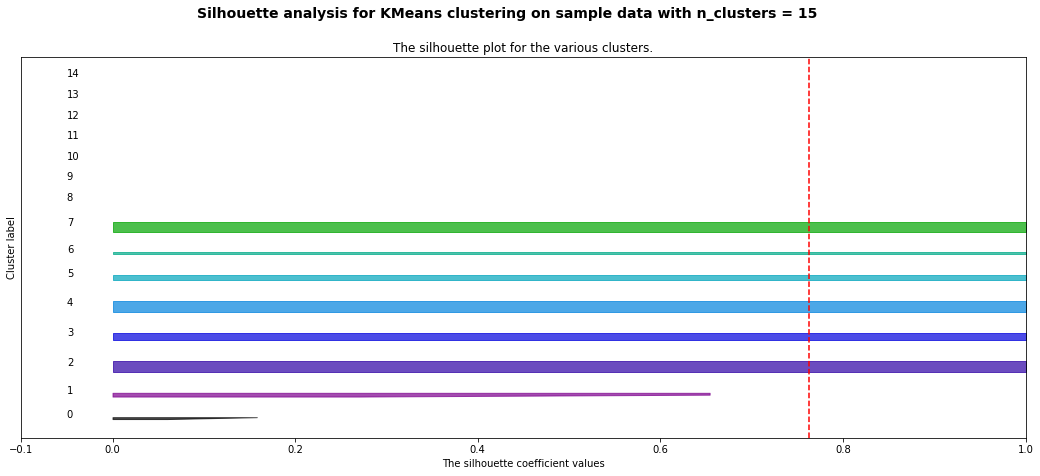

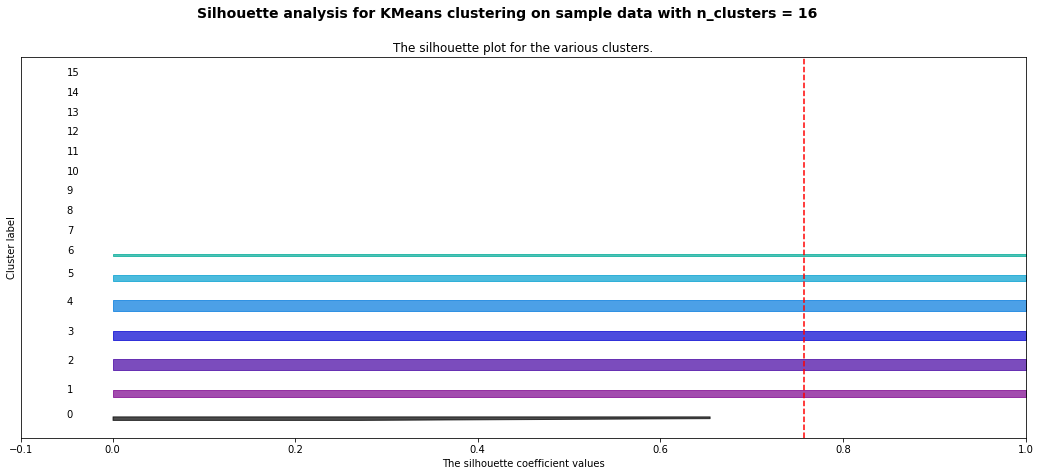

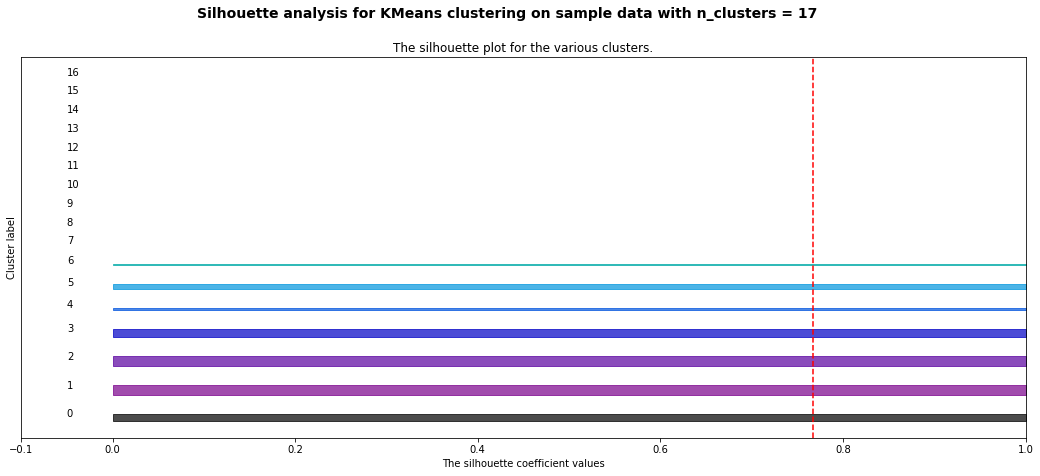

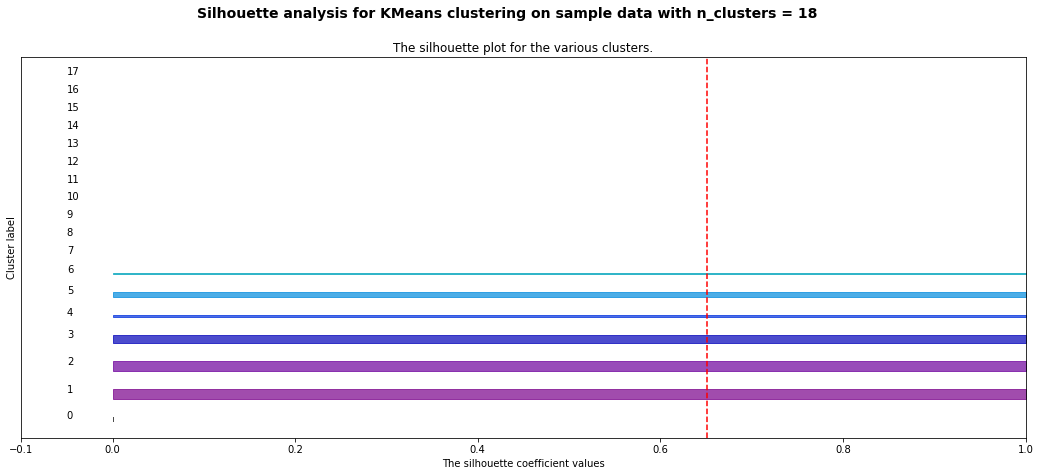

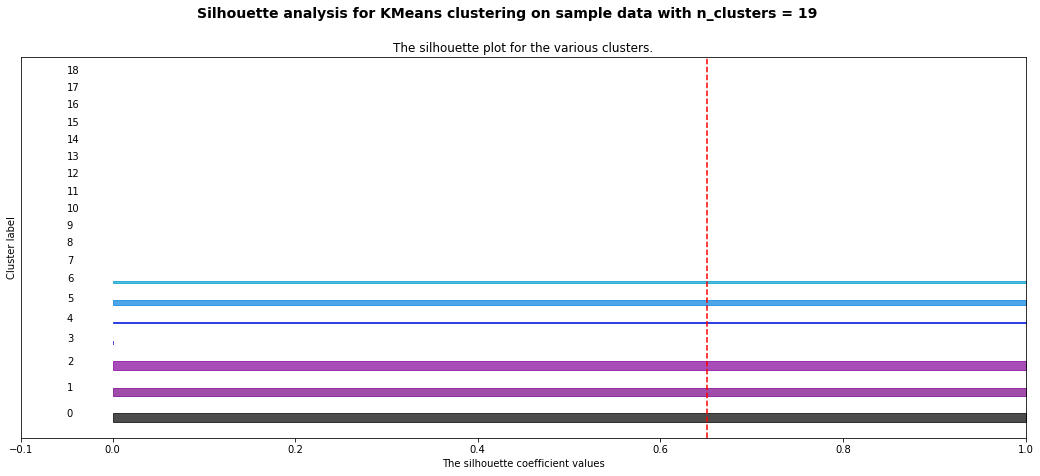

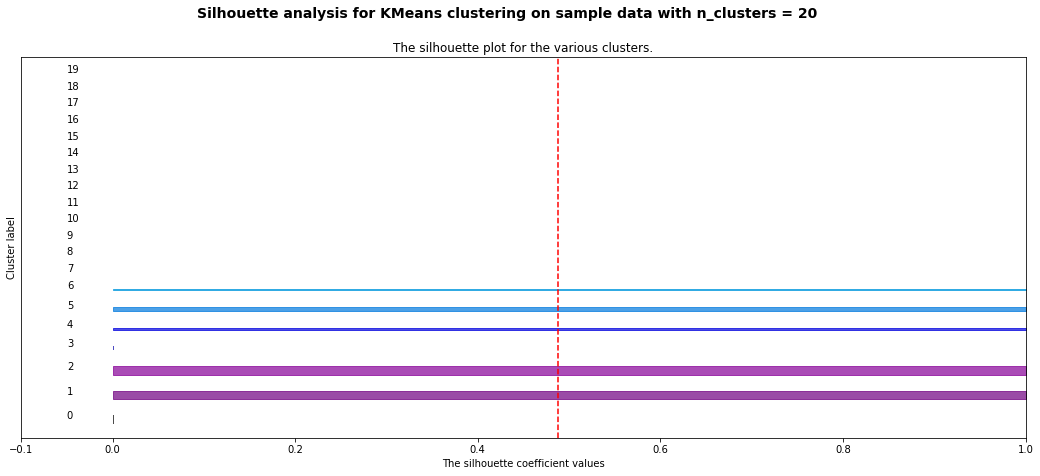

In [102]:
# Evaluate the different models using the Silhoutte Score

silhoutte_score_validation(model = AgglomerativeClustering, transformer = TfidfVectorizer(lowercase = False), array = X)

In [103]:
# Creation of the pipeline for Gaussian Mixture

pipe_preprocessing = pipeline(est1 = TfidfVectorizer(lowercase = False))

pipe_predictor = pipeline2(est2 = AgglomerativeClustering(3))

pipe_agglomerative_cv = pipeline3(pipeline = pipe_preprocessing, pipeline2 = pipe_predictor)

# Fit the final pipeline

pipe_agglomerative_cv.fit(X)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('est1', TfidfVectorizer(lowercase=False)),
                                 ('pca', TruncatedSVD())])),
                ('predictor',
                 Pipeline(steps=[('est2',
                                  AgglomerativeClustering(n_clusters=3))]))])

In [104]:
# Transform the data for the preprocessor

preprocessed_data = pipe_agglomerative_cv['preprocessor'].transform(X)

# Labels Predictions

predicted_labels = pipe_agglomerative_cv['predictor']['est2'].labels_

In [105]:
# Get the coordenates for the keyword ("Aspiring Human Resources")

keywords_preprocessed = pipe_agglomerative_cv['preprocessor'].transform(["aspiring human resources"])

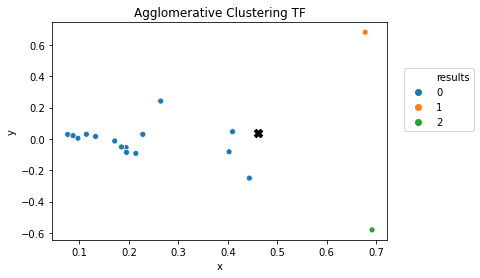

In [106]:
# Save the results in a data frame

results = results_df(preprocessing = preprocessed_data, predictions = predicted_labels)

# Plot the scatter plot with the centroids

plot_scatter(df = results, keyword = keywords_preprocessed, title = 'Agglomerative Clustering TF')

In [107]:
# Calculation of the Calinski Harabasz Score

metric_score(array1 = preprocessed_data, array2 = predicted_labels)

The Calinski Harabasz Score is 134.4314131688659
The Davies Bouldin score is 0.2338500326798779


In [108]:
# See the fit of each person based on the euclidean distance

results_agglomerative_tf = euclidean_distance(df = results, keyword = keywords_preprocessed).head(number_candidates)

In [109]:
results_agglomerative_tf

,x,y,results,id,job_title,location,connection,distance,fit
15,0.409560,0.046082,0,29,aspiring human resources management student se...,houston texas,500,0.052710,0.948655
13,0.409560,0.046082,0,27,aspiring human resources management student se...,houston texas,500,0.052710,0.948655
35,0.402413,-0.082171,0,73,aspiring human resources manager seeking inter...,houston texas,7,0.133555,0.874980
11,0.228031,0.029008,0,24,aspiring human resources specialist,new york new york,1,0.233702,0.791597
2,0.228031,0.029008,0,6,aspiring human resources specialist,new york new york,1,0.233702,0.791597
19,0.228031,0.029008,0,36,aspiring human resources specialist,new york new york,1,0.233702,0.791597
31,0.228031,0.029008,0,60,aspiring human resources specialist,new york new york,1,0.233702,0.791597


#### Insights in order to select the model


###### I try out multiples times the Silhoutte Score on the same model in oder to calculate the number of clusters/components to use in order to select the candidates. The model that showed better consistencies after running the silhoutte score example was the Agglomerative Clustering with Count Vectorization and 3 clusters (I also needed to make sure not so many clusters were used because of the prevention of overfitting). 

###### The agglomerative clustering also presented a decent Calisnki and Davies Bouldin score even though is lower than in some models that were also used. For instance if I compare these scores with the scores obtained using the Affinity Propagation, the scores of the agglomerative clustering were lower, but this can be explained because of the presence of less clusters.

###### For the other models, the number of clusters to determine the Silhoutte score varies and they don't present consistency, so based on this I used the model that gave me the higher consistency with the data.

###### Agglomerative Clustering model with 3 components and using Count Vectorization

In [110]:
# See the results with the best model performance

results_agglomerative_cv

,x,y,results,id,job_title,location,connection,distance,fit
38,1.442264,-0.534608,0,79,liberal arts major aspiring human resources an...,baton rouge louisiana,7,0.093397,0.910832
36,1.189929,-0.672782,0,75,nortia staffing seeking human resources payrol...,san jose california,500,0.270239,0.763197
16,1.118540,-0.572492,0,30,seeking human resources opportunities,chicago illinois,390,0.272256,0.761660
14,1.118540,-0.572492,0,28,seeking human resources opportunities,chicago illinois,390,0.272256,0.761660
41,1.114719,-0.564789,0,99,seeking human resources position,las vegas nevada,48,0.273134,0.760991
40,1.610725,-0.324884,0,97,aspiring human resources professional,kokomo indiana,71,0.280987,0.755038
34,1.614871,-0.318628,0,72,business management major aspiring human resou...,monroe louisiana,5,0.287826,0.749892


In [111]:
# Create a new column that will be the fit an user will put for the specific candidate

fit_manual = []

# The range would be from the candidate one (zero index) to the length of the number of candidates selected
for i in range(number_candidates):
    #Make the reader know the input must be between 0 and 1.0
    print('Insert the fit score for the candidate that must be between 0 and 1.0')
    # This score will be manually inserted by the person in charge
    x = float(input('Insert fit score: '))
    # Make sure the fit score would be under 1.0
    while x > 1.0:
        print('Value must be between 0 and 1.0')
        # All the scores would go to an empty list
        x = float(input('Insert fit score'))
    else:
        fit_manual.append(x)
    

# Append the list to the data frame

results_agglomerative_cv['fit_manual'] = fit_manual

# I will try to avoid any human bias by creating a new column that will indicate the final fit by using a weighted 
#average

results_agglomerative_cv['final_fit'] = results_agglomerative_cv['fit']*0.5 + results_agglomerative_cv['fit_manual']*0.5

#Finally sort the values by descending order

results_agglomerative_cv = results_agglomerative_cv.sort_values(by = 'final_fit', ascending = False)

#See the final data frame with the final fits score

print('Final data frame for the candidates')
results_agglomerative_cv

Insert the fit score for the candidate that must be between 0 and 1.0
Insert fit score: 1.0
Insert the fit score for the candidate that must be between 0 and 1.0
Insert fit score: 2.0
Value must be between 0 and 1.0
Insert fit score0.7
Insert the fit score for the candidate that must be between 0 and 1.0
Insert fit score: 0.8
Insert the fit score for the candidate that must be between 0 and 1.0
Insert fit score: 0.6
Insert the fit score for the candidate that must be between 0 and 1.0
Insert fit score: 0.5
Insert the fit score for the candidate that must be between 0 and 1.0
Insert fit score: 0.7
Insert the fit score for the candidate that must be between 0 and 1.0
Insert fit score: 0.8
Final data frame for the candidates


,x,y,results,id,job_title,location,connection,distance,fit,fit_manual,final_fit
38,1.442264,-0.534608,0,79,liberal arts major aspiring human resources an...,baton rouge louisiana,7,0.093397,0.910832,1.0,0.955416
16,1.118540,-0.572492,0,30,seeking human resources opportunities,chicago illinois,390,0.272256,0.761660,0.8,0.780830
34,1.614871,-0.318628,0,72,business management major aspiring human resou...,monroe louisiana,5,0.287826,0.749892,0.8,0.774946
36,1.189929,-0.672782,0,75,nortia staffing seeking human resources payrol...,san jose california,500,0.270239,0.763197,0.7,0.731599
40,1.610725,-0.324884,0,97,aspiring human resources professional,kokomo indiana,71,0.280987,0.755038,0.7,0.727519
14,1.118540,-0.572492,0,28,seeking human resources opportunities,chicago illinois,390,0.272256,0.761660,0.6,0.680830
41,1.114719,-0.564789,0,99,seeking human resources position,las vegas nevada,48,0.273134,0.760991,0.5,0.630495
